### Import the required packages

The python modules that are required for this analysis are imported here

In [1]:
import my_functions as my

import matplotlib.dates as mdates
import matplotlib
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator(interval=1)  # every month
weeks = mdates.WeekdayLocator(byweekday=mdates.MO, interval=2)
week = mdates.WeekdayLocator(byweekday=mdates.MO, interval=1)
yearsFmt = mdates.DateFormatter("%d.%m")

matplotlib.rcParams['figure.figsize'] = (18,10)
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.direction'] = 'in'

font = {'family' : 'Arial',
        'weight' : 'ultralight',
        'size'   : 14}

matplotlib.rc('font', **font)

matplotlib.rc('ytick.major', size=6)
matplotlib.rc('xtick.major', size=6)
matplotlib.rc('ytick.minor', size=4)
matplotlib.rc('xtick.minor', size=4)
matplotlib.rc('lines', linewidth=2.5)

### Load in the level 2 processes and cleaned glider data

In [2]:
interp_res = '1D'
offset     = '12H'
dt=86400

In [3]:
import glidertools as gt
import xarray as xr
import numpy as np

dat_saz = xr.open_dataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/sg542_saz_L2.nc')
dat_apz = xr.open_dataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/slocum_apz_L2.nc')
dat_miz = xr.open_dataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/sg643_miz_L2.nc')

dat_saz_interp = dat_saz.resample(time=interp_res, loffset=offset).mean()
dat_apz_interp = dat_apz.resample(time=interp_res, loffset=offset).mean()
dat_miz_interp = dat_miz.resample(time=interp_res, loffset=offset).mean()

dat_saz_interp=dat_saz_interp.interpolate_na(dim='time')
dat_apz_interp=dat_apz_interp.interpolate_na(dim='time')
dat_miz_interp=dat_miz_interp.interpolate_na(dim='time')

import my_functions as my

for i, dat in enumerate([dat_saz_interp, dat_apz_interp, dat_miz_interp]):
    
    dat['mld_03'] = (('time'), my.calc_mld(dat.density, dat.depth, den_lim=0.03))

for dat in [dat_saz_interp, dat_apz_interp, dat_miz_interp]:

    xt=[]
    xs=[]
    
    for i, m in enumerate(np.round(dat['mld_03'].astype(int))):
        
        xt += dat.temp.sel(depth=slice(5, m)).mean(dim='depth').values[i],
        xs += dat.salt.sel(depth=slice(5, m)).mean(dim='depth').values[i],
    
    dat['ml_s'] = (('time'), xs)
    dat['ml_t'] = (('time'), xt)



#### Load air-sea heat and freshwater fluxes

In [4]:
era5 = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/ERA5_flux_data/*.nc')
era5 = era5.sel(latitude=slice(-40, -65), longitude=slice(-5, 10))

#### Convert from J m$^{-2}$ to W m$^{-2}$

In [5]:
var_name=['slhf', 'sshf', 'str', 'ssr', 'tp', 'e']
era5=my.convert_era5_to_Wm2(ds=era5, var_name=var_name)

#### Calculate the net surface heat flux and evaporation minus precipitation

In [6]:
era5['emp']  = (('time', 'latitude', 'longitude'), era5['e']-era5['tp'])
era5['qnet'] = (('time', 'latitude', 'longitude'), era5['slhf']+era5['sshf']+era5['str' ]+era5['ssr' ])

#### Estimate the standard error based on the number of observations interpolated time scheme

In [7]:
era5_interp = era5.resample(time=interp_res, loffset=offset).mean()
# era5_interp_std = era5.resample(time=interp_res, loffset=offset).std()

Standard error calculations

In [8]:
import numpy as np

# var_name = ['u10' ,'v10' ,'e'   ,'tp'  ,'emp' ,'sst' ,'sshf','slhf','str' ,'ssr' ,'qnet']

# for var in var_name:
#     era5_interp[var+'_se'] = (('time', 'latitude', 'longitude'), era5_interp_std[var]/np.sqrt(12))

#### Co-locate air-sea flux variables and get standard error

In [9]:
from tqdm import tqdm

var_name = ['slhf','sshf','str' ,'ssr' ,'tp' ,'e' ,'emp' , 'u10', 'v10', 'qnet']
#             'slhf_se','sshf_se','str_se' ,'ssr_se' ,'tp_se' ,'e_se', 'emp_se', 'u10_se', 'v10_se', 'qnet_se']   

for var in tqdm(var_name):
    
    dat_saz_interp[var] = (('time'), my.interp_glider_era5(dat_saz_interp, era5_interp, var=var))
    dat_apz_interp[var] = (('time'), my.interp_glider_era5(dat_apz_interp, era5_interp, var=var))
    dat_miz_interp[var] = (('time'), my.interp_glider_era5(dat_miz_interp, era5_interp, var=var))

100%|██████████| 10/10 [00:21<00:00,  2.19s/it]


#### Calculate the wind stress

In [10]:
import airsea

for dat in [dat_saz_interp, dat_apz_interp, dat_miz_interp]:
    
    dat['taux'] = (('time'), airsea.windstress.stress(dat.u10, z=10., drag='largepond'))
    dat['tauy'] = (('time'), airsea.windstress.stress(dat.v10, z=10., drag='largepond'))
    
#     dat['taux_se'] = (('time'), airsea.windstress.stress(dat.u10_se, z=10., drag='largepond'))
#     dat['tauy_se'] = (('time'), airsea.windstress.stress(dat.v10_se, z=10., drag='largepond'))
    
    dat['tau']    = (('time'), np.sqrt(dat['taux']**2 + dat['tauy']**2))
#     dat['tau_se'] = (('time'), np.sqrt(dat['taux_se']**2 + np.sqrt(dat['tauy_se']**2)))
    

In [11]:
my_clrs = [(255/255, 185/255, 0/255), (53/255,97/255,143/255), (157/255,13/255,108/255), (52/255,134/255,92/255), (11/255,25/255,110/255), (144/255,88/255,132/255), (49/255,94/255,234/255)]

#### Plot the surface air-sea fluxes (Figure 2)

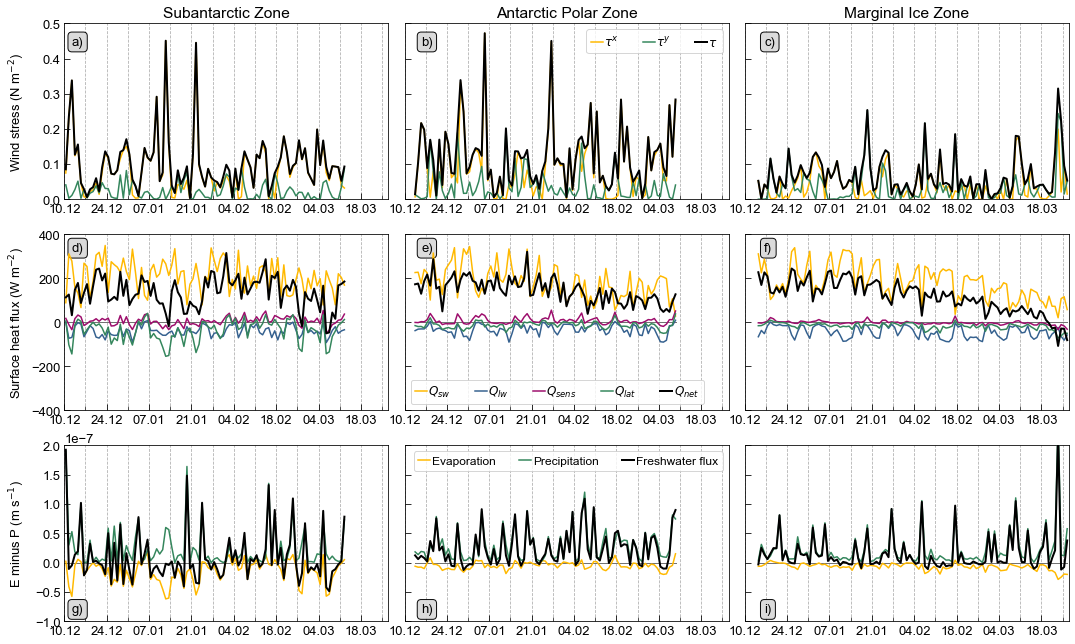

In [58]:
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 13
plt.rc('lines', linewidth=2)

fig,ax=plt.subplots(3,3,figsize=[18, 11])
fig.subplots_adjust(hspace=0.2, wspace=0.05)

plot_props = dict(zorder=10)
fill_props = dict(zorder=10, facecolor=my_clrs[1], alpha=0.5)

for i, dat in enumerate([dat_saz_interp, dat_apz_interp, dat_miz_interp]):
    
    # wind stress    
    ax[0, i].plot(dat.time, dat['taux'], **plot_props, lw=1.5, c=my_clrs[0], label=r'$\tau^x$')
    ax[0, i].plot(dat.time, dat['tauy'], **plot_props, lw=1.5, c=my_clrs[3], label=r'$\tau^y$')
    ax[0, i].plot(dat.time, dat['tau'],  **plot_props, lw=2.0, c='k',        label=r'$\tau$')
    
    # heat flux
    ax[1, i].plot(dat.time, dat['ssr'],  **plot_props, lw=1.5, label='$Q_{sw}$', c=my_clrs[0])
    ax[1, i].plot(dat.time, dat['str'],  **plot_props, lw=1.5, label='$Q_{lw}$',  c=my_clrs[1])
    ax[1, i].plot(dat.time, dat['sshf'], **plot_props, lw=1.5, label='$Q_{sens}$',  c=my_clrs[2])
    ax[1, i].plot(dat.time, dat['slhf'], **plot_props, lw=1.5, label='$Q_{lat}$',    c=my_clrs[3])
    ax[1, i].plot(dat.time, dat['qnet'], **plot_props, lw=2.0, label='$Q_{net}$',       c='k')
    
    # evaporation minus precipitation
    ax[2, i].plot(dat.time, dat['e'],           **plot_props, lw=1.5, label='Evaporation',    c=my_clrs[0])
    ax[2, i].plot(dat.time, dat['tp'],          **plot_props, lw=1.5, label='Precipitation',  c=my_clrs[3])
    ax[2, i].plot(dat.time, dat['e']+dat['tp'], **plot_props, lw=2.0, label='Freshwater flux',c='k'       )
    
    ax[i, 1].yaxis.set_ticklabels([]); ax[i, 2].yaxis.set_ticklabels([])
    
    for ii in range(3):
        
        ax[i,ii].xaxis.set_major_locator(weeks)
        ax[i,ii].xaxis.set_minor_locator(week)
        ax[i,ii].xaxis.set_major_formatter(yearsFmt)
        ax[i,ii].grid(ls='--', which='both', axis='x')
        
        ax[ii,i].plot([dat.time[0].values, dat.time[-1].values], [0, 0], c='0.45', zorder=2, lw=1)
        
        ax[ii,0].set_xlim('2018-12-10', '2019-03-27');
        ax[ii,1].set_xlim('2018-12-10', '2019-03-27');
        ax[ii,2].set_xlim('2018-12-10', '2019-03-27');

[a.set_ylim(0, 0.5) for a in ax[0]]
[a.set_ylim(-400, 400) for a in ax[1]]
[a.set_ylim(-1e-7, 2e-7) for a in ax[2]]

ax[0, 0].set_ylabel('Wind stress (N m$^{-2}$)', labelpad=16)
ax[1, 0].set_ylabel('Surface heat flux (W m$^{-2}$)')
ax[2, 0].set_ylabel('E minus P (m s$^{-1}$)', labelpad=8)

props = dict(boxstyle='round', facecolor='0.85', alpha=0.95)

# place a text box in upper left in axes coords
ax[0, 0].text(dat_saz_interp.time.values[2], 0.43, 'a)', verticalalignment='bottom', bbox=props)
ax[0, 1].text(dat_apz_interp.time.values[2], 0.43, 'b)', verticalalignment='bottom', bbox=props)
ax[0, 2].text(dat_miz_interp.time.values[2], 0.43, 'c)', verticalalignment='bottom', bbox=props)

ax[1, 0].text(dat_saz_interp.time.values[2], 310,     'd)', verticalalignment='bottom', bbox=props)
ax[1, 1].text(dat_apz_interp.time.values[2], 310,     'e)', verticalalignment='bottom', bbox=props)
ax[1, 2].text(dat_miz_interp.time.values[2], 310,     'f)', verticalalignment='bottom', bbox=props)

ax[2, 0].text(dat_saz_interp.time.values[2], -0.9e-7 ,'g)', verticalalignment='bottom', bbox=props)
ax[2, 1].text(dat_apz_interp.time.values[2], -0.9e-7 ,'h)', verticalalignment='bottom', bbox=props)
ax[2, 2].text(dat_miz_interp.time.values[2], -0.9e-7 ,'i)', verticalalignment='bottom', bbox=props)

ax[0,0].set_title('Subantarctic Zone')
ax[0,1].set_title('Antarctic Polar Zone')
ax[0,2].set_title('Marginal Ice Zone')

ax[0,1].legend(ncol=5, loc=1, fontsize=12, handlelength=1, handletextpad=0.1)
ax[1,1].legend(ncol=5, loc=3, fontsize=12, handlelength=1, handletextpad=0.1)
ax[2,1].legend(ncol=5, loc=1, fontsize=12, handlelength=1, handletextpad=0.1)


# fig.tight_layout()
plt.savefig('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/figures/fig2_atm_vars.png', dpi=300, bbox_inches='tight')

In [13]:
from windrose import WindroseAxes
import math

In [14]:
import matplotlib.cm as cm

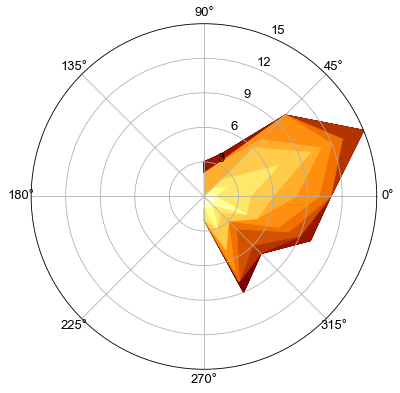

In [15]:
dat = dat_miz_interp

fig=plt.figure(figsize=[6,6])

ws = np.sqrt(dat.u10.values**2 + dat.v10.values**2)
wind_dir_trig_to = [math.atan2(dat.u10.values[i]/ws[i], dat.v10.values[i]/ws[i]) for i, val in enumerate(dat.time)]
wd = np.array(wind_dir_trig_to) * 180/math.pi ## -111.6 degrees

ax = WindroseAxes.from_ax(fig=fig)
ax.contourf(wd, ws, bins=np.arange(0, 18, 1), cmap=cm.afmhot_r)
# ax.bar(wd, ws, normed=True, opening=0.8, edgecolor='white')
# ax.set_legend(ncol=6, bbox_to_anchor=(0.53, 1.2), prop={'size': 10}, loc='upper center',fontsize=60)

props = dict(boxstyle='round', facecolor='0.85', alpha=0.95)

plt.savefig('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/figures/fig4_winddir_miz.png', dpi=300, bbox_inches='tight')

In [16]:
print(dat_saz_interp.ml_s.min().values)
print(dat_saz_interp.ml_s.max().values)

34.24451253895582
34.446255416917666


In [17]:
print(dat_saz_interp.mld_03.mean(dim='time').values)
print(dat_apz_interp.mld_03.mean(dim='time').values)
print(dat_miz_interp.mld_03.mean(dim='time').values)

43.645161290322584
103.83908045977012
39.932038834951456


### 1. Air-sea flux impact on surface temperature and salinity

In [18]:
def heatflux(Q, mld, dt, rho=1027, Cp=3850):
    
    return (Q / (rho * Cp * mld))*dt

In [19]:
def freshwaterflux(E, P, mld, S, dt):
    
    return (( (E-P) * S ) / mld)*dt

In [20]:
for dat in [dat_saz_interp, dat_apz_interp, dat_miz_interp]:
    dat['dT_hf'] = heatflux(Q=dat['qnet'], mld=dat['mld_03'], dt=dt)
    dat['dS_ff'] = freshwaterflux(E=dat['e'], P=dat['tp'], mld=dat['mld_03'], S=dat['ml_s'], dt=dt)

### 2. Ekman advection impact on mixed layer temperature and salinity

In [21]:
def ekman_advection(dat, dt, rho0=1025, f=-1e-4):
        
    taux = gt.cleaning.rolling_window(dat['taux'], func=np.nanmean, window=4) # smooth out sharp changees in the wind dir and speed
    
    ek_vel_y = taux / (rho0 * dat['mld_03'] * f) # units m/s
    
    dT_ek_adv_y = -dt * (ek_vel_y * dat['dT_grad'].values)
    dS_ek_adv_y = -dt * (ek_vel_y * dat['dS_grad'].values)
    
    dat['dT_ek_adv'] = (('time'), dT_ek_adv_y)
    dat['dS_ek_adv'] = (('time'), dS_ek_adv_y)

    return dat

In [22]:
for dat in [dat_saz_interp, dat_apz_interp, dat_miz_interp]:

    dat['tauy'][dat['v10']<0] = -dat['tauy'][dat['v10']<0]
    dat['taux'][dat['u10']<0] = -dat['taux'][dat['u10']<0]

#### Calculate a temperature and salinity spatial gradient from the ship-based TSG dataset

Load Agulhas TSG data

In [23]:
import pandas as pd

tsg = pd.read_excel('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/agulhas_tsg/Agu035_odv.xlsx')

date = pd.to_datetime(tsg.Date+' '+tsg.Time)

tsg = tsg.drop(columns=['Date', 'Time', 'Unnamed: 12', 'Type', 'Cruise'])

tsg['date'] = date

tsg = tsg.set_index(['date'])

tsg = tsg.to_xarray()
i_nat = ~np.isnat(tsg.date) 
tsg = tsg.sel(date=slice(tsg.date[i_nat][0], tsg.date[i_nat][-1]))

tsg.attrs['cruise'] = 'Agu032'
tsg.attrs['ship']   = 'S.A. Agulhas II'
tsg.attrs['owner']  = 'Department of Environmental Affairs, South Africa'
tsg.attrs['instrument']   = 'Thermosalinograph'
tsg.attrs['contact']= 'Marcel van den Berg, marcel@oceanafrica.com'
tsg.attrs['processing'] = 'Level 1 by DEA'
tsg.attrs['time_coverage_start'] = tsg.date[0].values
tsg.attrs['time_coverage_end']   = tsg.date[-1].values

Clean TSG data

In [24]:
import glidertools as gt

tsg = tsg.sel(date=slice(tsg.date[0], tsg.date[150000]))

s = gt.cleaning.rolling_window(tsg.s, func=np.median, window=100)
s = gt.cleaning.rolling_window(s, func=np.mean, window=100)

t = gt.cleaning.rolling_window(tsg.t2, func=np.median, window=100)
t = gt.cleaning.rolling_window(t, func=np.mean, window=100)

tsg['t_clean'] = (('date'), t)
tsg['s_clean'] = (('date'), s)

Load EN4 data

In [25]:
EN4 = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/EN4.2.1/OI_L09_1989_2020/*.nc')

EN4 = EN4.sel(depth=EN4.depth[0].values)
EN4 = my.adjust_lon_xr_dataset(EN4, lon_name='lon')

In [26]:
idx = ((EN4.time.dt.month > 11) | (EN4.time.dt.month < 4))
EN4 = EN4.isel(time=idx)

In [27]:
new_lon = [EN4.lon.values[np.nanargmin(np.abs(EN4.lon - val))] for i, val in enumerate(tsg.Longitude[::500])]
new_lat = [EN4.lat.values[np.nanargmin(np.abs(EN4.lat - val))] for i, val in enumerate(tsg.Latitude[::500])]

new_lon = np.array(new_lon)
new_lat = np.array(new_lat)

lat, ind = np.unique(new_lat, return_index=True)
lon = [new_lon[new_lat==val][0] for i, val in enumerate(lat)]

In [28]:
EN4['temperature'] = EN4['temperature']-273.15

In [29]:
t_en4=[EN4.temperature.sel(lon=lon[i], lat=lat[i]).values for i in range(len(lon))]
s_en4=[EN4.salinity.sel(lon=lon[i], lat=lat[i]).values for i in range(len(lon))]

t_en4=np.array(t_en4).squeeze()
s_en4=np.array(s_en4).squeeze()

#### Plot the latitudinal plot of the ships temperature and salinity, the EN4 temperature and salinity and calculate the gradients from the TSG

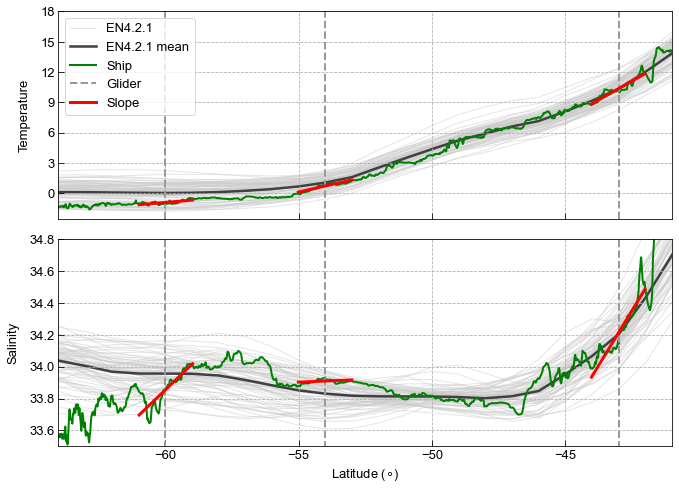

In [30]:
from sklearn.linear_model import LinearRegression
import gsw
from collections import OrderedDict

fig,ax=plt.subplots(2, figsize=[11, 8], sharex=True)
fig.subplots_adjust(hspace=0.1)

en4_props = dict(c='0.8', lw=1, alpha=0.5, zorder=1, label='EN4.2.1')
tsg_props = dict(c='green', zorder=2)

for t, val in enumerate(EN4.time):
    
    ax[0].plot(lat, t_en4[:,t], **en4_props)
    ax[1].plot(lat, s_en4[:,t], **en4_props)
    
ax[0].plot(lat, np.mean(t_en4, axis=1), c='0.25', zorder=1, lw=2.5, label='EN4.2.1 mean')
ax[1].plot(lat, np.mean(s_en4, axis=1), c='0.25', zorder=1, lw=2.5, label='EN4.2.1 mean')


ax[0].plot(tsg.Latitude, tsg.t_clean, **tsg_props, label='Ship')
ax[1].plot(tsg.Latitude, tsg.s_clean, **tsg_props, label='Ship')

for a in ax:
    a.set_xlim(-64, -41)
    a.grid(ls='--')
    a.plot([-43, -43], [-2.5, 36], c='0.6', ls='--', label='Glider')
    a.plot([-54, -54], [-2.5, 36], c='0.6', ls='--', label='Glider')
    a.plot([-60, -60], [-2.5, 36], c='0.6', ls='--', label='Glider')
    
ax[0].set_ylim(-2.5, 16)
ax[1].set_ylim(33.5, 34.8)

# linear regression to find the slope (gradient) for each glider location

for dat in [dat_saz_interp, dat_apz_interp, dat_miz_interp]:
    
    idx = ((tsg.Latitude > dat.lat.mean(dim='time').values-1) & (tsg.Latitude < dat.lat.mean(dim='time').values+1))

    X = tsg.Latitude.values[idx]
    T = tsg.t_clean.values[idx]
    S = tsg.s_clean.values[idx]
    
    i_good=~np.isnan(T) # find the good data
    X = X[i_good]; T = T[i_good]; S = S[i_good]
    
    i_good=~np.isnan(S) # find the good data
    X = X[i_good]; T = T[i_good]; S = S[i_good]
    
    X = X.reshape(-1, 1)
    T = T.reshape(-1, 1)
    S = S.reshape(-1, 1)
    
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(X, T)  # perform linear regression
    T_pred = linear_regressor.predict(X)  # make predictions
    
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(X, S)  # perform linear regression
    S_pred = linear_regressor.predict(X)  # make predictions
    
    ax[0].plot(X, T_pred, c='r', lw=3, label='Slope')
    ax[1].plot(X, S_pred, c='r', lw=3, label='Slope')
    
    dat['dT_grad'] = (T_pred[-1] - T_pred[0]) / gsw.distance([0, 0], [X[-1].squeeze(), X[0].squeeze()]) # temperature gradients in degC / m
    dat['dS_grad'] = (S_pred[-1] - S_pred[0]) / gsw.distance([0, 0], [X[-1].squeeze(), X[0].squeeze()]) # salinity gradients in psu / m
    
ax[0].set_ylabel('Temperature', labelpad=10)
ax[1].set_ylabel('Salinity', labelpad=10)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax[0].legend(by_label.values(), by_label.keys())

ax[0].yaxis.set_ticks(np.arange(0, 21, 3))
ax[1].set_xlabel('Latitude ($\circ$)')

plt.savefig('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/figures/fig3_gradients.png', dpi=300, bbox_inches='tight')

#### Calculate the ekman advection flux

In [31]:
for dat in [dat_saz_interp, dat_apz_interp, dat_miz_interp]:
    
    dat = ekman_advection(dat=dat, dt=dt)

### 3. Geostrophic velocity

In [72]:
adt = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/adt/*.nc')
adt = my.adjust_lon_xr_dataset(adt, lon_name='longitude')

/Users/marcel/opt/anaconda3/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/Users/marcel/opt/anaconda3/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/Users/marcel/

In [73]:
adt = adt.resample(time=interp_res, loffset=offset).mean()

In [74]:
adt = adt.sel(latitude=slice(-63, -41), longitude=slice(-2, 9))

In [75]:
var_name = ['ugos', 'vgos']   

for var in tqdm(var_name):
  
    dat_saz_interp[var] = (('time'), my.interp_glider_era5(dat_saz_interp, adt, var=var))
    dat_apz_interp[var] = (('time'), my.interp_glider_era5(dat_apz_interp, adt, var=var))
    dat_miz_interp[var] = (('time'), my.interp_glider_era5(dat_miz_interp, adt, var=var))

100%|██████████| 2/2 [00:27<00:00, 13.67s/it]


(-60.6, -59.1)

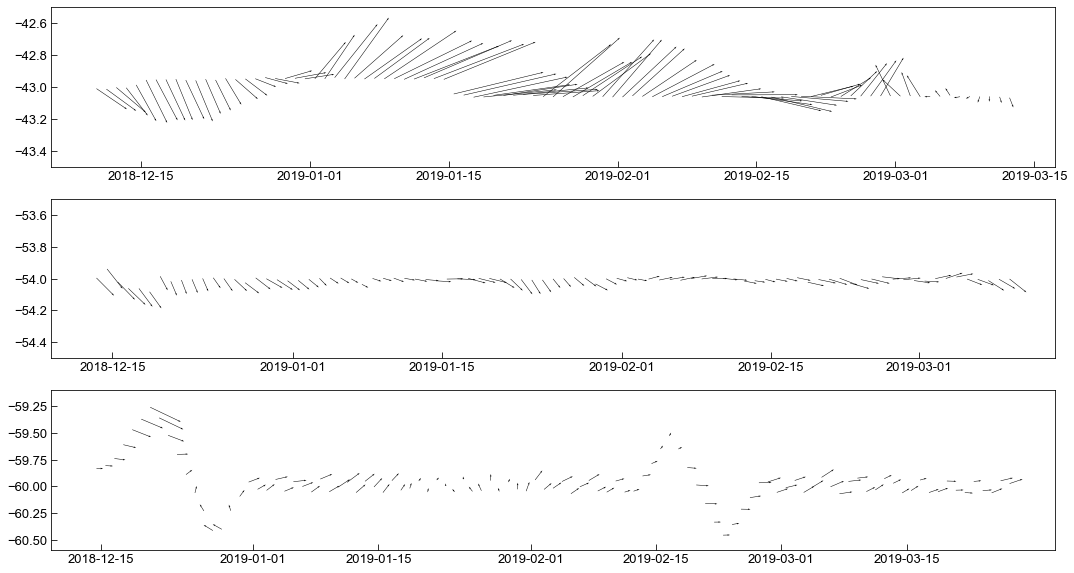

In [76]:
fig,ax=plt.subplots(3)

for i, dat in enumerate([dat_saz_interp, dat_apz_interp, dat_miz_interp]):
  
    ax[i].quiver(dat.time, dat.lat, dat.ugos, dat.vgos, scale=1.7, width=5e-4)

ax[0].set_ylim(-43.5, -42.5)
ax[1].set_ylim(-54.5, -53.5)
ax[2].set_ylim(-60.6, -59.1)

In [90]:
def geostrophic_advection(dat, dt):
  
    dT_geo_adv_y = dt*((dat.vgos)*dat['dT_grad'].values)
    dS_geo_adv_y = dt*((dat.vgos)*dat['dS_grad'].values)
  
    dat['dT_geo_adv'] = (('time'), dT_geo_adv_y)
    dat['dS_geo_adv'] = (('time'), dS_geo_adv_y)

    return dat

In [91]:
for dat in [dat_saz_interp, dat_apz_interp, dat_miz_interp]:
  
    dat['ugos'] = dat['ugos'].interpolate_na(dim='time')
    dat['vgos'] = dat['vgos'].interpolate_na(dim='time')
    dat = geostrophic_advection(dat=dat, dt=dt)

### 4. Entrainment

In [92]:
def entrainment(dat, mld, dt, dpt=15):
    
    d_mld=np.append(np.array(0), np.diff(mld.values)).astype(int)
    
    S15 = [dat.salt.values[i, val] for i, val in enumerate(mld.values.astype(int)+dpt)]
    T15 = [dat.temp.values[i, val] for i, val in enumerate(mld.values.astype(int)+dpt)]
    
#     S15 = [dat.salt.values[i, val] for i, val in enumerate(mld.values.astype(int)+d_mld[i])]
#     T15 = [dat.temp.values[i, val] for i, val in enumerate(mld.values.astype(int)+d_mld[i])]
    
    dat['s_'+str(dpt)] = (('time'),  np.array(S15))
    dat['t_'+str(dpt)] = (('time'),  np.array(T15))

    we = d_mld/dt
    we[we<0]=0

    ent_S = dt*(we*(S15 - dat.ml_s))/mld
    ent_T = dt*(we*(T15 - dat.ml_t))/mld
    
    dat['dS_ent_'+str(dpt)] = (('time'), ent_S)
    dat['dT_ent_'+str(dpt)] = (('time'), ent_T)
    dat['w_e']   = (('time'), we)
    
    return dat

In [93]:
for i, val in enumerate([5, 10, 15]):
    
    dat_saz_interp = entrainment(dat_saz_interp, mld=np.round(dat_saz_interp.mld_03), dpt=val, dt=dt)
    dat_apz_interp = entrainment(dat_apz_interp, mld=np.round(dat_apz_interp.mld_03), dpt=val, dt=dt)
    dat_miz_interp = entrainment(dat_miz_interp, mld=np.round(dat_miz_interp.mld_03), dpt=val, dt=dt)

### Mixed layer budget plot

In [94]:
for dat in [dat_saz_interp, dat_apz_interp, dat_miz_interp]:

    rho, alpha, beta = gsw.rho_alpha_beta(dat.ml_s, dat.ml_t, 0)
    dat['ml_d']      = rho
    dat['ml_b']      = -9.81*(rho-1027)/1027
    dat['ml_beta']   = beta
    dat['ml_alpha']  = alpha

#### Calculate buoyancy content change

In [95]:
ent_dpt=5
mld = 'mld_03'

In [96]:
variables = ['dS_ff', 'dS_ent_'+str(ent_dpt), 'dS_ek_adv', 'dS_geo_adv']

for dat in [dat_saz_interp, dat_apz_interp, dat_miz_interp]:
    
    for var in variables:

        d = 1025 + dat['ml_d'] * (dat[var] * dat['ml_beta']).cumsum()
        b = -9.81 * (d - 1025) / 1025 
        dat[var+'_b_change'] = dat[str(mld)] * np.diff(np.append(0, b)) / dt

In [97]:
variables = ['dT_hf', 'dT_ent_'+str(ent_dpt), 'dT_ek_adv', 'dT_geo_adv']

for dat in [dat_saz_interp, dat_apz_interp, dat_miz_interp]:
    
    for var in variables:

        d = 1025 + dat['ml_d'] * (dat[var] * dat['ml_alpha']).cumsum()
        b = 9.81 * (d - 1025) / 1025 
        dat[var+'_b_change'] = dat[str(mld)] * np.diff(np.append(0, b)) / dt

In [98]:
for dat in [dat_saz_interp, dat_apz_interp, dat_miz_interp]:

    d = 1025 + dat['ml_d'] * (np.diff(np.append(0, dat['ml_t'])) * dat['ml_alpha']).cumsum()
    b = 9.81 * (d - 1025) / 1025 
    dat['ml_t_b_change'] = dat[str(mld)] * np.diff(np.append(0, b)) / dt
    
    d = 1025 + dat['ml_d'] * (np.diff(np.append(0, dat['ml_s'])) * dat['ml_beta']).cumsum()
    b = -9.81 * (d - 1025) / 1025 
    dat['ml_s_b_change'] = dat[str(mld)] * np.diff(np.append(0, b)) / dt

In [99]:
print(dat_saz_interp['dS_ff_b_change'].mean().values)
print(dat_apz_interp['dS_ff_b_change'].mean().values)
print(dat_miz_interp['dS_ff_b_change'].mean().values)

1.027311635663259e-08
8.928720255417566e-09
7.859074101912493e-09


In [100]:
print(dat_saz_interp['dS_ek_adv_b_change'].mean().values)
print(dat_apz_interp['dS_ek_adv_b_change'].mean().values)
print(dat_miz_interp['dS_ek_adv_b_change'].mean().values)

1.59013044607824e-08
4.60407172546522e-10
2.705239609525085e-09


In [101]:
print(dat_saz_interp['dS_ent_'+str(ent_dpt)+'_b_change'].mean().values)
print(dat_apz_interp['dS_ent_'+str(ent_dpt)+'_b_change'].mean().values)
print(dat_miz_interp['dS_ent_'+str(ent_dpt)+'_b_change'].mean().values)

-1.489706129539599e-09
-3.339530975486658e-09
-1.12549897797127e-08


In [102]:
print(dat_saz_interp['dT_hf_b_change'].mean().values)
print(dat_apz_interp['dT_hf_b_change'].mean().values)
print(dat_miz_interp['dT_hf_b_change'].mean().values)

5.7062133495359245e-08
2.3376485614215634e-08
1.5577950961115225e-08


In [103]:
print(dat_saz_interp['dT_ek_adv_b_change'].mean().values)
print(dat_apz_interp['dT_ek_adv_b_change'].mean().values)
print(dat_miz_interp['dT_ek_adv_b_change'].mean().values)

-1.9145554592039374e-08
-3.403522885352992e-09
-2.785535106544573e-10


#### Terms figure

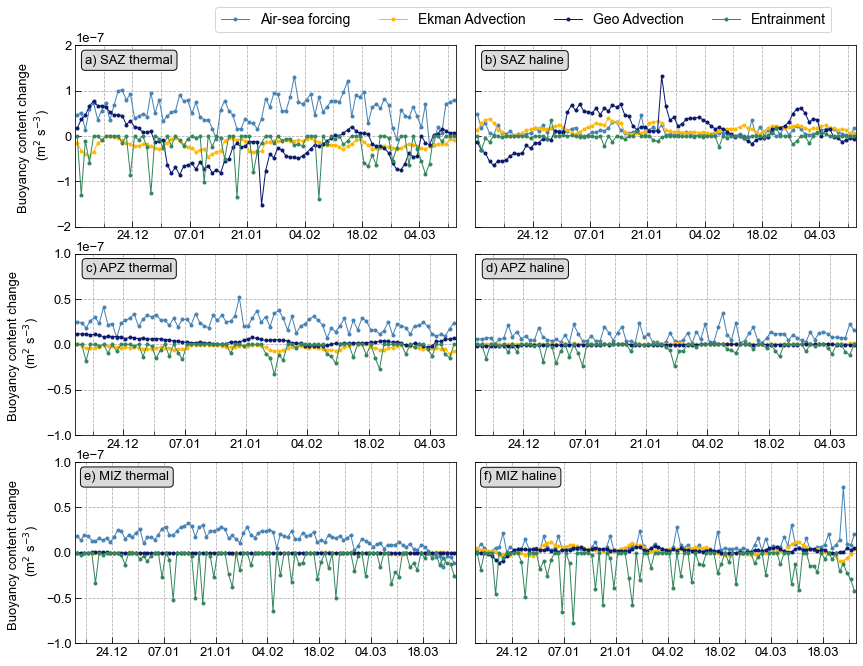

In [104]:
plt.rcParams['font.size'] = 13

fig, ax = plt.subplots(3, 2, figsize=[14, 11])
fig.subplots_adjust(wspace=0.05, hspace=0.15)

for i, dat in enumerate([dat_saz_interp, dat_apz_interp, dat_miz_interp]):
    
    T_bc_net = dat['dT_hf_b_change'] + dat['dT_ek_adv_b_change'] + dat['dT_ent_'+str(ent_dpt)+'_b_change']
    S_bc_net = dat['dS_ff_b_change'] + dat['dS_ek_adv_b_change'] + dat['dS_ent_'+str(ent_dpt)+'_b_change']
    
    
    ax[i,0].plot(dat.time, dat['dT_hf_b_change'],  marker='.', lw=1, c='steelblue', label='Air-sea forcing')
    ax[i,1].plot(dat.time, dat['dS_ff_b_change'],  marker='.', lw=1, c='steelblue', label='Air-sea forcing')

    ax[i,0].plot(dat.time, dat['dT_ek_adv_b_change'],  marker='.', lw=1, c=my_clrs[0],  label='Ekman Advection')
    ax[i,1].plot(dat.time, dat['dS_ek_adv_b_change'],  marker='.', lw=1, c=my_clrs[0],  label='Ekman Advection')
    
    ax[i,0].plot(dat.time, dat['dT_geo_adv_b_change'],  marker='.', lw=1, c=my_clrs[4],  label='Geo Advection')
    ax[i,1].plot(dat.time, dat['dS_geo_adv_b_change'],  marker='.', lw=1, c=my_clrs[4],  label='Geo Advection')
    
    ax[i,0].plot(dat.time, dat['dT_ent_'+str(ent_dpt)+'_b_change'],  marker='.', lw=1, c=my_clrs[3],  label='Entrainment')
    ax[i,1].plot(dat.time, dat['dS_ent_'+str(ent_dpt)+'_b_change'],  marker='.', lw=1, c=my_clrs[3],  label='Entrainment')

# figure modifying
for i, dat in enumerate([dat_saz_interp, dat_apz_interp, dat_miz_interp]):
  
    ax[i,0].set_ylabel('Buoyancy content change \n (m$^{2}$ s$^{-3}$)')
    ax[i,1].yaxis.set_ticklabels([])    
  
    for ii in range(2):
      
        ax[i,ii].xaxis.set_major_locator(weeks)
        ax[i,ii].xaxis.set_minor_locator(week)
        ax[i,ii].xaxis.set_major_formatter(yearsFmt)
      
        ax[i,ii].grid(ls='--', which='both')

        ax[0,ii].set_xlim('2018-12-10', '2019-03-13')
        ax[1,ii].set_xlim('2018-12-13', '2019-03-10')
        ax[2,ii].set_xlim('2018-12-14', '2019-03-27')
        
        ax[0,ii].set_ylim(-2e-7, 2e-7)
        ax[1,ii].set_ylim(-1e-7, 1e-7)
        ax[2,ii].set_ylim(-1e-7, 1e-7)

        
ax[0, 0].legend(loc=2, ncol=6, bbox_to_anchor=(0.35, 1.25), prop={'size': 14})

props = dict(boxstyle='round', facecolor='0.85', alpha=0.95)

ax[0,0].text(dat_saz_interp.time[2], 1.6e-7, 'a) SAZ thermal', bbox=props)
ax[0,1].text(dat_saz_interp.time[2], 1.6e-7, 'b) SAZ haline',  bbox=props)

ax[1,0].text(dat_apz_interp.time[2], 0.8e-7, 'c) APZ thermal', bbox=props)
ax[1,1].text(dat_apz_interp.time[2], 0.8e-7, 'd) APZ haline',  bbox=props)

ax[2,0].text(dat_miz_interp.time[2], 0.8e-7, 'e) MIZ thermal', bbox=props)
ax[2,1].text(dat_miz_interp.time[2], 0.8e-7, 'f) MIZ haline',  bbox=props)


plt.savefig('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/figures/fig7_tendency_budget.png', dpi=300, bbox_inches='tight')

#### Net terms figure

In [105]:
dat = dat_saz_interp

T_bc_net = (dat['dT_hf_b_change'] + dat['dT_ek_adv_b_change'] + dat['dT_ent_'+str(ent_dpt)+'_b_change'])[1:]
S_bc_net = (dat['dS_ff_b_change'] + dat['dS_ek_adv_b_change'] + dat['dS_ent_'+str(ent_dpt)+'_b_change'])[1:]

T_bc_gl = dat['ml_t_b_change'][1:]
S_bc_gl = dat['ml_s_b_change'][1:]

In [106]:
print(np.mean(T_bc_net[1:]).values)
print(np.mean(T_bc_gl).values)

1.8477161730109504e-08
-1.545124640843126e-09


In [107]:
print(np.std(T_bc_net).values)
print(np.std(T_bc_gl).values)

5.090147070067028e-08
6.738017399864511e-08


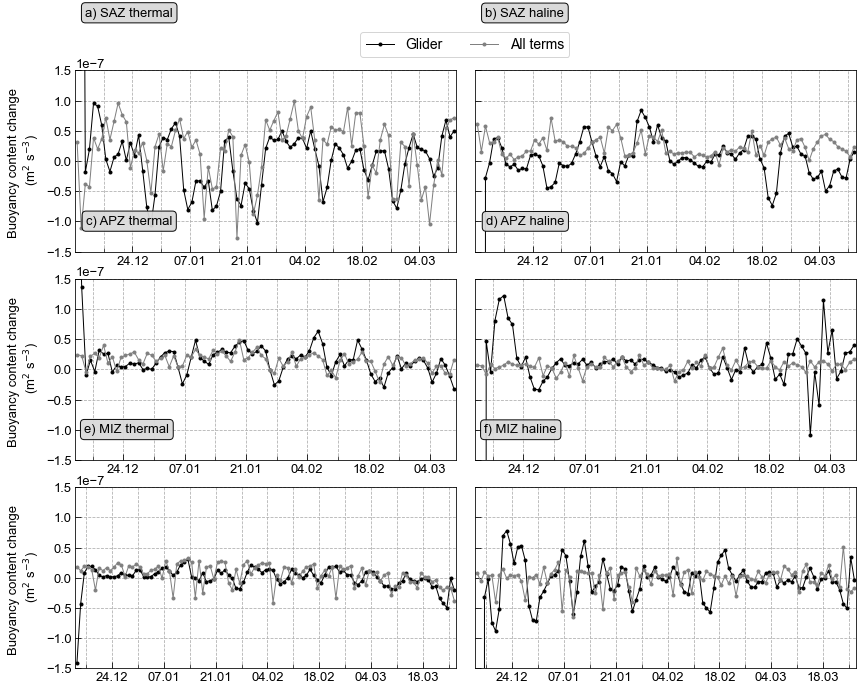

In [115]:
plt.rcParams['font.size'] = 13

fig, ax = plt.subplots(3, 2, figsize=[14, 11])
fig.subplots_adjust(wspace=0.05, hspace=0.15)

for i, dat in enumerate([dat_saz_interp, dat_apz_interp, dat_miz_interp]):
    
    T_bc_net = dat['dT_hf_b_change'] + dat['dT_ek_adv_b_change'] + dat['dT_ent_'+str(ent_dpt)+'_b_change']
    S_bc_net = dat['dS_ff_b_change'] + dat['dS_ek_adv_b_change'] + dat['dS_ent_'+str(ent_dpt)+'_b_change']
    
    ax[i,0].plot(dat.time, gt.cleaning.rolling_window(dat['ml_t_b_change'], func=np.mean, window=3),  marker='.', lw=1, c='k',   label='Glider')
    ax[i,1].plot(dat.time, gt.cleaning.rolling_window(dat['ml_s_b_change'], func=np.mean, window=3),  marker='.', lw=1, c='k',   label='Glider')
    
    ax[i,0].plot(dat.time, T_bc_net,              marker='.', lw=1, c='0.5', label='All terms',)
    ax[i,1].plot(dat.time, S_bc_net,              marker='.', lw=1, c='0.5', label='All terms',)
    
# figure modifying
for i, dat in enumerate([dat_saz_interp, dat_apz_interp, dat_miz_interp]):
  
    ax[i,0].set_ylabel('Buoyancy content change \n (m$^{2}$ s$^{-3}$)')
    ax[i,1].yaxis.set_ticklabels([])    

  
    for ii in range(2):
      
        ax[i,ii].xaxis.set_major_locator(weeks)
        ax[i,ii].xaxis.set_minor_locator(week)
        ax[i,ii].xaxis.set_major_formatter(yearsFmt)
      
        ax[i,ii].grid(ls='--', which='both')

        ax[0,ii].set_xlim('2018-12-10', '2019-03-13')
        ax[1,ii].set_xlim('2018-12-13', '2019-03-10')
        ax[2,ii].set_xlim('2018-12-14', '2019-03-27')
        
        ax[0,ii].set_ylim(-0.15e-6, 0.15e-6)
        ax[1,ii].set_ylim(-0.15e-6, 0.15e-6)
        ax[2,ii].set_ylim(-0.15e-6, 0.15e-6)
      

ax[0, 0].legend(loc=2, ncol=6, bbox_to_anchor=(0.73, 1.25), prop={'size': 14})

props = dict(boxstyle='round', facecolor='0.85', alpha=0.95)

ax[0,0].text(dat_saz_interp.time[2], 2.4e-7, 'a) SAZ thermal', bbox=props)
ax[0,1].text(dat_saz_interp.time[2], 2.4e-7, 'b) SAZ haline',  bbox=props)

ax[1,0].text(dat_apz_interp.time[2], 2.4e-7, 'c) APZ thermal', bbox=props)
ax[1,1].text(dat_apz_interp.time[2], 2.4e-7, 'd) APZ haline',  bbox=props)

ax[2,0].text(dat_miz_interp.time[2], 2.4e-7, 'e) MIZ thermal', bbox=props)
ax[2,1].text(dat_miz_interp.time[2], 2.4e-7, 'f) MIZ haline',  bbox=props)



plt.savefig('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/figures/fig8_terms_obs.png', dpi=300, bbox_inches='tight')

#### Plot the combination of the two terms together to show the cumulative impact of the buoyancy content changes

/Users/marcel/opt/anaconda3/lib/python3.8/site-packages/glidertools/helpers.py:70: GliderToolsWarning: Primary input variable is not xr.DataArray data type - no metadata to pass on.
  warnings.warn(msg, category=GliderToolsWarning)
/Users/marcel/opt/anaconda3/lib/python3.8/site-packages/glidertools/helpers.py:70: GliderToolsWarning: Primary input variable is not xr.DataArray data type - no metadata to pass on.
  warnings.warn(msg, category=GliderToolsWarning)
/Users/marcel/opt/anaconda3/lib/python3.8/site-packages/glidertools/helpers.py:70: GliderToolsWarning: Primary input variable is not xr.DataArray data type - no metadata to pass on.
  warnings.warn(msg, category=GliderToolsWarning)
/Users/marcel/opt/anaconda3/lib/python3.8/site-packages/glidertools/helpers.py:70: GliderToolsWarning: Primary input variable is not xr.DataArray data type - no metadata to pass on.
  warnings.warn(msg, category=GliderToolsWarning)
/Users/marcel/opt/anaconda3/lib/python3.8/site-packages/glidertools/help

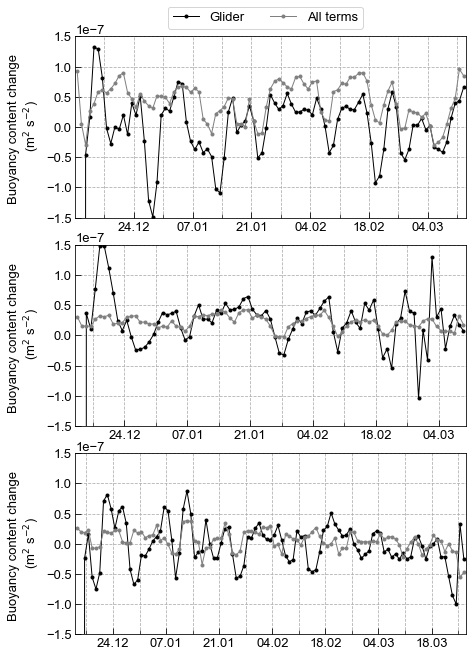

In [132]:
plt.rcParams['font.size'] = 13

fig, ax = plt.subplots(3, 1, figsize=[7, 11])
fig.subplots_adjust(hspace=0.15)

for i, dat in enumerate([dat_saz_interp, dat_apz_interp, dat_miz_interp]):
    
    T_bc_net = dat['dT_hf_b_change'] + dat['dT_ek_adv_b_change']  + dat['dT_ent_'+str(ent_dpt)+'_b_change']
    S_bc_net = dat['dS_ff_b_change'] + dat['dS_ek_adv_b_change']  + dat['dS_ent_'+str(ent_dpt)+'_b_change']
    
    gl_bc_net = dat['ml_t_b_change']+dat['ml_s_b_change']
    
#     ax[i].plot(dat.time, gl_bc_net.cumsum()-gl_bc_net.cumsum()[0],  marker='.', lw=1, c='k',   label='Glider')
#     ax[i].plot(dat.time, (T_bc_net+S_bc_net).cumsum(),              marker='.', lw=1, c='0.5', label='All terms')

#     ax[i].plot(dat.time, gl_bc_net,         marker='.', lw=1, c='k',   label='Glider')
    ax[i].plot(dat.time, gt.cleaning.rolling_window(gl_bc_net.values,  func=np.mean, window=3), marker='.', lw=1, c='k',   label='Glider')
    ax[i].plot(dat.time, gt.cleaning.rolling_window((T_bc_net+S_bc_net).values, func=np.mean, window=3), marker='.', lw=1, c='0.5', label='All terms')
    
# figure modifying
for i, dat in enumerate([dat_saz_interp, dat_apz_interp, dat_miz_interp]):
  
    ax[i].set_ylabel('Buoyancy content change \n (m$^{2}$ s$^{-2}$)')
      
    ax[i].xaxis.set_major_locator(weeks)
    ax[i].xaxis.set_minor_locator(week)
    ax[i].xaxis.set_major_formatter(yearsFmt)
    
    ax[i].grid(ls='--', which='both')

ax[0].set_xlim('2018-12-10', '2019-03-13')
ax[1].set_xlim('2018-12-13', '2019-03-10')
ax[2].set_xlim('2018-12-14', '2019-03-27')
    
ax[0].set_ylim(-0.15e-6, 0.15e-6)
ax[1].set_ylim(-0.15e-6, 0.15e-6)
ax[2].set_ylim(-0.15e-6, 0.15e-6)
    

ax[0].legend(loc=2, ncol=6, bbox_to_anchor=(0.22, 1.2), prop={'size': 13})

props = dict(boxstyle='round', facecolor='0.85', alpha=0.95)

# ax[0].text(dat_saz_interp.time[2], 2.4e-7, 'a) SAZ', bbox=props)
# ax[1].text(dat_apz_interp.time[2], 2.4e-7, 'b) APZ', bbox=props)
# ax[2].text(dat_miz_interp.time[2], 2.4e-7, 'c) MIZ', bbox=props)



plt.savefig('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/figures/fig9_net_tendency.png', dpi=300, bbox_inches='tight')

In [130]:
dat = dat_apz_interp

T_bc_net = dat['dT_hf_b_change'] + dat['dT_ek_adv_b_change']  + dat['dT_ent_'+str(ent_dpt)+'_b_change']
S_bc_net = dat['dS_ff_b_change'] + dat['dS_ek_adv_b_change']  + dat['dS_ent_'+str(ent_dpt)+'_b_change']

gl_bc_net = dat['ml_t_b_change']+dat['ml_s_b_change'] 
    
y=gt.cleaning.rolling_window(gl_bc_net.values,           func=np.mean, window=3)
x=gt.cleaning.rolling_window((T_bc_net+S_bc_net).values, func=np.mean, window=3)

(-1.5e-07, 1.5e-07)

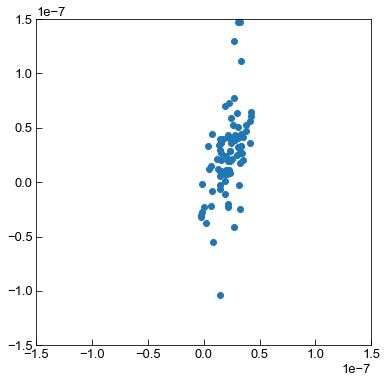

In [131]:
fig,ax=plt.subplots(figsize=[6,6])
ax.scatter(x,y)
ax.set_xlim(-1.5e-7, 1.5e-7)
ax.set_ylim(-1.5e-7, 1.5e-7)

In [127]:
np.corrcoef(x,y)

array([[ 1.        , -0.14602424],
       [-0.14602424,  1.        ]])

In [92]:
den_ranges = np.arange(1026, 1027.4, 0.05)

for i, dat in enumerate([dat_saz_interp, dat_apz_interp, dat_miz_interp]):
    
    bc_change_fl = dat['dT_hf_b_change']+dat['dS_ff_b_change']
    bc_change_ek = dat['dT_ek_adv_b_change']+dat['dS_ek_adv_b_change']
    bc_change_en = dat['dT_ent_'+str(ent_dpt)+'_b_change']+dat['dS_ent_'+str(ent_dpt)+'_b_change']

    b_ent_sum_en = []
    b_ent_sum_ek = []
    b_ent_sum_fl = []
    
    for d in den_ranges:
        
        idx = ((dat['ml_d']>d) & (dat['ml_d']<d+0.05))
        b_ent_sum_en += np.nansum(bc_change_en[idx]),
        b_ent_sum_ek += np.nansum(bc_change_ek[idx]),
        b_ent_sum_fl += np.nansum(bc_change_fl[idx]),
    
    if i==0:
        bsum_en_saz = b_ent_sum_en
        bsum_ek_saz = b_ent_sum_ek
        bsum_fl_saz = b_ent_sum_fl
        
    if i==1:
        bsum_en_apz = b_ent_sum_en
        bsum_ek_apz = b_ent_sum_ek
        bsum_fl_apz = b_ent_sum_fl
        
    if i==2:
        bsum_en_miz = b_ent_sum_en
        bsum_ek_miz = b_ent_sum_ek
        bsum_fl_miz = b_ent_sum_fl

In [100]:
d

1027.3999999999987

<BarContainer object of 29 artists>

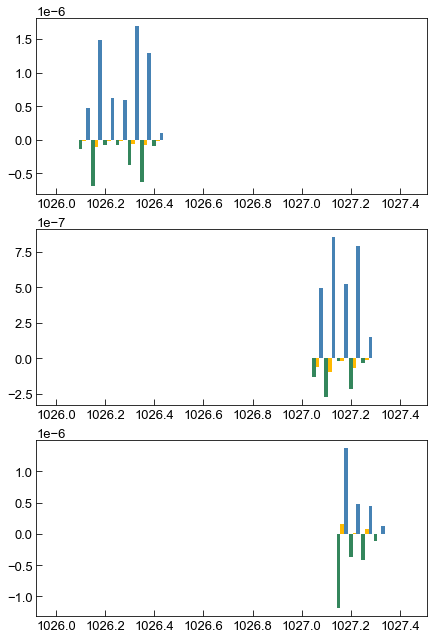

In [109]:
fig,ax=plt.subplots(3, figsize=[7, 11])

ax[0].bar(den_ranges+0.000, bsum_en_saz, width=0.015, facecolor=my_clrs[3])
ax[0].bar(den_ranges+0.015, bsum_ek_saz, width=0.015, facecolor=my_clrs[0])
ax[0].bar(den_ranges+0.030, bsum_fl_saz, width=0.015, facecolor='steelblue')

ax[1].bar(den_ranges+0.000, bsum_en_apz, width=0.015, facecolor=my_clrs[3])
ax[1].bar(den_ranges+0.015, bsum_ek_apz, width=0.015, facecolor=my_clrs[0])
ax[1].bar(den_ranges+0.030, bsum_fl_apz, width=0.015, facecolor='steelblue')

ax[2].bar(den_ranges+0.000, bsum_en_miz, width=0.015, facecolor=my_clrs[3])
ax[2].bar(den_ranges+0.015, bsum_ek_miz, width=0.015, facecolor=my_clrs[0])
ax[2].bar(den_ranges+0.030, bsum_fl_miz, width=0.015, facecolor='steelblue')


In [75]:
dat['ml_d'].min()

<xarray.DataArray 'ml_d' ()>
array(1027.15744682)

#### Sarah Figure

In [ ]:
fig = plt.figure(figsize=[11, 7])

dat = dat_apz_interp

plt.subplot(2,1,1)

x1= dat['dT_ent_5'].cumsum()
x2= dat['dT_hf'].cumsum()
# x3= dat['dT_geo_adv'].cumsum()
x4= dat['dT_ek_adv'].cumsum()

plt.plot(dat.time, 0.5+x1      , label='Entrainment',           c=my_clrs[0], lw=1)
plt.plot(dat.time, 0.5+x2      , label='Heat flux (Q)',         c=my_clrs[2], lw=1)
plt.plot(dat.time, 0.5+x4      , label='Ekman advection',       c=my_clrs[3], lw=1)
plt.plot(dat.time, 0.5+x1+x2+x4, label='All terms',             c=my_clrs[1], lw=3)
plt.plot(dat.time, dat['ml_t']   , label='Glider',                c='k',        lw=3)

plt.legend(loc=2, ncol=3, prop={'size': 13})

plt.xlim('2018-12-14', '2019-02-11')

plt.yticks([-1, 0, 1, 2, 3])
plt.ylabel('Temperature ($^{\circ}$C)', labelpad=15)


plt.subplot(2,1,2)

x1= dat['dS_ent_5'].cumsum()
x2= dat['dS_ff'].cumsum()
# x3= dat['dS_geo_adv'].cumsum()
x4= dat['dS_ek_adv'].cumsum()


plt.plot(dat.time, 34.1+x1      , label='Entrainment',           c=my_clrs[0], lw=1)
plt.plot(dat.time, 34.1+x2      , label='Freshwater flux (E-P)', c=my_clrs[2], lw=1)
plt.plot(dat.time, 34.1+x4      , label='Ekman advection',       c=my_clrs[3], lw=1)
plt.plot(dat.time, 34.1+x1+x2+x4, label='All terms',             c=my_clrs[1], lw=3)
plt.plot(dat.time, dat['ml_s']   , label='Glider',               c='k',        lw=3)

plt.legend(loc=2, ncol=3, prop={'size': 13})

plt.xlim('2018-12-14', '2019-02-11')

plt.yticks([34, 34.05, 34.1, 34.15, 34.2])
plt.ylabel('Salinity (g/kg)', labelpad=18)

fig.tight_layout()

plt.savefig('/Users/marcel/Desktop/sarah_fig.png', dpi=300)

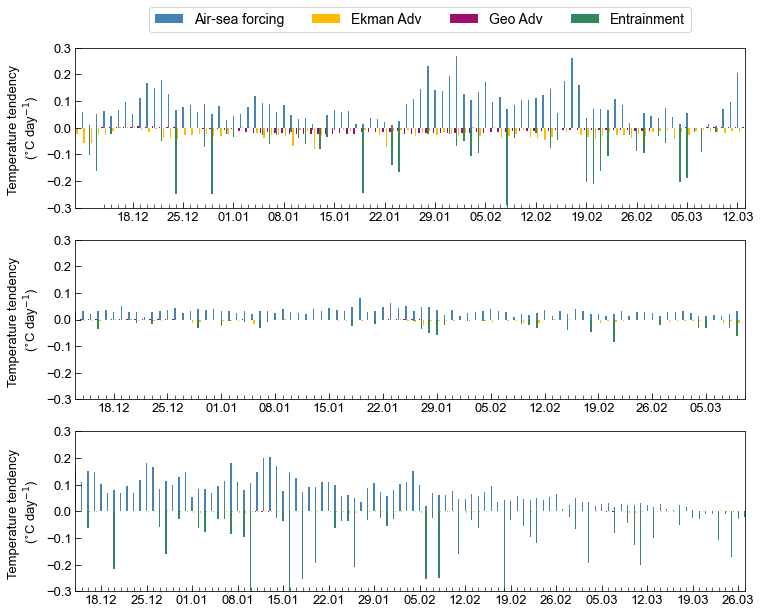

In [41]:
plt.rcParams['font.size'] = 13

fig, ax = plt.subplots(3, 1, figsize=[12, 10])
fig.subplots_adjust(hspace=0.2)

ranges = ([-0.07, 0.07], [-0.04, 0.04], [-0.06, 0.06])

for i, dat in enumerate([dat_saz_interp, dat_apz_interp, dat_miz_interp]):
    
    ax[i].bar(dat.time-np.timedelta64(12, 'h'), dat['dT_hf'],      width=0.2, facecolor='steelblue', label='Air-sea forcing')  
    ax[i].bar(dat.time-np.timedelta64(6, 'h'),  dat['dT_ek_adv'],  width=0.2, facecolor=my_clrs[0],  label='Ekman Adv')
    ax[i].bar(dat.time+np.timedelta64(6,'h'),   dat['dT_geo_adv'], width=0.2, facecolor=my_clrs[2],  label='Geo Adv')
    ax[i].bar(dat.time+np.timedelta64(12,'h'),  dat['dT_ent_10'],  width=0.2, facecolor=my_clrs[3],  label='Entrainment')
    

days = mdates.DayLocator(interval=1)  # every month
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator(interval=1)  # every month
weeks = mdates.WeekdayLocator(interval=1)
dateFmt = mdates.DateFormatter("%d.%m")

# figure modifying
for i, dat in enumerate([dat_saz_interp, dat_apz_interp, dat_miz_interp]):

    ax[i].set_ylabel('Temperature tendency \n($^{\circ}$C day$^{-1}$)')
    
    ax[i].xaxis.set_major_locator(weeks)
    ax[i].xaxis.set_major_formatter(dateFmt)
    ax[i].xaxis.set_minor_locator(days)
    
#     ax[i].grid(ls='--', which='major', zorder=0, lw=1)
    
    ax[i].set_ylim(-0.3, 0.3)  
    
ax[0].set_xlim('2018-12-10', '2019-03-13')
ax[1].set_xlim('2018-12-13', '2019-03-10')
ax[2].set_xlim('2018-12-14', '2019-03-27')     

ax[0].legend(loc=2, ncol=6, bbox_to_anchor=(0.1, 1.3), prop={'size': 14})

    
plt.savefig('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/figures/fig6_tendency_budget_temp.png', dpi=300, bbox_inches='tight')

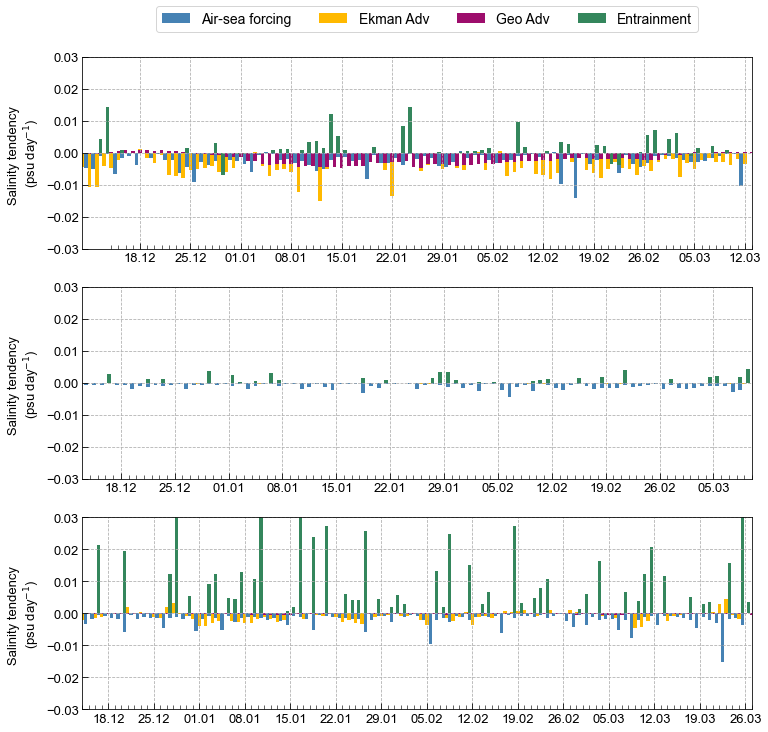

In [38]:
plt.rcParams['font.size'] = 13

fig, ax = plt.subplots(3, 1, figsize=[12, 12])
fig.subplots_adjust(hspace=0.2)

for i, dat in enumerate([dat_saz_interp, dat_apz_interp, dat_miz_interp]):
    
    ax[i].bar(dat.time-np.timedelta64(24, 'h'), dat['dS_ff'],      width=0.5, facecolor='steelblue', label='Air-sea forcing')  
    ax[i].bar(dat.time-np.timedelta64(12,  'h'), dat['dS_ek_adv'],  width=0.5, facecolor=my_clrs[0],  label='Ekman Adv')
    ax[i].bar(dat.time+np.timedelta64(12,  'h'), dat['dS_geo_adv'], width=0.5, facecolor=my_clrs[2],  label='Geo Adv')
    ax[i].bar(dat.time+np.timedelta64(24, 'h'), dat['dS_ent_10'],  width=0.5, facecolor=my_clrs[3],  label='Entrainment')
    

days = mdates.DayLocator(interval=1)  # every month
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator(interval=1)  # every month
weeks = mdates.WeekdayLocator(interval=1)
dateFmt = mdates.DateFormatter("%d.%m")

# figure modifying
for i, dat in enumerate([dat_saz_interp, dat_apz_interp, dat_miz_interp]):

    ax[i].set_ylabel('Salinity tendency \n(psu day$^{-1}$)')
    
    ax[i].xaxis.set_major_locator(weeks)
    ax[i].xaxis.set_major_formatter(dateFmt)
    ax[i].xaxis.set_minor_locator(days)
    
    ax[i].grid(ls='--', which='major')
    
    ax[i].set_ylim(-0.03, 0.03)  
    
ax[0].set_xlim('2018-12-10', '2019-03-13')
ax[1].set_xlim('2018-12-13', '2019-03-10')
ax[2].set_xlim('2018-12-14', '2019-03-27')     

ax[0].legend(loc=2, ncol=6, bbox_to_anchor=(0.1, 1.3), prop={'size': 14})

    
plt.savefig('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/figures/fig6_tendency_budget_salt.png', dpi=300, bbox_inches='tight')

In [39]:
for dat in [dat_saz_interp, dat_apz_interp, dat_miz_interp]:
    
    dat['t_terms'] = dat['dT_hf']+dat['dT_ek_adv']+dat['dT_geo_adv']+dat['dT_ent_10']
    dat['s_terms'] = dat['dS_ff']+dat['dS_ek_adv']+dat['dS_geo_adv']+dat['dS_ent_10']    

### Plot all terms with the observations

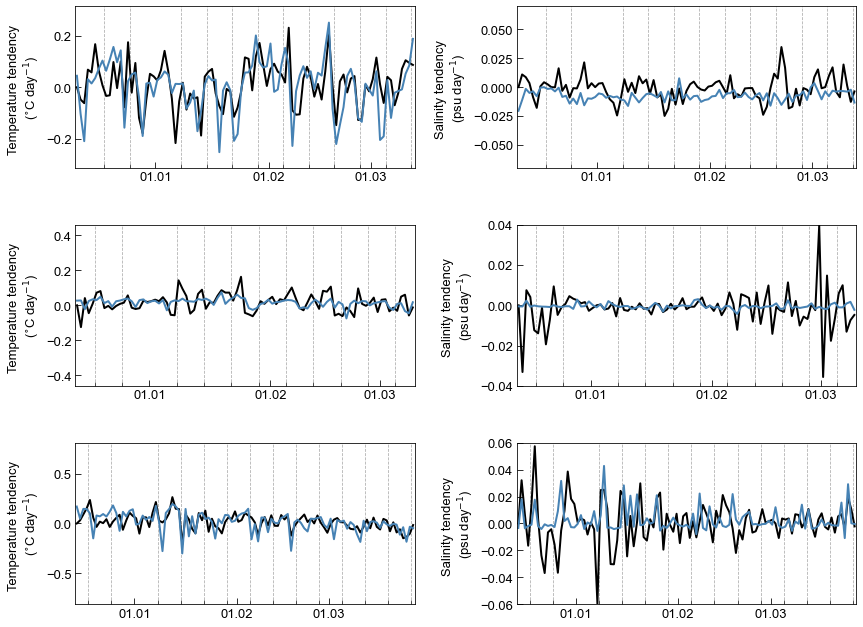

In [237]:
plt.rcParams['font.size'] = 13

fig, ax = plt.subplots(3, 2, figsize=[14, 11])
fig.subplots_adjust(wspace=0.3, hspace=0.35)

ranges = ([-0.07, 0.07], [-0.04, 0.04], [-0.06, 0.06])

for i, dat in enumerate([dat_saz_interp, dat_apz_interp, dat_miz_interp]):
    
    ax[i,0].plot(dat.time, np.append(0, dat['ml_t'].diff(dim='time')), c='k', label='Glider')
    ax[i,1].plot(dat.time, np.append(0, dat['ml_s'].diff(dim='time')), c='k', label='Glider')
    
    ax[i,0].plot(dat.time, dat['t_terms'], c='steelblue', label='All terms')
    ax[i,1].plot(dat.time, dat['s_terms'], c='steelblue', label='All terms')
    

# figure modifying
for i, dat in enumerate([dat_saz_interp, dat_apz_interp, dat_miz_interp]):
  
    ax[i,0].set_ylabel('Temperature tendency \n($^{\circ}$C day$^{-1}$)')
    ax[i,1].set_ylabel('Salinity tendency \n(psu day$^{-1}$)')
    
    srange = ranges[i]
    trange = ((srange[1]-srange[0]) * gsw.beta(dat.ml_s.mean(), dat.ml_t.mean(), 0)) / gsw.alpha(dat.ml_s.mean(), dat.ml_t.mean(), 0)
    trange = [0-trange/2, 0+trange/2]
  
    for ii in range(2):
      
        ax[i,ii].xaxis.set_major_locator(months)
        ax[i,ii].xaxis.set_major_formatter(yearsFmt)
        ax[i,ii].xaxis.set_minor_locator(weeks)
      
        ax[i,ii].grid(ls='--', which='minor')

        ax[0,ii].set_xlim('2018-12-10', '2019-03-13')
        ax[1,ii].set_xlim('2018-12-13', '2019-03-10')
        ax[2,ii].set_xlim('2018-12-14', '2019-03-27')
        
        ax[i,0].set_ylim(trange)   
        ax[i,1].set_ylim(srange)   


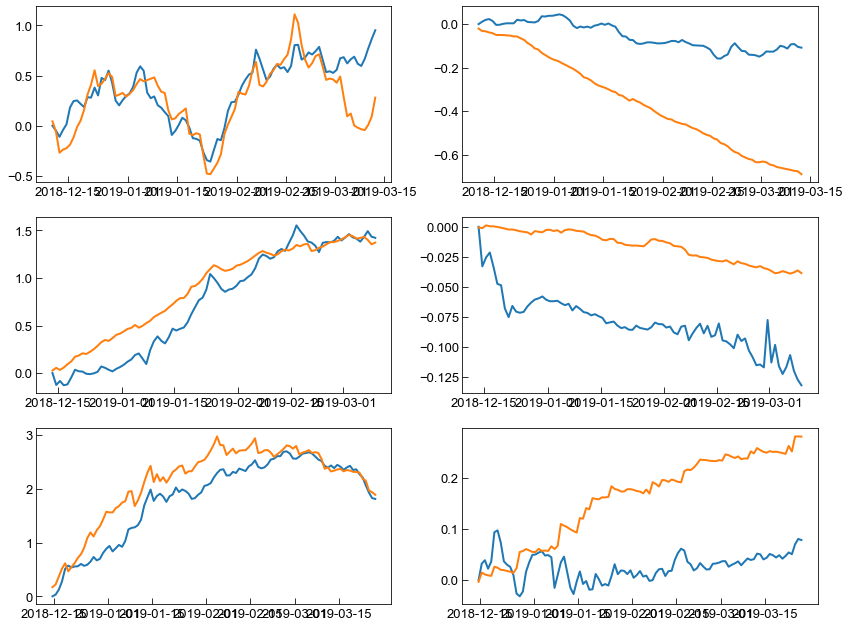

In [238]:
fig, ax = plt.subplots(3, 2, figsize=[14, 11])

for i, dat in enumerate([dat_saz_interp, dat_apz_interp, dat_miz_interp]):

    ax[i,0].plot(dat.time, np.append(0, dat['ml_t'].diff(dim='time')).cumsum())
    ax[i,0].plot(dat.time, dat['t_terms'].cumsum())
    
    ax[i,1].plot(dat.time, np.append(0, dat['ml_s'].diff(dim='time')).cumsum())
    ax[i,1].plot(dat.time, dat['s_terms'].cumsum())

### Horizontal eddy diffusion

In [452]:
kh = xr.open_dataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/eddy_diffusivity/ArgoTS_eddydiffusivity_20052015_3deg.nc')

In [470]:
dat = dat_saz

d = gsw.distance(dat.lon.values, dat.lat.values)

(array([ 82., 126., 137.,  87.,  38.,   8.,   0.,   2.,   0.,   1.]),
 array([  38.71704531,  540.34967142, 1041.98229754, 1543.61492366,
        2045.24754977, 2546.88017589, 3048.51280201, 3550.14542812,
        4051.77805424, 4553.41068035, 5055.04330647]),
 <BarContainer object of 10 artists>)

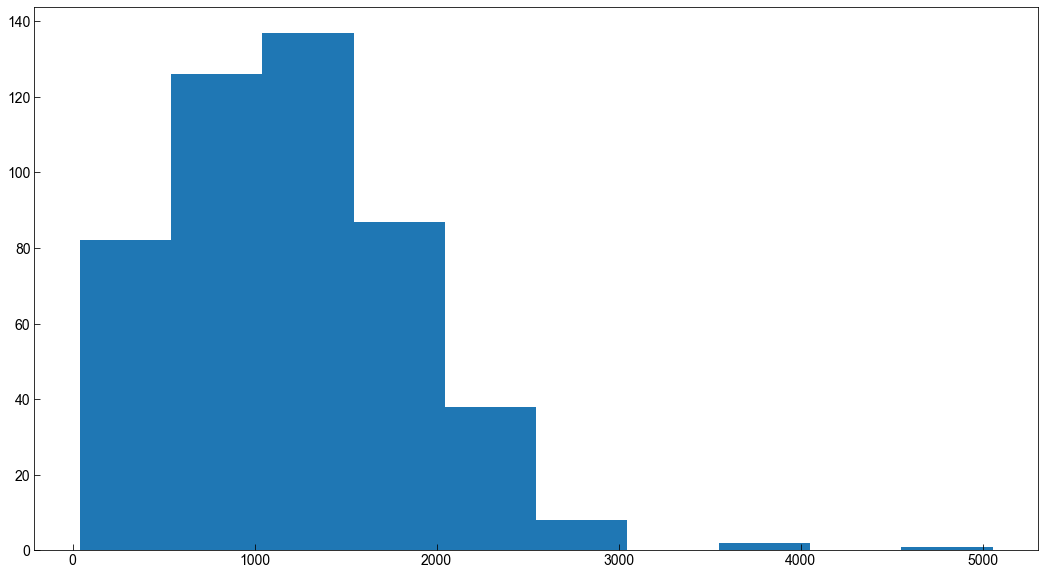

In [473]:
plt.hist(d)

In [ ]:
def horizontal_eddy_diffusivity(var, ed_coeff):
    """
    
    Calculate the horizontal eddy diffusivity based on the double derivative of the spatial gradient in the mixed layer property.
    
    var: the variable to 
    
    
    """
    
    

<ipython-input-464-e81bad546586>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(kh.longitude, kh.latitude, kh0.diffusivity)


(-65.0, -30.0)

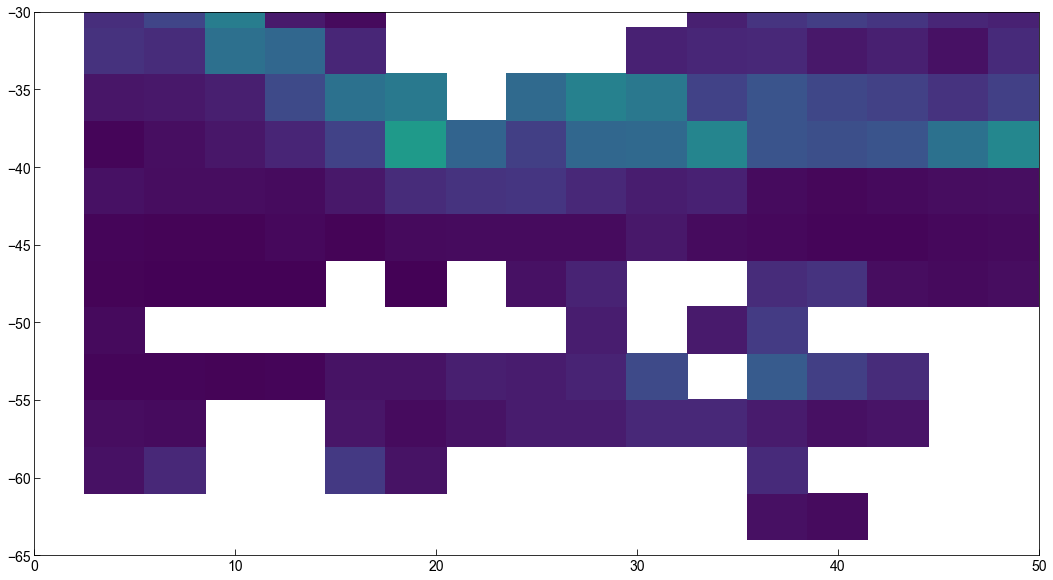

In [464]:
kh0 = kh.isel(depth=5)

plt.pcolormesh(kh.longitude, kh.latitude, kh0.diffusivity)
plt.xlim(0, 50)
plt.ylim(-65, -30)

In [426]:
kh0

<xarray.DataArray 'longitude' (lon: 120)>
array([  2.5,   5.5,   8.5,  11.5,  14.5,  17.5,  20.5,  23.5,  26.5,  29.5,
        32.5,  35.5,  38.5,  41.5,  44.5,  47.5,  50.5,  53.5,  56.5,  59.5,
        62.5,  65.5,  68.5,  71.5,  74.5,  77.5,  80.5,  83.5,  86.5,  89.5,
        92.5,  95.5,  98.5, 101.5, 104.5, 107.5, 110.5, 113.5, 116.5, 119.5,
       122.5, 125.5, 128.5, 131.5, 134.5, 137.5, 140.5, 143.5, 146.5, 149.5,
       152.5, 155.5, 158.5, 161.5, 164.5, 167.5, 170.5, 173.5, 176.5, 179.5,
       182.5, 185.5, 188.5, 191.5, 194.5, 197.5, 200.5, 203.5, 206.5, 209.5,
       212.5, 215.5, 218.5, 221.5, 224.5, 227.5, 230.5, 233.5, 236.5, 239.5,
       242.5, 245.5, 248.5, 251.5, 254.5, 257.5, 260.5, 263.5, 266.5, 269.5,
       272.5, 275.5, 278.5, 281.5, 284.5, 287.5, 290.5, 293.5, 296.5, 299.5,
       302.5, 305.5, 308.5, 311.5, 314.5, 317.5, 320.5, 323.5, 326.5, 329.5,
       332.5, 335.5, 338.5, 341.5, 344.5, 347.5, 350.5, 353.5, 356.5, 359.5])
Dimensions without coordinates: lon
Attributes:
    units:    degrees east

In [425]:
kh.latitude

<xarray.DataArray 'latitude' (lat: 43)>
array([-64., -61., -58., -55., -52., -49., -46., -43., -40., -37., -34., -31.,
       -28., -25., -22., -19., -16., -13., -10.,  -7.,  -4.,  -1.,   2.,   5.,
         8.,  11.,  14.,  17.,  20.,  23.,  26.,  29.,  32.,  35.,  38.,  41.,
        44.,  47.,  50.,  53.,  56.,  59.,  62.])
Dimensions without coordinates: lat
Attributes:
    units:    degrees north

array([7])

In [459]:
kh_saz = kh.sel(depth=100, lon=kh.lon[kh.longitude==8.5].values, lat=kh.lat[kh.latitude==-43].values)
kh_apz = kh.sel(depth=100, lon=kh.lon[kh.longitude==2.5].values, lat=kh.lat[kh.latitude==-55].values)
kh_miz = kh.sel(depth=100, lon=kh.lon[kh.longitude==2.5].values, lat=kh.lat[kh.latitude==-61].values)

In [461]:
kh_apz.diffusivity.values

array([[652.38581001]])

In [462]:
kh_miz.diffusivity.values

array([[2156.23944486]])

In [463]:
kh_saz.diffusivity.values

array([[1563.70080299]])

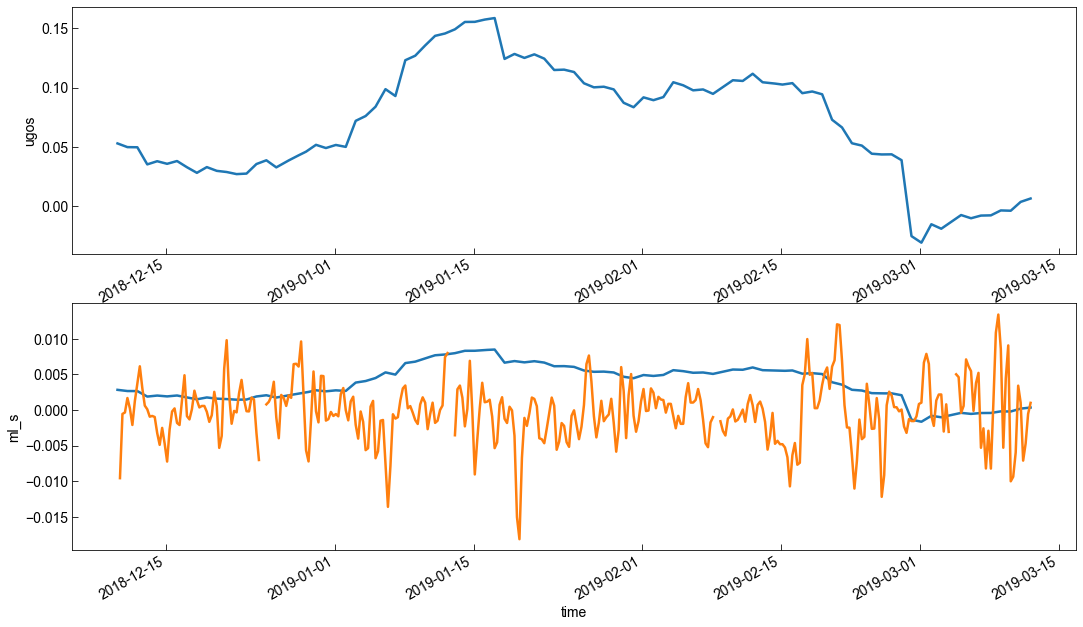

In [396]:
dat = dat_saz_6H
fig, ax = plt.subplots(2)
dat.ugos.plot(ax=ax[0])
dat.dS_geo_adv.plot(ax=ax[1])
dat.ml_s.diff(dim='time').plot(ax=ax[1])

### Quantifying glider movement in the TS variability

Gliders move horizontally in the water column by nature of their design. This means when comparing their profile to profile properties, one must consider the horizontal variability of those properties imposed on the time series. 

Of course, it is not possible to know with full accuracy how much that variability is when you're trying to observe the ocean (we need to quantify this in a future study). 

What we will do in this work is try to provide some measure of what the variability of T and S are based on how much the gliders moved north or south. We get values for how variable the ocean is in space from the thermosalinigraph that is installed on the SA Agulhas vessel, which was running during the glider deployments.

#### Calculate the distance from the mean position of the glider

In [18]:
import gsw 

d_lat_saz = gsw.distance(np.zeros(len(dat_saz.time)), dat_saz.sel(depth=0).lat.values)/1000
d_lat_apz = gsw.distance(np.zeros(len(dat_apz.time)), dat_apz.sel(depth=0).lat.values)/1000
d_lat_miz = gsw.distance(np.zeros(len(dat_miz.time)), dat_miz.sel(depth=0).lat.values)/1000

In [20]:
d_saz = [gsw.distance([0, 0], [-43, val]) for i, val in enumerate(dat_saz.sel(depth=0).lat)]
d_apz = [gsw.distance([0, 0], [-54, val]) for i, val in enumerate(dat_apz.sel(depth=0).lat)]
d_miz = [gsw.distance([0, 0], [-60, val]) for i, val in enumerate(dat_miz.sel(depth=0).lat)]

d_saz = np.array(d_saz)
d_apz = np.array(d_apz)
d_miz = np.array(d_miz)

d_saz[dat_saz.lat<-43] = -d_saz[dat_saz.lat<-43]
d_apz[dat_apz.lat<-54] = -d_apz[dat_apz.lat<-54]
d_miz[dat_miz.lat<-60] = -d_miz[dat_miz.lat<-60]

#### Cumulative sum of the distance travelled by the gliders

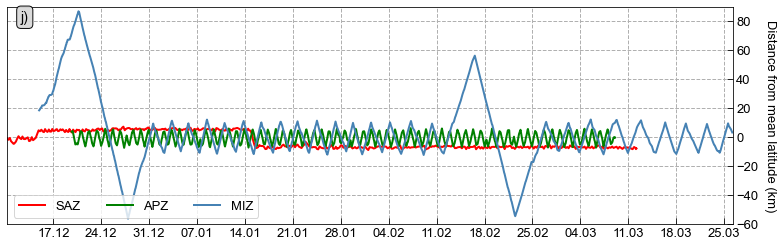

In [23]:
fig, ax = subplots(figsize=(13, 4))

ax.plot(dat_saz.time, d_saz/1000, c='red', label='SAZ')
ax.plot(dat_apz.time, d_apz/1000, c='green', label='APZ')
ax.plot(dat_miz.time, d_miz/1000, c='steelblue', label='MIZ')

ax.legend(ncol=3, loc=3)

ax.set_ylabel('Distance from mean latitude (km)', rotation=-90, labelpad=18)

ax.xaxis.set_major_locator(weeks)
ax.xaxis.set_major_formatter(yearsFmt)

ax.set_ylim(-60, 90)
ax.grid(lw=1, ls='--')
ax.set_xlim(dat_saz_12H.time[0].values, dat_miz_12H.time[-1].values)

ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

props = dict(boxstyle='round', facecolor='0.85', alpha=0.95)

ax.text(dat_saz_12H.time[4].values, 78, 'j)', fontsize=14, verticalalignment='bottom', bbox=props)

savefig('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/figures/fig4_gl_dist.png', dpi=300, bbox_inches='tight')

In [12]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/marcel/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['var']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


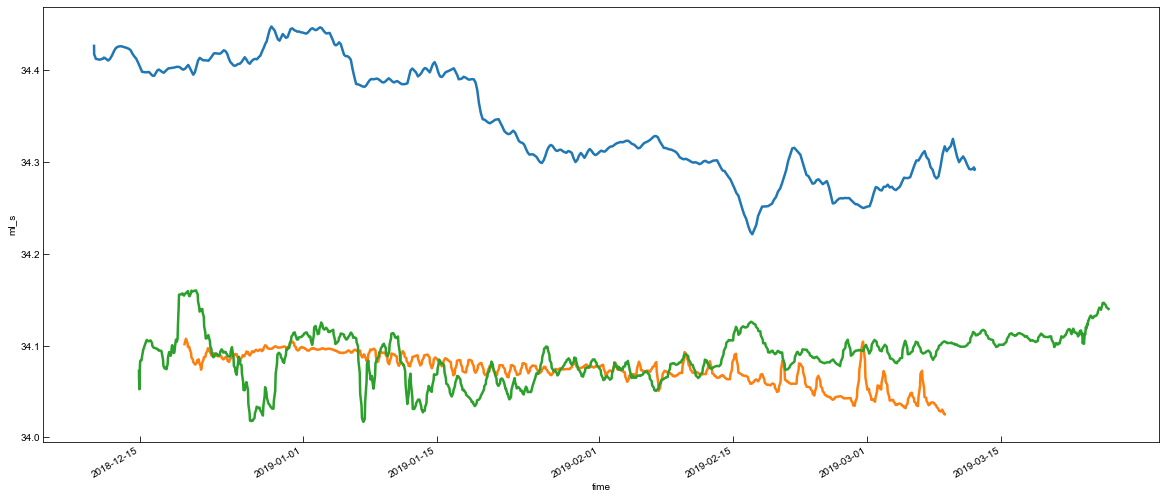

In [16]:
figure(figsize=[20, 8])
dat_saz.ml_s.plot()
dat_apz.ml_s.plot()
dat_miz.ml_s.plot()




#### Subantarctic Zone Glider

In [35]:
import glidertools as gt

In [48]:
x, spikes = gt.cleaning.ro(dat_saz.temp.sel(depth=10).values, window_size=3)

/Users/marcel/opt/anaconda3/lib/python3.8/site-packages/glidertools/helpers.py:70: GliderToolsWarning: Primary input variable is not xr.DataArray data type - no metadata to pass on.
  warnings.warn(msg, category=GliderToolsWarning)


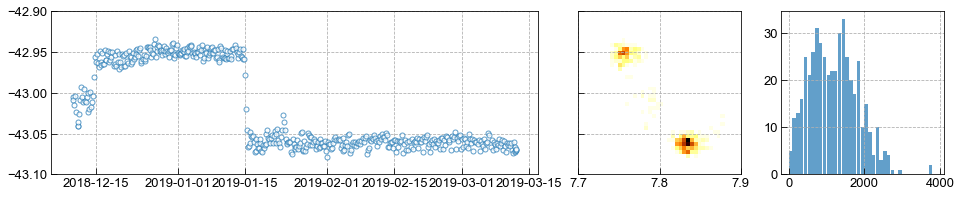

In [124]:
from matplotlib import gridspec

fig = plt.figure(figsize=(16, 3)) 
fig.subplots_adjust(wspace=0.15)
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 1, 1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

h0=ax0.plot(dat_saz.time, dat_saz.lat, marker='o', markersize=5, markerfacecolor='w', alpha=0.7, lw=0)
h1=ax1.hist2d(dat_saz.lon, dat_saz.lat, bins=30, cmap='afmhot_r', density=True)
h2=ax2.hist(gsw.distance(dat_saz.lon.values, dat_saz.lat.values), bins=np.arange(0, 4000, 100), alpha=0.7, width=90)

ax1.set_xlim(7.7, 7.9)
ax1.yaxis.set_ticklabels([])

for a in [ax0, ax1]:
    a.set_ylim(-43.1, -42.9)
    
for a in [ax0, ax1, ax2]:
    a.grid(ls='--')
    

#### Antarctic Polar Zone Glider

In [ ]:
from matplotlib import gridspec

dat = dat_apz


for i in tqdm(range(len(dat.time))):

    fig = plt.figure(figsize=(16, 9)) 
    fig.subplots_adjust(wspace=0.15)
    gs = gridspec.GridSpec(3, 3, width_ratios=[3, 1, 1])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[2])
    ax3 = plt.subplot(gs[3])
        
    h0=ax0.plot(dat.time[:i+1], dat.lat[:i+1], c='0.85', lw=1)
    h0=ax0.plot(dat.time[:i+1], dat.lat[:i+1], marker='o', markersize=2, markerfacecolor='w', alpha=0.7, lw=0)
    # h1=ax1.hist2d(dat.lon, dat.lat, bins=50, cmap='hot_r', density=True)
    h1=ax1.plot(dat.lon[:i], dat.lat[:i], c='0.5', alpha=0.5, lw=0.5)
    h1=ax1.plot(dat.lon[i-6:i+1], dat.lat[i-6:i+1], c='k', lw=1.5)
    h1=ax1.plot(dat.lon[i], dat.lat[i], marker='o', markersize=6, markerfacecolor='y', color='k', lw=2)
    if i>2:
        h2=ax2.hist(gsw.distance(dat.lon.values[:i+1], dat.lat.values[:i+1]), bins=np.arange(0, 5000, 100), alpha=0.7, width=90)
    
    h4=ax3.plot(dat.time[:i+1], dat.ml_t[:i+1], c='steelblue')
    ax3a=ax3.twinx()
    ax3a.plot(dat.time[:i+1], dat.ml_s[:i+1], c='green')
    
    for a in [ax0, ax1]:
        a.set_ylim(-54.1, -53.9)
    
    ax2.set_ylim(0, 110)
    ax3.set_ylim(-1.5, 2.5)
    ax3a.set_ylim(34, 34.175)
        
    ax1.set_xlim(-0.75, 0.75)
    ax2.set_xlim(0, 5000)
    
    for a in [ax0, ax3, ax3a]:
        a.set_xlim(dat.time[0], dat.time[-1])
    
    ax1.yaxis.set_ticklabels([])
        
    for a in [ax0, ax3]:
        a.grid(ls='--', which='minor')
        
    for a in [ax1, ax2]:
        a.grid(ls='--')
    
    for a in [ax0, ax3]:
        a.xaxis.set_major_locator(months)
        a.xaxis.set_major_formatter(yearsFmt)
        a.xaxis.set_minor_locator(weeks)
        
    if i < 10:
        savefig('/Users/marcel/Desktop/bf_paper_movies/apz_glider/fig_00'+str(i)+'.png', dpi=150)
    if ((i < 100) and (i > 9)):
        savefig('/Users/marcel/Desktop/bf_paper_movies/apz_glider/fig_0'+str(i)+'.png', dpi=150)
    if i > 99:
        savefig('/Users/marcel/Desktop/bf_paper_movies/apz_glider/fig_'+str(i)+'.png', dpi=150)

In [654]:
n = [1, 14, 27, 38, 50, 61, 72, 81, 91, 102, 112, 124, 136, 147, 159, 169, 181, 189, 197, 208, 219, 230, 241, 253, 265, 276, 287, 299, 309, 320, 331, 343, 354, 365, 375, 387, 397, 412, 424, 435, 446, 457, 469, 480, 491,
    502, 512, 524, 535, 546, 557, 568, 578, 589, 597, 603, 614, 626, 634, 643, 654, 644, 676, 687, 698, 710, 721, 732, 742, 753, 763, 773]
s = [6, 21, 33, 44, 55, 67, 78, 85, 97, 107, 118, 130, 141, 153, 164, 175, 186, 191, 203, 214, 225, 236, 247, 259, 270, 282, 293, 304, 314, 326, 337, 348, 359, 370, 381, 392, 403, 418, 429, 441, 451, 463, 474, 485, 497,
    507, 518, 529, 540, 551, 563, 573, 583, 594, 598, 609, 620, 631, 637, 648, 659, 670, 681, 693, 704, 716, 726, 737, 747, 758, 768]

#### Marginal Ice Zone Glider

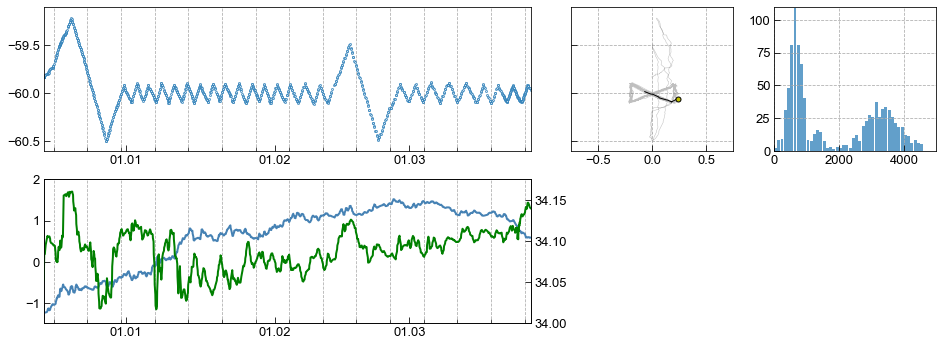

In [692]:
from matplotlib import gridspec

fig = plt.figure(figsize=(16, 9)) 
fig.subplots_adjust(wspace=0.15)
gs = gridspec.GridSpec(3, 3, width_ratios=[3, 1, 1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])

dat = dat_miz

h0=ax0.plot(dat.time, dat.lat, marker='o', markersize=2, markerfacecolor='w', alpha=0.7, lw=0)
# h1=ax1.hist2d(dat.lon, dat.lat, bins=50, cmap='hot_r', density=True)
h1=ax1.plot(dat.lon[:i], dat.lat[:i], c='0.5', alpha=0.5, lw=0.5)
h1=ax1.plot(dat.lon[i-10:i], dat.lat[i-10:i], c='k', lw=1)
h1=ax1.plot(dat.lon[i], dat.lat[i], marker='o', markersize=5, markerfacecolor='y', color='k')
h2=ax2.hist(gsw.distance(dat.lon.values, dat.lat.values), bins=np.arange(0, 5000, 100), alpha=0.7, width=90)

h4=ax3.plot(dat.time, dat.ml_t, c='steelblue')
ax3a=ax3.twinx()
ax3a.plot(dat.time, dat.ml_s, c='green')

for a in [ax0, ax1]:
    a.set_ylim(-60.6, -59.1)

ax2.set_ylim(0, 110)
ax3.set_ylim(-1.5, 2)
ax3a.set_ylim(34, 34.175)
    
ax1.set_xlim(-0.75, 0.75)
ax2.set_xlim(0, 5000)

for a in [ax0, ax3, ax3a]:
    a.set_xlim(dat.time[0], dat.time[-1])

ax1.yaxis.set_ticklabels([])
    
for a in [ax0, ax3]:
    a.grid(ls='--', which='minor')
    
for a in [ax1, ax2]:
    a.grid(ls='--')

for a in [ax0, ax3]:
    a.xaxis.set_major_locator(months)
    a.xaxis.set_major_formatter(yearsFmt)
    a.xaxis.set_minor_locator(weeks)

In [319]:
n = [78, 205, 235, 260, 289, 314, 343, 372, 399, 423, 453, 479, 504, 530, 554, 580, 606, 654, 734, 758, 782, 810, 836, 863, 883, 923, 973]
s = [0, 165, 222, 248, 276, 303, 332, 359, 389, 412, 440, 466, 494, 518, 545, 568, 597, 620, 700, 747, 770, 797, 823, 851, 873, 901, 950]

#### Clean TSG data

In [49]:
import glidertools as gt

data = tsg.sel(date=slice(tsg.date[0], tsg.date[150000]))

s = gt.cleaning.rolling_window(data.s, func=median, window=100)
s = gt.cleaning.rolling_window(s, func=mean, window=100)

t = gt.cleaning.rolling_window(data.t2, func=median, window=100)
t = gt.cleaning.rolling_window(t, func=mean, window=100)

#### Load EN4 interpolated data to get the gradients around the glider 

In [50]:
EN4 = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/EN4.2.1/OI_L09_1989_2020/*.nc')
EN4 = EN4.sel(time=slice('2018-12-10', '2019-03-26'), depth=EN4.depth[0].values)

EN4['lon'] = np.concatenate([EN4.lon[180:]-360, EN4.lon[:180]])

EN4['salinity']    = (('time', 'lat', 'lon'), np.concatenate([EN4.salinity[:, :, 180:],    EN4.salinity[:, :, :180]], axis=2))
EN4['temperature'] = (('time', 'lat', 'lon'), np.concatenate([EN4.temperature[:, :, 180:], EN4.temperature[:, :, :180]], axis=2))

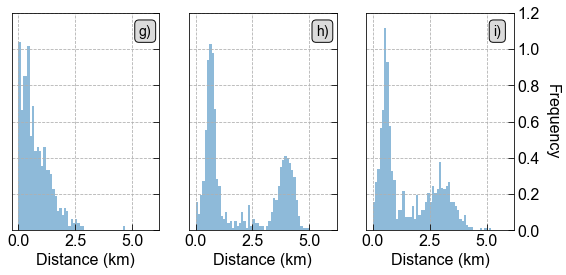

In [168]:
plt.rcParams['font.size'] = 16

fig, ax = subplots(1, 3, figsize=[9, 4])

ax[0].hist(d_lat_saz, bins=np.arange(0, 6, 0.1), width=0.1, alpha=0.5, density=True)
ax[1].hist(d_lat_apz, bins=np.arange(0, 6, 0.1), width=0.1, alpha=0.5, density=True)
ax[2].hist(d_lat_miz, bins=np.arange(0, 6, 0.1), width=0.1, alpha=0.5, density=True)

ax[0].set_ylim(0, 1.2)
ax[1].set_ylim(0, 1.2)
ax[2].set_ylim(0, 1.2)

[a.set_xlabel('Distance (km)') for a in ax]
ax[2].set_ylabel('Frequency', rotation=-90, labelpad=20)

ax[0].text(5.3, 1.06, 'g)', fontsize=14, verticalalignment='bottom', bbox=props)
ax[1].text(5.3, 1.06, 'h)', fontsize=14, verticalalignment='bottom', bbox=props)
ax[2].text(5.3, 1.06, 'i)', fontsize=14, verticalalignment='bottom', bbox=props)

ax[0].yaxis.set_label_position("right")
ax[1].yaxis.set_label_position("right")
ax[2].yaxis.set_label_position("right")
ax[0].yaxis.tick_right()
ax[1].yaxis.tick_right()
ax[2].yaxis.tick_right()
ax[0].yaxis.set_ticklabels([]); ax[1].yaxis.set_ticklabels([])
for a in ax:
    a.grid(ls='--')

savefig('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/figures/fig4_dist_hist.png', dpi=300, bbox_inches='tight')

#### Grid TSG data

In [119]:
from scipy.interpolate import griddata

lat = np.arange(-65, -35, 0.1)

s_tsg_grid = griddata(data.Latitude, s, lat)
t_tsg_grid = griddata(data.Latitude, t, lat)

i_saz = ((lat > -43-1.1) & (lat < -43+1.1))
i_apz = ((lat > -54-1.1) & (lat < -54+1.1))
i_miz = ((lat > -60-1.1) & (lat < -60+1.1))

#### Get gradients in the EN4 data

In [120]:
EN4_mean = EN4.mean(dim='time')
EN4_std = EN4.std(dim='time')

# salinity 
s_en4_mn_saz = EN4_mean.sel(lon=8, lat=slice(-44, -42)).salinity
s_en4_sd_saz = EN4_std.sel( lon=8, lat=slice(-44, -42)).salinity

s_en4_mn_apz = EN4_mean.sel(lon=0, lat=slice(-55, -53)).salinity
s_en4_sd_apz = EN4_std.sel( lon=0, lat=slice(-55, -53)).salinity

s_en4_mn_miz = EN4_mean.sel(lon=0, lat=slice(-61, -59)).salinity
s_en4_sd_miz = EN4_std.sel( lon=0, lat=slice(-61, -59)).salinity

s_en4_an_saz = s_en4_mn_saz-np.mean(s_en4_mn_saz)
s_en4_an_apz = s_en4_mn_apz-np.mean(s_en4_mn_apz)
s_en4_an_miz = s_en4_mn_miz-np.mean(s_en4_mn_miz)

# temperature 
t_en4_mn_saz = EN4_mean.sel(lon=8, lat=slice(-44, -42)).temperature
t_en4_sd_saz = EN4_std.sel( lon=8, lat=slice(-44, -42)).temperature

t_en4_mn_apz = EN4_mean.sel(lon=0, lat=slice(-55, -53)).temperature
t_en4_sd_apz = EN4_std.sel( lon=0, lat=slice(-55, -53)).temperature

t_en4_mn_miz = EN4_mean.sel(lon=0, lat=slice(-61, -59)).temperature
t_en4_sd_miz = EN4_std.sel( lon=0, lat=slice(-61, -59)).temperature

t_en4_an_saz = t_en4_mn_saz-np.mean(t_en4_mn_saz)
t_en4_an_apz = t_en4_mn_apz-np.mean(t_en4_mn_apz)
t_en4_an_miz = t_en4_mn_miz-np.mean(t_en4_mn_miz)

### Identify changing mesoscale gradients from the Sailbuoy repeat transects

Identify the scale of the gradient from the large scale transects that were done by the sailbuoy, co-locate those transects in time to the glider and multiply the gradient by the change in distance covered by the latitude. 

Load Sailbuoy data

In [363]:
import datetime

def datenum_to_datetime(datenum):
    """
    Convert Matlab datenum into Python datetime.
    :param datenum: Date in datenum format
    :return:        Datetime object corresponding to datenum.
    """
    days = datenum % 1
    return datetime.datetime.fromordinal(int(datenum)) \
           + datetime.timedelta(days=days) \
           - datetime.timedelta(days=366)

In [364]:
import scipy.io

SB_mat = scipy.io.loadmat('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/sailbuoy/marcel_SB_transects.mat')
sb_date = [datenum_to_datetime(d.squeeze()) for d in SB_mat['date'].squeeze()]

sb_data = xr.Dataset(
                 data_vars={'lat' : (('time'), SB_mat['lat'].squeeze()),
                            'lon' : (('time'), SB_mat['lon'].squeeze()),
                            's_ml' : (('time'), SB_mat['salt_filt_movm'].squeeze()),
                            't_ml' : (('time'), SB_mat['temp_filt_movm'].squeeze())},
                 coords={'time': sb_date})

2. Creating a function which sorts the salinity or temperature into latitudinal bins. This is done as the Sailbuoy often backs on itself and so you can get a clump of data in one spot.


In [365]:
def filter_grad(data, transect_ind, which='s_ml', func=np.nanmin, lat_min=-61, lat_max=-59, lat_int=0.05):
    
    lat_bins = np.arange(lat_min, lat_max, lat_int)
    s_val    = np.ndarray([len(lat_bins), len(transect_ind)-1])
    date_transect = np.ndarray([len(transect_ind)-1])
    
    for i in range(len(transect_ind)-1):
        
        lat_transect     = data.lat[transect_ind[i]:transect_ind[i+1]]
        date_transect[i] = data.time.values[transect_ind[i]]
            
        
        for l, val in enumerate(lat_bins):
            
            ii = ((lat_transect>val) & (lat_transect<val+lat_int))
            
            try:
                s_val[l, i] = func(data[which][ind[i]:ind[i+1]][ii])
            except:
                s_val[l, i] = np.NaN
            
    return s_val, lat_bins, date_transect

3. Run the filter through the data, with the output of:

    - A gridded salinity products with x, y of latitudinal bins and salinity

In [366]:
ind = [200, 700, 1300, 2500, 3200, 3640, 3920, 4400, 4930, 5500, 5750, 6100, 6680, 7100, 7980, 8430, 8730, 9250, 9650]

sb_s_grid, lat_bins, date_transect = filter_grad(sb_data, ind)
date_transect = sb_data.time[ind[:-1]]

sb_t_grid, lat_bins, date_transect = filter_grad(sb_data, ind, which='t_ml')
date_transect = sb_data.time[ind[:-1]]

4. Mean and std of the Sailbuoy data

In [367]:
sb_s_mean = np.nanmean(sb_s_grid, axis=1)
sb_s_std  = np.nanstd(sb_s_grid, axis=1)

sb_t_mean = np.nanmean(sb_t_grid, axis=1)
sb_t_std  = np.nanstd(sb_t_grid, axis=1)

sb_s_anom = sb_s_mean - np.nanmean(sb_s_mean)
sb_t_anom = sb_t_mean - np.nanmean(sb_t_mean)

#### Plot the gradients

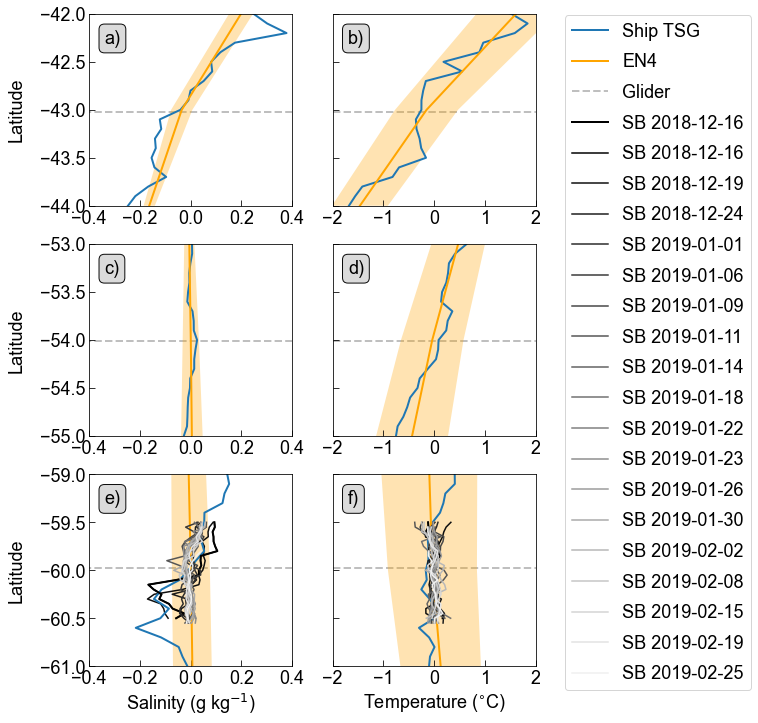

In [164]:
plt.rcParams['font.size'] = 18

fig, ax = subplots(3, 2, figsize=[8, 12])

# ship tsg
ax[0,0].plot(s_tsg_grid[i_saz]-np.mean(s_tsg_grid[i_saz]), lat[i_saz], label='Ship TSG')
ax[1,0].plot(s_tsg_grid[i_apz]-np.mean(s_tsg_grid[i_apz]), lat[i_apz], label='Ship TSG')
ax[2,0].plot(s_tsg_grid[i_miz]-np.mean(s_tsg_grid[i_miz]), lat[i_miz], label='Ship TSG')

ax[0,1].plot(t_tsg_grid[i_saz]-np.mean(t_tsg_grid[i_saz]), lat[i_saz], label='Ship TSG')
ax[1,1].plot(t_tsg_grid[i_apz]-np.mean(t_tsg_grid[i_apz]), lat[i_apz], label='Ship TSG')
ax[2,1].plot(t_tsg_grid[i_miz]-np.mean(t_tsg_grid[i_miz]), lat[i_miz], label='Ship TSG')

for a in range(3):
    
    ax[a,0].set_xlim(-0.4, 0.4)
    ax[a,1].set_xlim(-2.0, 2.0)
    
    ax[a,0].xaxis.set_ticks([-0.4, -0.2, 0, 0.2, 0.4])
    ax[a,1].xaxis.set_ticks([-2, -1, 0, 1, 2])
    
    ax[a,1].yaxis.set_ticklabels([])

#en4
ax[0,0].plot(s_en4_an_saz, [-44, -43, -42], c='orange', label='EN4')
ax[1,0].plot(s_en4_an_apz, [-55, -54, -53], c='orange', label='EN4')
ax[2,0].plot(s_en4_an_miz, [-61, -60, -59], c='orange', label='EN4')

ax[0,1].plot(t_en4_an_saz, [-44, -43, -42], c='orange', label='EN4')
ax[1,1].plot(t_en4_an_apz, [-55, -54, -53], c='orange', label='EN4')
ax[2,1].plot(t_en4_an_miz, [-61, -60, -59], c='orange', label='EN4')


ax[0,0].fill_betweenx([-44, -43, -42], x1=s_en4_an_saz-s_en4_sd_saz, x2=s_en4_an_saz+s_en4_sd_saz, alpha=0.3, facecolor='orange')
ax[1,0].fill_betweenx([-55, -54, -53], x1=s_en4_an_apz-s_en4_sd_apz, x2=s_en4_an_apz+s_en4_sd_apz, alpha=0.3, facecolor='orange')
ax[2,0].fill_betweenx([-61, -60, -59], x1=s_en4_an_miz-s_en4_sd_miz, x2=s_en4_an_miz+s_en4_sd_miz, alpha=0.3, facecolor='orange')

ax[0,1].fill_betweenx([-44, -43, -42], x1=t_en4_an_saz-t_en4_sd_saz, x2=t_en4_an_saz+t_en4_sd_saz, alpha=0.3, facecolor='orange')
ax[1,1].fill_betweenx([-55, -54, -53], x1=t_en4_an_apz-t_en4_sd_apz, x2=t_en4_an_apz+t_en4_sd_apz, alpha=0.3, facecolor='orange')
ax[2,1].fill_betweenx([-61, -60, -59], x1=t_en4_an_miz-t_en4_sd_miz, x2=t_en4_an_miz+t_en4_sd_miz, alpha=0.3, facecolor='orange')

#glider latitudes
[a.plot([-2, 2], [dat_saz_12H.lat.mean(), dat_saz_12H.lat.mean()], c='0.75', ls='--', label='Glider', zorder=0) for a in ax[0]]
[a.plot([-2, 2], [dat_apz_12H.lat.mean(), dat_apz_12H.lat.mean()], c='0.75', ls='--', label='Glider', zorder=0) for a in ax[1]]
[a.plot([-2, 2], [dat_miz_12H.lat.mean(), dat_miz_12H.lat.mean()], c='0.75', ls='--', label='Glider', zorder=0) for a in ax[2]]

# sailbuoy sb_s_grid
ax[2,0].plot(sb_s_grid[:, 0]-np.nanmean(sb_s_grid[:, 0]), lat_bins, c='k', label='SB '+str(date_transect[0].values)[:10])
ax[2,1].plot(sb_t_grid[:, 0]-np.nanmean(sb_t_grid[:, 0]), lat_bins, c='k', label='SB '+str(date_transect[0].values)[:10])

# ax[2,0].plot(sb_s_anom, lat_bins, c='0.5', label='SB mean')
# ax[2,1].plot(sb_t_anom, lat_bins, c='0.5', label='SB mean')

# ax[2,0].fill_betweenx(lat_bins, x1=sb_s_anom-sb_s_std, x2=sb_s_anom+sb_s_std, alpha=0.3, facecolor='0.5')
# ax[2,1].fill_betweenx(lat_bins, x1=sb_t_anom-sb_t_std, x2=sb_t_anom+sb_t_std, alpha=0.3, facecolor='0.5')

ax[0,0].set_ylim(-44, -42)
ax[1,0].set_ylim(-55, -53)
ax[2,0].set_ylim(-61, -59)

ax[0,1].set_ylim(-44, -42)
ax[1,1].set_ylim(-55, -53)
ax[2,1].set_ylim(-61, -59)

props = dict(boxstyle='round', facecolor='0.85', alpha=0.95)

ax[0,0].text(-0.34, -42.35, 'a)', verticalalignment='bottom', bbox=props)
ax[1,0].text(-0.34, -53.35, 'c)', verticalalignment='bottom', bbox=props)
ax[2,0].text(-0.34, -59.35, 'e)', verticalalignment='bottom', bbox=props)

ax[0,1].text(-1.7,  -42.35, 'b)', verticalalignment='bottom', bbox=props)
ax[1,1].text(-1.7,  -53.35, 'd)', verticalalignment='bottom', bbox=props)
ax[2,1].text(-1.7,  -59.35, 'f)', verticalalignment='bottom', bbox=props)

ax[2,0].set_xlabel('Salinity (g kg$^{-1}$)')
ax[2,1].set_xlabel('Temperature ($^{\circ}$C)')

for i in range(3):
    ax[i,0].set_ylabel('Latitude', labelpad=15)

for i in range(len(date_transect)):

    Ys = sb_s_grid[:, i]
    Yt = sb_t_grid[:, i]

    ax[2,0].plot(Ys-np.nanmean(Ys), lat_bins, color=str(i/len(date_transect)), zorder=i, lw=1.5, label='SB '+str(date_transect[i].values)[:10])   
    ax[2,1].plot(Yt-np.nanmean(Yt), lat_bins, color=str(i/len(date_transect)), zorder=i, lw=1.5, label='SB '+str(date_transect[i].values)[:10])


ax[2, 0].legend(loc=2, ncol=1, bbox_to_anchor=[2.3, 3.44], prop={'size': 18},labelspacing=0.7)
savefig('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/figures/fig4_grad.png', dpi=300, bbox_inches='tight')

### Glider motion

From the latitudinal gradient in temperature and salinity and the latitudinal movement that the glider undergoes, we can determine a quantified perspective of how much the salinity should change based on how much the glider has moved

#### Identify regression lines for each transect, from which the gradient in salinity will be calculated to determine what gradient is crossed by the MIZ glider

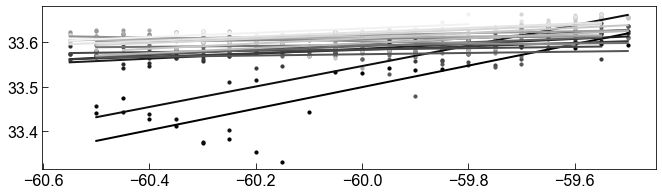

In [171]:
from sklearn.linear_model import LinearRegression

figure(figsize=[11, 3])

for i in range(len(date_transect)):

    X = lat_bins
    Y = sb_s_grid[:, i]
    
    i_good=~np.isnan(Y) # find the good data
    X = X[i_good]; Y = Y[i_good]
    
    X = X.reshape(-1, 1)
    Y = Y.reshape(-1, 1)
    
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(X, Y)  # perform linear regression
    Y_pred = linear_regressor.predict(X)  # make predictions
    
    plt.scatter(X, Y, 10, color=str(i/len(date_transect)))
    plt.plot(X, Y_pred, c=str(i/len(date_transect)))

#### For each date, indentify the gradient from the regression line to apply the latitudinal distance that the glider moves across

In [172]:
import gsw 

def find_grad(data_grid, lat_bins=lat_bins, lat_min=-60.1, lat_max=-59.9):
    
    dSdy = np.ndarray([len(data_grid.T)])
    
    for i in range(len(data_grid.T)):

        X = lat_bins
        Y = data_grid[:, i]
        
        i_good=~np.isnan(Y) # find the good data
        X = X[i_good]; Y = Y[i_good]
        
        X = X.reshape(-1, 1)
        Y = Y.reshape(-1, 1)
        
        linear_regressor = LinearRegression()  # create object for the class
        linear_regressor.fit(X, Y)  # perform linear regression
        Y_pred = linear_regressor.predict(X)  # make predictions
        
        xmin = np.round(X.squeeze(), 2)==lat_min
        xmax = np.round(X.squeeze(), 2)==lat_max
    
        dy = gsw.distance([0, 0], [X.squeeze()[xmax].squeeze(), X.squeeze()[xmin].squeeze()])
        dS = Y_pred.squeeze()[xmin].squeeze()-Y_pred.squeeze()[xmax].squeeze()
        
        dSdy[i] = dS/dy
    
    return dSdy

sb_dSdy_miz = find_grad(sb_s_grid)
sb_dTdy_miz = find_grad(sb_t_grid)

#### Co-locate for each glider sampling day, the time step the gradient of salinity from the nearest date of sb transect

In [339]:
ds_glider_miz = np.ndarray(len(dat_miz.time)-1)
dt_glider_miz = np.ndarray(len(dat_miz.time)-1)

dSdy_miz = np.ndarray(len(dat_miz.time)-1)
dTdy_miz = np.ndarray(len(dat_miz.time)-1)

for i in range(len(dat_miz.time)-1):
    
    dlat = dat_miz.lat.values[i] - dat_miz.lat.values[i+1]
    dist_dlat = gsw.distance([dat_miz.lon.values[i], dat_miz.lon.values[i+1]], [dat_miz.lat.values[i], dat_miz.lat.values[i+1]])
    
    if dlat < 0:     
        dist_dlat = -dist_dlat      
    
    ind = np.argmin(np.abs(date2num(dat_miz.time.values[i])-date2num(date_transect.values)))
    dSdy_miz[i]  = sb_dSdy_miz[ind]
    dTdy_miz[i]  = sb_dTdy_miz[ind]
        
    ds_glider_miz[i] = (dSdy_miz[i])*dist_dlat
    dt_glider_miz[i] = (dTdy_miz[i])*dist_dlat

dat_miz['dS_glider_displacement'] = (('time'), np.append(0, ds_glider_miz))
dat_miz['dT_glider_displacement'] = (('time'), np.append(0, dt_glider_miz))

dat_miz['SB_dSdy'] = (('time'), np.append(0, dSdy_miz))
dat_miz['SB_dTdy'] = (('time'), np.append(0, dTdy_miz))

### Calculate gradients for the SAZ and APZ gliders 

The gradients from the EN4 product in the saz and apz seem to match up rather well with the ship TSG transect and so we are happy with the gradient provided by that product. So I co-locate the nearest gradient of that product to the glider time series, providing a time varying gradient.

In [340]:
def calc_EN4_grad(EN4, gl_data, lon_ctr, lat_ctr, which='salinity'):

    EN4_dSdx = np.ndarray(shape(gl_data.time))
    EN4_dSdy = np.ndarray(shape(gl_data.time))
    
    for i, val in enumerate([12,1,2,3]):
        
        ind_gl  = gl_data['time.month']==val
        ind_EN4 = EN4['time.month']==val
        
        ind_43 = gl_data.lat.values[ind_gl]<lat_ctr
        EN4_dSdx[ind_gl] = (EN4[which].sel(lon=slice(lon_ctr-1,lon_ctr+1), lat=lat_ctr)[ind_EN4].squeeze()[0].values - EN4[which].sel(lon=slice(lon_ctr-1,lon_ctr+1), lat=lat_ctr)[ind_EN4].squeeze()[-1].values)/gsw.distance([lon_ctr-1, lon_ctr+1], [lat_ctr, lat_ctr]).squeeze()
            
        ind_42 = gl_data.lat.values[ind_gl]>lat_ctr
        EN4_dSdx[ind_gl] = (EN4[which].sel(lon=slice(lon_ctr-1,lon_ctr+1), lat=lat_ctr+1)[ind_EN4].squeeze()[0].values - EN4[which].sel(lon=slice(lon_ctr-1,lon_ctr+1), lat=lat_ctr+1)[ind_EN4].squeeze()[-1].values)/gsw.distance([lon_ctr-1,lon_ctr+1], [lat_ctr+1, lat_ctr+1]).squeeze()
            
        EN4_dSdy[ind_gl] = (EN4[which].sel(lon=lon_ctr, lat=slice(lat_ctr-1, lat_ctr+1))[ind_EN4].squeeze()[0].values - EN4[which].sel(lon=lon_ctr, lat=slice(lat_ctr-1, lat_ctr+1))[ind_EN4].squeeze()[-1].values)/gsw.distance([lon_ctr, lon_ctr], [lat_ctr-1, lat_ctr+1]).squeeze()         
    
    if which=='salinity':
        gl_data['EN4_dSdx'] = (('time'), EN4_dSdx)
        gl_data['EN4_dSdy'] = (('time'), EN4_dSdy)
        
    if which=='temperature':
        gl_data['EN4_dTdx'] = (('time'), EN4_dSdx)
        gl_data['EN4_dTdy'] = (('time'), EN4_dSdy)
    
    return gl_data
    
dat_saz = calc_EN4_grad(EN4, dat_saz, 7, -43, which='temperature')
dat_apz = calc_EN4_grad(EN4, dat_apz, 0, -54, which='temperature')

dat_saz = calc_EN4_grad(EN4, dat_saz, 7, -43, which='salinity')
dat_apz = calc_EN4_grad(EN4, dat_apz, 0, -54, which='salinity')

### Calculate glider displacement temperature and salinity tendency

In [348]:
ds_glider_saz = gsw.distance(dat_saz.lon.values, dat_saz.lat.values) * (dat_saz.EN4_dSdy[1:])
ds_glider_apz = gsw.distance(dat_apz.lon.values, dat_apz.lat.values) * (dat_apz.EN4_dSdy[1:])

dt_glider_saz = gsw.distance(dat_saz.lon.values, dat_saz.lat.values) * (dat_saz.EN4_dTdy[1:])
dt_glider_apz = gsw.distance(dat_apz.lon.values, dat_apz.lat.values) * (dat_apz.EN4_dTdy[1:])

dlat_saz = np.diff(dat_saz.lat.values)
dlat_apz = np.diff(dat_apz.lat.values)
    
ds_glider_saz[dlat_saz<0] = -ds_glider_saz[dlat_saz<0]
ds_glider_apz[dlat_apz<0] = -ds_glider_apz[dlat_apz<0]

dt_glider_saz[dlat_saz<0] = -dt_glider_saz[dlat_saz<0]
dt_glider_apz[dlat_apz<0] = -dt_glider_apz[dlat_apz<0]

dat_saz['dS_glider_displacement'] = (('time'), np.append(0, ds_glider_saz))
dat_apz['dS_glider_displacement'] = (('time'), np.append(0, ds_glider_apz))

dat_saz['dT_glider_displacement'] = (('time'), np.append(0, dt_glider_saz))
dat_apz['dT_glider_displacement'] = (('time'), np.append(0, dt_glider_apz))

AttributeError: 'Dataset' object has no attribute 'dS_glider_displacement'

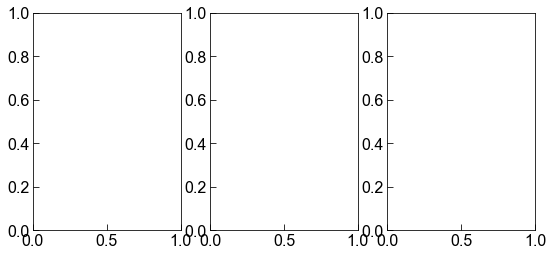

In [714]:
plt.rcParams['font.size'] = 16

fig, ax = subplots(1, 3, figsize=[9, 4])

ax[0].hist(dat_saz.dS_glider_displacement, bins=np.arange(0, 6, 0.1), width=0.1, alpha=0.5, density=True)
ax[1].hist(dat_apz.dS_glider_displacement, bins=np.arange(0, 6, 0.1), width=0.1, alpha=0.5, density=True)
ax[2].hist(dat_miz.dS_glider_displacement, bins=np.arange(0, 6, 0.1), width=0.1, alpha=0.5, density=True)

ax[0].set_ylim(0, 1.2)
ax[1].set_ylim(0, 1.2)
ax[2].set_ylim(0, 1.2)

[a.set_xlabel('Distance (km)') for a in ax]
ax[2].set_ylabel('Frequency', rotation=-90, labelpad=20)

ax[0].text(5.3, 1.06, 'g)', fontsize=14, verticalalignment='bottom', bbox=props)
ax[1].text(5.3, 1.06, 'h)', fontsize=14, verticalalignment='bottom', bbox=props)
ax[2].text(5.3, 1.06, 'i)', fontsize=14, verticalalignment='bottom', bbox=props)

ax[0].yaxis.set_label_position("right")
ax[1].yaxis.set_label_position("right")
ax[2].yaxis.set_label_position("right")
ax[0].yaxis.tick_right()
ax[1].yaxis.tick_right()
ax[2].yaxis.tick_right()
ax[0].yaxis.set_ticklabels([]); ax[1].yaxis.set_ticklabels([])
for a in ax:
    a.grid(ls='--')

# savefig('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/figures/fig4_dist_hist.png', dpi=300, bbox_inches='tight')

In [365]:
def remove_grad_ts(data, var='salt'):

    anom = data[var].sel(depth=10) - data[var].sel(depth=10)[0]
    
    if var =='salt':
        anom_minus_grad = np.append(0, (np.diff(anom) - np.diff(data.dS_glider_displacement)).cumsum().squeeze())
        data['ml_s_no_grad'] = (('time'), data[var].sel(depth=10)[0].values + anom_minus_grad)
        
    if var =='temp':
        anom_minus_grad = np.append(0, (np.diff(anom) - np.diff(data.dT_glider_displacement)).cumsum().squeeze())
        data['ml_t_no_grad'] = (('time'), data[var].sel(depth=10)[0].values + anom_minus_grad)        

    return data

In [366]:
dat_saz = remove_grad_ts(dat_saz, var='salt')
dat_saz = remove_grad_ts(dat_saz, var='temp')

dat_apz = remove_grad_ts(dat_apz, var='salt')
dat_apz = remove_grad_ts(dat_apz, var='temp')

dat_miz = remove_grad_ts(dat_miz, var='salt')
dat_miz = remove_grad_ts(dat_miz, var='temp')

### Figure 5

Removing the glider displacement from the time series

In [46]:
dat_saz_1D['ml_t_anom'] = (('time'),  dat_saz_1D.ml_t-np.nanmean(dat_saz_1D.ml_t))
dat_apz_1D['ml_t_anom'] = (('time'),  dat_apz_1D.ml_t-np.nanmean(dat_apz_1D.ml_t))
dat_miz_1D['ml_t_anom'] = (('time'),  dat_miz_1D.ml_t-np.nanmean(dat_miz_1D.ml_t))

dat_saz_1D['ml_s_anom'] = (('time'),  dat_saz_1D.ml_s-np.nanmean(dat_saz_1D.ml_s))
dat_apz_1D['ml_s_anom'] = (('time'),  dat_apz_1D.ml_s-np.nanmean(dat_apz_1D.ml_s))
dat_miz_1D['ml_s_anom'] = (('time'),  dat_miz_1D.ml_s-np.nanmean(dat_miz_1D.ml_s))

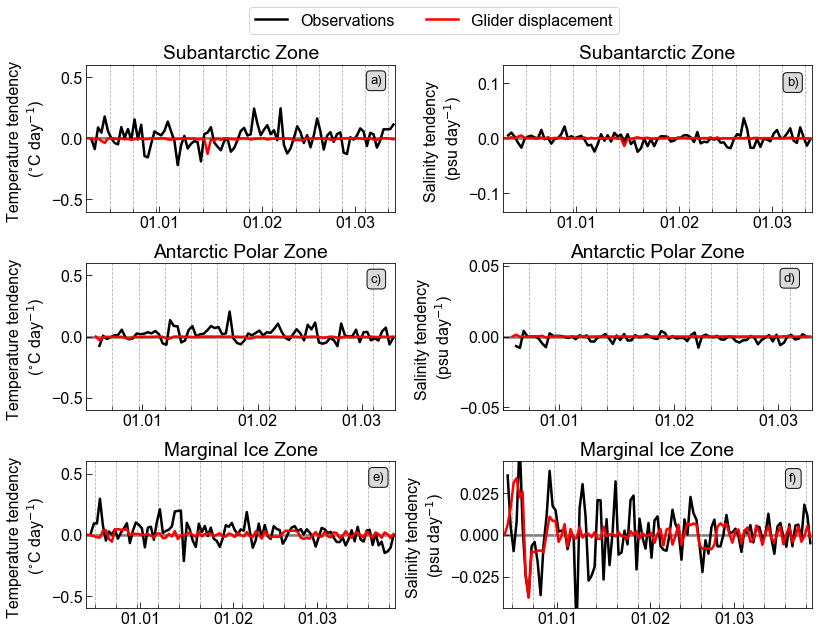

In [47]:
plt.rcParams['font.size'] = 16

fig, ax = subplots(3, 2, figsize=[13, 10])
fig.subplots_adjust(wspace=0.35, hspace=0.35)

#salinity

ax[0,1].plot(dat_saz_1D.time[1:], np.diff(dat_saz_1D.ml_s),          c='k', label='Observations')
ax[0,1].plot(dat_saz_1D.time    , dat_saz_1D.dS_glider_displacement, c='r', label='Glider displacement')

ax[1,1].plot(dat_apz_1D.time[1:], np.diff(dat_apz_1D.ml_s),          c='k')
ax[1,1].plot(dat_apz_1D.time    , dat_apz_1D.dS_glider_displacement, c='r')

ax[2,1].plot(dat_miz_1D.time[1:], np.diff(dat_miz_1D.ml_s),          c='k')
ax[2,1].plot(dat_miz_1D.time    , dat_miz_1D.dS_glider_displacement, c='r')

#temperature

ax[0,0].plot(dat_saz_1D.time[1:], np.diff(dat_saz_1D.ml_t),          c='k', label='Observations')
ax[0,0].plot(dat_saz_1D.time    , dat_saz_1D.dT_glider_displacement, c='r', label='Glider displacement')

ax[1,0].plot(dat_apz_1D.time[1:], np.diff(dat_apz_1D.ml_t),          c='k')
ax[1,0].plot(dat_apz_1D.time    , dat_apz_1D.dT_glider_displacement, c='r')

ax[2,0].plot(dat_miz_1D.time[1:], np.diff(dat_miz_1D.ml_t),          c='k')
ax[2,0].plot(dat_miz_1D.time    , dat_miz_1D.dT_glider_displacement, c='r')

# plotting features

for i in range(3):
    
    ax[i,0].set_ylim(-0.60, 0.60)
    
    ax[i,0].set_ylabel('Temperature tendency \n($^{\circ}$C day$^{-1}$)')
    ax[i,1].set_ylabel('Salinity tendency \n(psu day$^{-1}$)')
    
    for ii in range(2):
        
        ax[i,ii].xaxis.set_major_locator(months)
        ax[i,ii].xaxis.set_major_formatter(yearsFmt)
        ax[i,ii].xaxis.set_minor_locator(weeks)
        
        ax[i,ii].grid(ls='--', which='minor')
        ax[i,ii].plot([dat_saz_1D.time[0].values, dat_miz_1D.time[-1].values], [0, 0], c='0.75', zorder=0, lw=2)

        ax[0,ii].set_xlim('2018-12-10', '2019-03-13')
        ax[1,ii].set_xlim('2018-12-17', '2019-03-10')
        ax[2,ii].set_xlim('2018-12-14', '2019-03-27')


[a[1].plot([dat_saz_1D.time[0].values, dat_miz_1D.time[-1].values], [0, 0], c='0.5', zorder=0) for a in ax]
[a[0].plot([dat_saz_1D.time[0].values, dat_miz_1D.time[-1].values], [0, 0], c='0.5', zorder=0) for a in ax]

ax[0,0].set_xlim('2018-12-10', '2019-03-13')
ax[0,1].set_xlim('2018-12-10', '2019-03-13')

ax[1,0].set_xlim('2018-12-17', '2019-03-10')
ax[1,1].set_xlim('2018-12-17', '2019-03-10')

ax[2,0].set_xlim('2018-12-14', '2019-03-27')
ax[2,1].set_xlim('2018-12-14', '2019-03-27')

ax[0,0].set_title('Subantarctic Zone')
ax[0,1].set_title('Subantarctic Zone')
ax[1,0].set_title('Antarctic Polar Zone')
ax[1,1].set_title('Antarctic Polar Zone')
ax[2,0].set_title('Marginal Ice Zone')
ax[2,1].set_title('Marginal Ice Zone')

ax[0,0].text(dat_saz_1D.time.values[-8], 0.42, 'a)', fontsize=13, verticalalignment='bottom', bbox=props)
ax[0,1].text(dat_saz_1D.time.values[-8], 0.09, 'b)', fontsize=13, verticalalignment='bottom', bbox=props)
ax[1,0].text(dat_apz_1D.time.values[-7], 0.42, 'c)', fontsize=13, verticalalignment='bottom', bbox=props)
ax[1,1].text(dat_apz_1D.time.values[-8], 0.037, 'd)', fontsize=13, verticalalignment='bottom', bbox=props)
ax[2,0].text(dat_miz_1D.time.values[-8], 0.42, 'e)', fontsize=13, verticalalignment='bottom', bbox=props)
ax[2,1].text(dat_miz_1D.time.values[-8], 0.03, 'f)', fontsize=13, verticalalignment='bottom', bbox=props)

ax[0,0].legend(loc=2, ncol=5, bbox_to_anchor=(0.5, 1.45), prop={'size': 16})

ds_saz = (1.2*gsw.alpha(dat_saz_1D.ml_s.mean(), dat_saz_1D.ml_t.mean(), 0))/gsw.beta(dat_saz_1D.ml_s.mean(), dat_saz_1D.ml_t.mean(), 0)
ds_apz = (1.2*gsw.alpha(dat_apz_1D.ml_s.mean(), dat_apz_1D.ml_t.mean(), 0))/gsw.beta(dat_apz_1D.ml_s.mean(), dat_apz_1D.ml_t.mean(), 0)
ds_miz = (1.2*gsw.alpha(dat_miz_1D.ml_s.mean(), dat_miz_1D.ml_t.mean(), 0))/gsw.beta(dat_miz_1D.ml_s.mean(), dat_miz_1D.ml_t.mean(), 0)

ax[0,1].set_ylim(-(ds_saz/2), -(ds_saz/2)+ds_saz)
ax[1,1].set_ylim(-(ds_apz/2), -(ds_apz/2)+ds_apz)
ax[2,1].set_ylim(-(ds_miz/2), -(ds_miz/2)+ds_miz)

savefig('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/figures/fig5_gl_disp.png', dpi=300, bbox_inches='tight')

### Load Precipitation and Evaporation

## Heat fluxes

In [52]:

# calculate qnet

hf_jra55['qnet'] = (('time', 'latitude', 'longitude'), -((hf_jra55.usw.values - hf_jra55.dsw.values) + (hf_jra55.ulw.values-hf_jra55.dlw.values) + hf_jra55.shf.values + hf_jra55.lhf.values))
hf_cfsv2['qnet'] = (('time', 'latitude', 'longitude'), -((hf_cfsv2.usw.values - hf_cfsv2.dsw.values) + (hf_cfsv2.ulw.values-hf_cfsv2.dlw.values) + hf_cfsv2.shf.values + hf_cfsv2.lhf.values))
hf_era5 ['qnet'] = (('time', 'latitude', 'longitude'), (hf_era5.swr.values + hf_era5.lwr.values  + hf_era5.shf.values + hf_era5.lhf.values)/3600)


In [53]:
dates = np.append(dat_saz_1D.time.values, dat_miz_1D.time[89:].values)

hf_jra55 = hf_jra55.sel(time=dates)
hf_cfsv2 = hf_cfsv2.sel(time=dates)
hf_era5  = hf_era5.sel(time=dates)

dat_saz_1D['qnet_jra55'] = hf_jra55.qnet.sel(time=dat_saz_1D.time, longitude=slice(7, 9), latitude=slice(-42, -44)).mean(dim=('latitude', 'longitude'))
dat_saz_1D['qnet_era5' ] = hf_era5 .qnet.sel(time=dat_saz_1D.time, longitude=slice(7, 9), latitude=slice(-42, -44)).mean(dim=('latitude', 'longitude'))
dat_saz_1D['qnet_cfsv2'] = hf_cfsv2.qnet.sel(time=dat_saz_1D.time, longitude=slice(7, 9), latitude=slice(-42, -44)).mean(dim=('latitude', 'longitude'))

dat_apz_1D['qnet_jra55'] = hf_jra55.qnet.sel(time=dat_apz_1D.time, longitude=slice(-1, 1), latitude=slice(-53, -55)).mean(dim=('latitude', 'longitude'))
dat_apz_1D['qnet_era5' ] = hf_era5 .qnet.sel(time=dat_apz_1D.time, longitude=slice(-1, 1), latitude=slice(-53, -55)).mean(dim=('latitude', 'longitude'))
dat_apz_1D['qnet_cfsv2'] = hf_cfsv2.qnet.sel(time=dat_apz_1D.time, longitude=slice(-1, 1), latitude=slice(-53, -55)).mean(dim=('latitude', 'longitude'))

dat_miz_1D['qnet_jra55'] = hf_jra55.qnet.sel(time=dat_miz_1D.time, longitude=slice(-1, 1), latitude=slice(-59, -61)).mean(dim=('latitude', 'longitude'))
dat_miz_1D['qnet_era5' ] = hf_era5 .qnet.sel(time=dat_miz_1D.time, longitude=slice(-1, 1), latitude=slice(-59, -61)).mean(dim=('latitude', 'longitude'))
dat_miz_1D['qnet_cfsv2'] = hf_cfsv2.qnet.sel(time=dat_miz_1D.time, longitude=slice(-1, 1), latitude=slice(-59, -61)).mean(dim=('latitude', 'longitude'))

### Wind Stress

In [54]:
wind_cfsv2 = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/wind_speed/CFSv2/*.nc')
wind_era5  = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/wind_speed/ERA5/*.nc')
wind_jra55 = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/wind_speed/JRA55/*.nc')

#Change to consisent naming convention for longitude and latitudes
wind_cfsv2 = wind_cfsv2.rename({'lon': 'longitude',
                                'lat': 'latitude', 
                                'U_GRD_L103': 'uwind',
                                'V_GRD_L103': 'vwind'})

wind_era5 = wind_era5.rename({'u10': 'uwind',
                            'v10': 'vwind'})

wind_jra55 = wind_jra55.rename({'g4_lon_2': 'longitude',
                            'g4_lat_1': 'latitude', 
                            'initial_time0_hours': 'time',
                            'UGRD_GDS4_HTGL': 'uwind',
                            'VGRD_GDS4_HTGL': 'vwind'})

wind_era5  = adjust_lon_xr_dataset(wind_era5,  lon_name='longitude')
wind_jra55 = adjust_lon_xr_dataset(wind_jra55, lon_name='longitude')
wind_cfsv2 = adjust_lon_xr_dataset(wind_cfsv2, lon_name='longitude')

# Get the mean daily values for all products
wind_cfsv2 = wind_cfsv2.resample(time='1D', loffset='12H').mean()
wind_jra55 = wind_jra55.resample(time='1D', loffset='12H').mean()
wind_era5  = wind_era5.resample(time='1D', loffset='12H').mean()


Co-locate

In [55]:
dates = np.append(dat_saz_1D.time.values, dat_miz_1D.time[89:].values)

wind_jra55 = wind_jra55.sel(time=dates)
wind_cfsv2 = wind_cfsv2.sel(time=dates)
wind_era5  = wind_era5.sel(time=dates)

# uwind component
dat_saz_1D['uwind_jra55'] = wind_jra55.uwind.sel(time=dat_saz_1D.time, longitude=slice(7, 9), latitude=slice(-42, -44)).mean(dim=('latitude', 'longitude'))
dat_saz_1D['uwind_era5' ] = wind_era5 .uwind.sel(time=dat_saz_1D.time, longitude=slice(7, 9), latitude=slice(-42, -44)).mean(dim=('latitude', 'longitude'))
dat_saz_1D['uwind_cfsv2'] = wind_cfsv2.uwind.sel(time=dat_saz_1D.time, longitude=slice(7, 9), latitude=slice(-42, -44)).mean(dim=('latitude', 'longitude'))

dat_apz_1D['uwind_jra55'] = wind_jra55.uwind.sel(time=dat_apz_1D.time, longitude=slice(-1, 1), latitude=slice(-53, -55)).mean(dim=('latitude', 'longitude'))
dat_apz_1D['uwind_era5' ] = wind_era5 .uwind.sel(time=dat_apz_1D.time, longitude=slice(-1, 1), latitude=slice(-53, -55)).mean(dim=('latitude', 'longitude'))
dat_apz_1D['uwind_cfsv2'] = wind_cfsv2.uwind.sel(time=dat_apz_1D.time, longitude=slice(-1, 1), latitude=slice(-53, -55)).mean(dim=('latitude', 'longitude'))

dat_miz_1D['uwind_jra55'] = wind_jra55.uwind.sel(time=dat_miz_1D.time, longitude=slice(-1, 1), latitude=slice(-59, -61)).mean(dim=('latitude', 'longitude'))
dat_miz_1D['uwind_era5' ] = wind_era5 .uwind.sel(time=dat_miz_1D.time, longitude=slice(-1, 1), latitude=slice(-59, -61)).mean(dim=('latitude', 'longitude'))
dat_miz_1D['uwind_cfsv2'] = wind_cfsv2.uwind.sel(time=dat_miz_1D.time, longitude=slice(-1, 1), latitude=slice(-59, -61)).mean(dim=('latitude', 'longitude'))

# vwind component
dat_saz_1D['vwind_jra55'] = wind_jra55.vwind.sel(time=dat_saz_1D.time, longitude=slice(7, 9), latitude=slice(-42, -44)).mean(dim=('latitude', 'longitude'))
dat_saz_1D['vwind_era5' ] = wind_era5 .vwind.sel(time=dat_saz_1D.time, longitude=slice(7, 9), latitude=slice(-42, -44)).mean(dim=('latitude', 'longitude'))
dat_saz_1D['vwind_cfsv2'] = wind_cfsv2.vwind.sel(time=dat_saz_1D.time, longitude=slice(7, 9), latitude=slice(-42, -44)).mean(dim=('latitude', 'longitude'))

dat_apz_1D['vwind_jra55'] = wind_jra55.vwind.sel(time=dat_apz_1D.time, longitude=slice(-1, 1), latitude=slice(-53, -55)).mean(dim=('latitude', 'longitude'))
dat_apz_1D['vwind_era5' ] = wind_era5 .vwind.sel(time=dat_apz_1D.time, longitude=slice(-1, 1), latitude=slice(-53, -55)).mean(dim=('latitude', 'longitude'))
dat_apz_1D['vwind_cfsv2'] = wind_cfsv2.vwind.sel(time=dat_apz_1D.time, longitude=slice(-1, 1), latitude=slice(-53, -55)).mean(dim=('latitude', 'longitude'))

dat_miz_1D['vwind_jra55'] = wind_jra55.vwind.sel(time=dat_miz_1D.time, longitude=slice(-1, 1), latitude=slice(-59, -61)).mean(dim=('latitude', 'longitude'))
dat_miz_1D['vwind_era5' ] = wind_era5 .vwind.sel(time=dat_miz_1D.time, longitude=slice(-1, 1), latitude=slice(-59, -61)).mean(dim=('latitude', 'longitude'))
dat_miz_1D['vwind_cfsv2'] = wind_cfsv2.vwind.sel(time=dat_miz_1D.time, longitude=slice(-1, 1), latitude=slice(-59, -61)).mean(dim=('latitude', 'longitude'))

Calculate wind stress

In [56]:
import airsea

dat_saz_1D['taux_jra55'] = (('time'), airsea.windstress.stress(dat_saz_1D.uwind_jra55, z=10., drag='largepond', rho_air=1.22, Ta=15))
dat_saz_1D['tauy_jra55'] = (('time'), airsea.windstress.stress(dat_saz_1D.vwind_jra55, z=10., drag='largepond', rho_air=1.22, Ta=15))
dat_apz_1D['taux_jra55'] = (('time'), airsea.windstress.stress(dat_apz_1D.uwind_jra55, z=10., drag='largepond', rho_air=1.22, Ta=2))
dat_apz_1D['tauy_jra55'] = (('time'), airsea.windstress.stress(dat_apz_1D.vwind_jra55, z=10., drag='largepond', rho_air=1.22, Ta=2))
dat_miz_1D['taux_jra55'] = (('time'), airsea.windstress.stress(dat_miz_1D.uwind_jra55, z=10., drag='largepond', rho_air=1.22, Ta=0))
dat_miz_1D['tauy_jra55'] = (('time'), airsea.windstress.stress(dat_miz_1D.vwind_jra55, z=10., drag='largepond', rho_air=1.22, Ta=0))

# cfsv2
dat_saz_1D['taux_cfsv2'] = (('time'), airsea.windstress.stress(dat_saz_1D.uwind_cfsv2, z=10., drag='largepond', rho_air=1.22, Ta=15))
dat_saz_1D['tauy_cfsv2'] = (('time'), airsea.windstress.stress(dat_saz_1D.vwind_cfsv2, z=10., drag='largepond', rho_air=1.22, Ta=15))
dat_apz_1D['taux_cfsv2'] = (('time'), airsea.windstress.stress(dat_apz_1D.uwind_cfsv2, z=10., drag='largepond', rho_air=1.22, Ta=2))
dat_apz_1D['tauy_cfsv2'] = (('time'), airsea.windstress.stress(dat_apz_1D.vwind_cfsv2, z=10., drag='largepond', rho_air=1.22, Ta=2))
dat_miz_1D['taux_cfsv2'] = (('time'), airsea.windstress.stress(dat_miz_1D.uwind_cfsv2, z=10., drag='largepond', rho_air=1.22, Ta=0))
dat_miz_1D['tauy_cfsv2'] = (('time'), airsea.windstress.stress(dat_miz_1D.vwind_cfsv2, z=10., drag='largepond', rho_air=1.22, Ta=0))

# era5
dat_saz_1D['taux_era5'] = (('time'), airsea.windstress.stress(dat_saz_1D.uwind_era5, z=10., drag='largepond', rho_air=1.22, Ta=15))
dat_saz_1D['tauy_era5'] = (('time'), airsea.windstress.stress(dat_saz_1D.vwind_era5, z=10., drag='largepond', rho_air=1.22, Ta=15))
dat_apz_1D['taux_era5'] = (('time'), airsea.windstress.stress(dat_apz_1D.uwind_era5, z=10., drag='largepond', rho_air=1.22, Ta=2))
dat_apz_1D['tauy_era5'] = (('time'), airsea.windstress.stress(dat_apz_1D.vwind_era5, z=10., drag='largepond', rho_air=1.22, Ta=2))
dat_miz_1D['taux_era5'] = (('time'), airsea.windstress.stress(dat_miz_1D.uwind_era5, z=10., drag='largepond', rho_air=1.22, Ta=0))
dat_miz_1D['tauy_era5'] = (('time'), airsea.windstress.stress(dat_miz_1D.vwind_era5, z=10., drag='largepond', rho_air=1.22, Ta=0))

In [57]:
dat_saz_1D['tau_era5'] = (('time'), np.sqrt(dat_saz_1D.taux_era5**2 + dat_saz_1D.tauy_era5**2))
dat_apz_1D['tau_era5'] = (('time'), np.sqrt(dat_apz_1D.taux_era5**2 + dat_apz_1D.tauy_era5**2))
dat_miz_1D['tau_era5'] = (('time'), np.sqrt(dat_miz_1D.taux_era5**2 + dat_miz_1D.tauy_era5**2))

dat_saz_1D['tau_jra55'] = (('time'), np.sqrt(dat_saz_1D.taux_jra55**2 + dat_saz_1D.tauy_jra55**2))
dat_apz_1D['tau_jra55'] = (('time'), np.sqrt(dat_apz_1D.taux_jra55**2 + dat_apz_1D.tauy_jra55**2))
dat_miz_1D['tau_jra55'] = (('time'), np.sqrt(dat_miz_1D.taux_jra55**2 + dat_miz_1D.tauy_jra55**2))

dat_saz_1D['tau_cfsv2'] = (('time'), np.sqrt(dat_saz_1D.taux_cfsv2**2 + dat_saz_1D.tauy_cfsv2**2))
dat_apz_1D['tau_cfsv2'] = (('time'), np.sqrt(dat_apz_1D.taux_cfsv2**2 + dat_apz_1D.tauy_cfsv2**2))
dat_miz_1D['tau_cfsv2'] = (('time'), np.sqrt(dat_miz_1D.taux_cfsv2**2 + dat_miz_1D.tauy_cfsv2**2))

In [63]:
print(np.mean(np.sqrt((dat_saz_1D.e_minus_p_cfsv2.values-dat_saz_1D.e_minus_p_era5.values)**2)))
print(np.mean(np.sqrt((dat_saz_1D.e_minus_p_cfsv2.values-dat_saz_1D.e_minus_p_jra55.values)**2)))
print(np.mean(np.sqrt((dat_saz_1D.e_minus_p_jra55.values-dat_saz_1D.e_minus_p_era5.values)**2)))

4.295681082154839e-08
2.333995858718668e-08
4.975692639549826e-08


In [64]:
print(np.mean(np.sqrt((dat_apz_1D.e_minus_p_cfsv2.values-dat_apz_1D.e_minus_p_era5.values)**2)))
print(np.mean(np.sqrt((dat_apz_1D.e_minus_p_cfsv2.values-dat_apz_1D.e_minus_p_jra55.values)**2)))
print(np.mean(np.sqrt((dat_apz_1D.e_minus_p_jra55.values-dat_apz_1D.e_minus_p_era5.values)**2)))

1.9913334033687508e-08
1.7173705048223747e-08
2.2141328458481446e-08


In [65]:
print(np.mean(np.sqrt((dat_miz_1D.e_minus_p_cfsv2.values-dat_miz_1D.e_minus_p_era5.values)**2)))
print(np.mean(np.sqrt((dat_miz_1D.e_minus_p_cfsv2.values-dat_miz_1D.e_minus_p_jra55.values)**2)))
print(np.mean(np.sqrt((dat_miz_1D.e_minus_p_jra55.values-dat_miz_1D.e_minus_p_era5.values)**2)))

1.803602434780113e-08
1.2368660640055208e-08
1.637282219147554e-08


In [66]:
print(dat_miz_1D.e_minus_p_jra55.mean().values)
print(dat_miz_1D.e_minus_p_era5 .mean().values)
print(dat_miz_1D.e_minus_p_cfsv2.mean().values)

-1.631958114410144e-08
-2.970446e-08
-2.5811900372978654e-08


In [ ]:
print('sfc heat forcing')
print(dat_saz_1D.shf_mean.mean().values)
print(dat_apz_1D.shf_mean.mean().values)
print(dat_miz_1D.shf_mean.mean().values)

print('ek adv')
print(dat_saz_1D.ek_adv_T_mean.mean().values)
print(dat_apz_1D.ek_adv_T_mean.mean().values)
print(dat_miz_1D.ek_adv_T_mean.mean().values)

print('geo adv')
print(dat_saz_1D.geo_adv_T_total.mean().values)
print(dat_apz_1D.geo_adv_T_total.mean().values)
print(dat_miz_1D.geo_adv_T_total.mean().values)

print('entr')
print(dat_saz_1D.ent_t.mean().values)
print(dat_apz_1D.ent_t.mean().values)
print(dat_miz_1D.ent_t.mean().values)

print('all terms')
print(dat_saz_1D.all_terms_t.mean().values)
print(dat_apz_1D.all_terms_t.mean().values)
print(dat_miz_1D.all_terms_t.mean().values)

In [ ]:
print('standard devs')
print('sfc forcing')
print(dat_saz_1D.shf_mean.std().values)
print(dat_apz_1D.shf_mean.std().values)
print(dat_miz_1D.shf_mean.std().values)

print('ek adv')
print(dat_saz_1D.ek_adv_T_mean.std().values)
print(dat_apz_1D.ek_adv_T_mean.std().values)
print(dat_miz_1D.ek_adv_T_mean.std().values)

print('geo adv')
print(dat_saz_1D.geo_adv_T_total.std().values)
print(dat_apz_1D.geo_adv_T_total.std().values)
print(dat_miz_1D.geo_adv_T_total.std().values)

print('entr')
print(dat_saz_1D.ent_t.std().values)
print(dat_apz_1D.ent_t.std().values)
print(dat_miz_1D.ent_t.std().values)

print('all terms')
print(dat_saz_1D.all_terms_t.std().values)
print(dat_apz_1D.all_terms_t.std().values)
print(dat_miz_1D.all_terms_t.std().values)

In [ ]:
print('fwf forcing')
print(dat_saz_1D.fwf_mean.mean().values)
print(dat_apz_1D.fwf_mean.mean().values)
print(dat_miz_1D.fwf_mean.mean().values)

print('ek adv')
print(dat_saz_1D.ek_adv_S_mean.mean().values)
print(dat_apz_1D.ek_adv_S_mean.mean().values)
print(dat_miz_1D.ek_adv_S_mean.mean().values)

print('geo adv')
print(dat_saz_1D.geo_adv_S_total.mean().values)
print(dat_apz_1D.geo_adv_S_total.mean().values)
print(dat_miz_1D.geo_adv_S_total.mean().values)

print('entr')
print(dat_saz_1D.ent_s.mean().values)
print(dat_apz_1D.ent_s.mean().values)
print(dat_miz_1D.ent_s.mean().values)

print('all terms')
print(dat_saz_1D.all_terms_s.mean().values)
print(dat_apz_1D.all_terms_s.mean().values)
print(dat_miz_1D.all_terms_s.mean().values)

In [ ]:
print('fwf forcing')
print(dat_saz_1D.fwf_mean.std().values)
print(dat_apz_1D.fwf_mean.std().values)
print(dat_miz_1D.fwf_mean.std().values)

print('ek adv')
print(dat_saz_1D.ek_adv_S_mean.std().values)
print(dat_apz_1D.ek_adv_S_mean.std().values)
print(dat_miz_1D.ek_adv_S_mean.std().values)

print('geo adv')
print(dat_saz_1D.geo_adv_S_total.std().values)
print(dat_apz_1D.geo_adv_S_total.std().values)
print(dat_miz_1D.geo_adv_S_total.std().values)

print('entr')
print(dat_saz_1D.ent_s.std().values)
print(dat_apz_1D.ent_s.std().values)
print(dat_miz_1D.ent_s.std().values)

print('all terms')
print(dat_saz_1D.all_terms_s.std().values)
print(dat_apz_1D.all_terms_s.std().values)
print(dat_miz_1D.all_terms_s.std().values)

In [ ]:
print(dat_saz_1D.ml_t.max().values-dat_saz_1D.ml_t.min().values)
print(dat_apz_1D.ml_t.max().values-dat_apz_1D.ml_t.min().values)
print(dat_miz_1D.ml_t.max().values-dat_miz_1D.ml_t.min().values)

## Figure 5

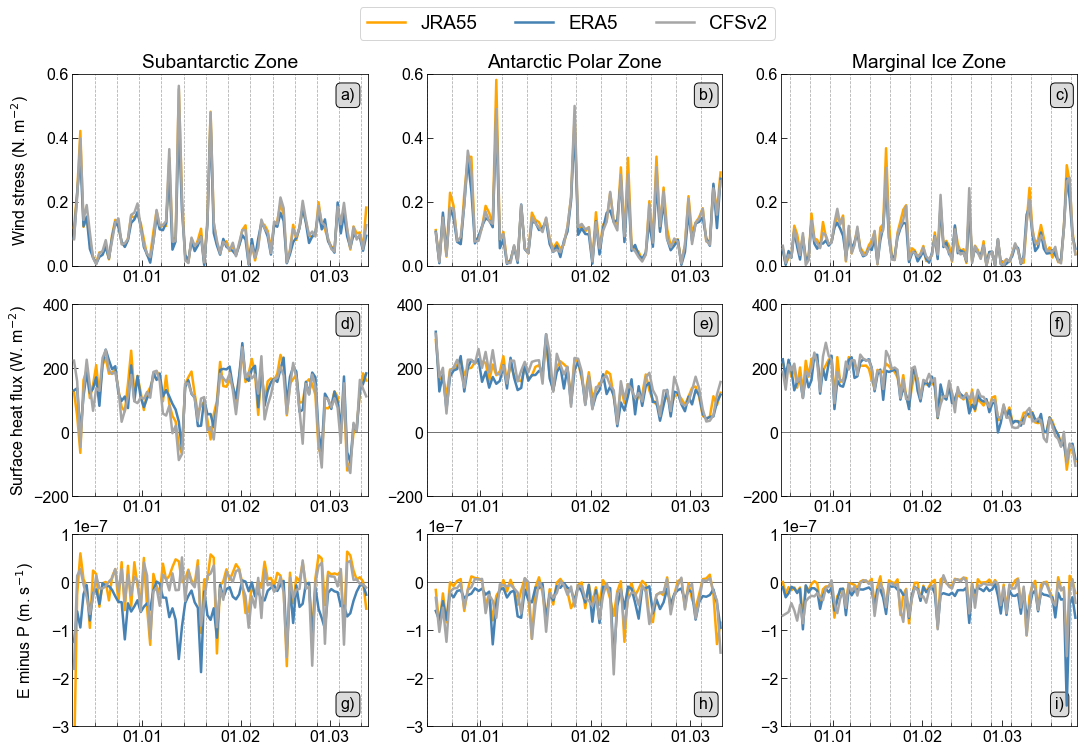

In [58]:
plt.rcParams['font.size'] = 16

fig, ax =subplots(3, 3, figsize=[18, 12])

# wind stress
ax[0, 0].plot(dat_saz_1D.time, dat_saz_1D['tau_jra55'], zorder=10, c='orange'   , label='JRA55')
ax[0, 0].plot(dat_saz_1D.time, dat_saz_1D['tau_era5' ], zorder=10, c='steelblue', label='ERA5')
ax[0, 0].plot(dat_saz_1D.time, dat_saz_1D['tau_cfsv2'], zorder=10, c='0.65'     , label='CFSv2')

ax[0, 1].plot(dat_apz_1D.time, dat_apz_1D['tau_jra55'], zorder=10, c='orange')
ax[0, 1].plot(dat_apz_1D.time, dat_apz_1D['tau_era5' ], zorder=10, c='steelblue')
ax[0, 1].plot(dat_apz_1D.time, dat_apz_1D['tau_cfsv2'], zorder=10, c='0.65')

ax[0, 2].plot(dat_miz_1D.time, dat_miz_1D['tau_jra55'], zorder=10, c='orange')
ax[0, 2].plot(dat_miz_1D.time, dat_miz_1D['tau_era5' ], zorder=10, c='steelblue')
ax[0, 2].plot(dat_miz_1D.time, dat_miz_1D['tau_cfsv2'], zorder=10, c='0.65')

# heat flux
ax[1, 0].plot(dat_saz_1D.time, dat_saz_1D['qnet_jra55'], zorder=10, c='orange')
ax[1, 0].plot(dat_saz_1D.time, dat_saz_1D['qnet_era5' ], zorder=10, c='steelblue')
ax[1, 0].plot(dat_saz_1D.time, dat_saz_1D['qnet_cfsv2'], zorder=10, c='0.65')

ax[1, 1].plot(dat_apz_1D.time, dat_apz_1D['qnet_jra55'], zorder=10, c='orange')
ax[1, 1].plot(dat_apz_1D.time, dat_apz_1D['qnet_era5' ], zorder=10, c='steelblue')
ax[1, 1].plot(dat_apz_1D.time, dat_apz_1D['qnet_cfsv2'], zorder=10, c='0.65')

ax[1, 2].plot(dat_miz_1D.time, dat_miz_1D['qnet_jra55'], zorder=10, c='orange')
ax[1, 2].plot(dat_miz_1D.time, dat_miz_1D['qnet_era5' ], zorder=10, c='steelblue')
ax[1, 2].plot(dat_miz_1D.time, dat_miz_1D['qnet_cfsv2'], zorder=10, c='0.65')

# evaporation minus precipitation
ax[2, 0].plot(dat_saz_1D.time, dat_saz_1D['e_minus_p_jra55'], zorder=10, c='orange')
ax[2, 0].plot(dat_saz_1D.time, dat_saz_1D['e_minus_p_era5' ], zorder=10, c='steelblue')
ax[2, 0].plot(dat_saz_1D.time, dat_saz_1D['e_minus_p_cfsv2'], zorder=10, c='0.65')

ax[2, 1].plot(dat_apz_1D.time, dat_apz_1D['e_minus_p_jra55'], zorder=10, c='orange')
ax[2, 1].plot(dat_apz_1D.time, dat_apz_1D['e_minus_p_era5' ], zorder=10, c='steelblue')
ax[2, 1].plot(dat_apz_1D.time, dat_apz_1D['e_minus_p_cfsv2'], zorder=10, c='0.65')

ax[2, 2].plot(dat_miz_1D.time, dat_miz_1D['e_minus_p_jra55'], zorder=10, c='orange')
ax[2, 2].plot(dat_miz_1D.time, dat_miz_1D['e_minus_p_era5' ], zorder=10, c='steelblue')
ax[2, 2].plot(dat_miz_1D.time, dat_miz_1D['e_minus_p_cfsv2'], zorder=10, c='0.65')

[a.set_ylim(0, 0.6) for a in ax[0]]
[a.set_ylim(-200, 400) for a in ax[1]]
[a.set_ylim(-3e-7, 1e-7) for a in ax[2]]



for i in range(3):
    for ii in range(3):

        ax[i,ii].xaxis.set_major_locator(months)
        ax[i,ii].xaxis.set_major_formatter(yearsFmt)
        ax[i,ii].xaxis.set_minor_locator(weeks)
        
        ax[i,ii].grid(ls='--', which='minor')


[a[0].plot([dat_saz_1D.time[0].values, dat_miz_1D.time[-1].values], [0, 0], c='0.45', zorder=2, lw=1) for a in ax]
[a[1].plot([dat_saz_1D.time[0].values, dat_miz_1D.time[-1].values], [0, 0], c='0.45', zorder=2, lw=1) for a in ax]
[a[2].plot([dat_saz_1D.time[0].values, dat_miz_1D.time[-1].values], [0, 0], c='0.45', zorder=2, lw=1) for a in ax]

ax[0,0].set_xlim('2018-12-10', '2019-03-13')
ax[1,0].set_xlim('2018-12-10', '2019-03-13')
ax[2,0].set_xlim('2018-12-10', '2019-03-13')

ax[0,1].set_xlim('2018-12-17', '2019-03-10')
ax[1,1].set_xlim('2018-12-17', '2019-03-10')
ax[2,1].set_xlim('2018-12-17', '2019-03-10')

ax[0,2].set_xlim('2018-12-14', '2019-03-27')
ax[1,2].set_xlim('2018-12-14', '2019-03-27')
ax[2,2].set_xlim('2018-12-14', '2019-03-27')


ax[0, 0].set_ylabel('Wind stress (N. m$^{-2}$)', labelpad=16)
ax[1, 0].set_ylabel('Surface heat flux (W. m$^{-2}$)')
ax[2, 0].set_ylabel('E minus P (m. s$^{-1}$)', labelpad=15)

props = dict(boxstyle='round', facecolor='0.85', alpha=0.95)

# place a text box in upper left in axes coords
ax[0, 0].text(dat_saz_1D.time.values[-9], 0.51,    'a)', verticalalignment='bottom', bbox=props)
ax[1, 0].text(dat_saz_1D.time.values[-9], 315,     'd)', verticalalignment='bottom', bbox=props)
ax[2, 0].text(dat_saz_1D.time.values[-9], -2.7e-7 ,'g)', verticalalignment='bottom', bbox=props)

# place a text box in upper left in a-xes coords
ax[0, 1].text(dat_apz_1D.time.values[-7], 0.51,    'b)', verticalalignment='bottom', bbox=props)
ax[1, 1].text(dat_apz_1D.time.values[-7], 315,     'e)', verticalalignment='bottom', bbox=props)
ax[2, 1].text(dat_apz_1D.time.values[-7], -2.7e-7 ,'h)', verticalalignment='bottom', bbox=props)

ax[0, 2].text(dat_miz_1D.time.values[-8], 0.51,    'c)', verticalalignment='bottom', bbox=props)
ax[1, 2].text(dat_miz_1D.time.values[-8], 315,     'f)', verticalalignment='bottom', bbox=props)
ax[2, 2].text(dat_miz_1D.time.values[-8], -2.7e-7 ,'i)', verticalalignment='bottom', bbox=props)

ax[0,0].legend(loc=2, ncol=3, bbox_to_anchor=(0.94, 1.4), prop={'size': 19})

ax[0,0].set_title('Subantarctic Zone')
ax[0,1].set_title('Antarctic Polar Zone')
ax[0,2].set_title('Marginal Ice Zone')

# fig.tight_layout()
savefig('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/figures/fig6_atm_vars.png', dpi=300, bbox_inches='tight')

Get nearest neighbour for the glider data

In [59]:
import gsw 

def nearest_ind(gl_lon, gl_lat, gl_time, var_lon, var_lat, var_time, var):
    
    gl_var = np.ndarray(len(gl_time))
    dist   = np.ndarray(len(gl_time))
    lon    = np.ndarray(len(gl_time))
    lat    = np.ndarray(len(gl_time))
    time_d = np.ndarray(len(gl_time))
    
    for i, val in enumerate(gl_time):
        
        idx_time = np.argmin(np.abs(gl_time[i] - var_time))
        idx_lon  = np.argmin(np.abs(gl_lon[i] - var_lon))
        idx_lat  = np.argmin(np.abs(gl_lat[i] - var_lat))
        
        gl_var[i] = var[idx_time, idx_lat, idx_lon]
        dist[i]   = gsw.distance([gl_lon[i], var_lon[idx_lon]], [gl_lat[i], var_lat[idx_lat]])
        lon[i]    = var_lon[idx_lon]
        lat[i]    = var_lat[idx_lat]
        time_d[i] = gl_time[i] - var_time[idx_time]
        
    return gl_var, dist, lon, lat, time_d
        

# Freshwater fluxes

Determine the freshwater fluxes

In [60]:
dat_saz_1D['fwf_era5'] = (('time'), freshwater_flux(dat_saz_1D.e_minus_p_era5, dat_saz_1D.ml_s, dat_saz_1D.mld))
dat_apz_1D['fwf_era5'] = (('time'), freshwater_flux(dat_apz_1D.e_minus_p_era5, dat_apz_1D.ml_s, dat_apz_1D.mld))
dat_miz_1D['fwf_era5'] = (('time'), freshwater_flux(dat_miz_1D.e_minus_p_era5, dat_miz_1D.ml_s, dat_miz_1D.mld))

dat_saz_1D['fwf_jra55'] = (('time'), freshwater_flux(dat_saz_1D.e_minus_p_jra55, dat_saz_1D.ml_s, dat_saz_1D.mld))
dat_apz_1D['fwf_jra55'] = (('time'), freshwater_flux(dat_apz_1D.e_minus_p_jra55, dat_apz_1D.ml_s, dat_apz_1D.mld))
dat_miz_1D['fwf_jra55'] = (('time'), freshwater_flux(dat_miz_1D.e_minus_p_jra55, dat_miz_1D.ml_s, dat_miz_1D.mld))

dat_saz_1D['fwf_cfsv2'] = (('time'), freshwater_flux(dat_saz_1D.e_minus_p_cfsv2, dat_saz_1D.ml_s, dat_saz_1D.mld))
dat_apz_1D['fwf_cfsv2'] = (('time'), freshwater_flux(dat_apz_1D.e_minus_p_cfsv2, dat_apz_1D.ml_s, dat_apz_1D.mld))
dat_miz_1D['fwf_cfsv2'] = (('time'), freshwater_flux(dat_miz_1D.e_minus_p_cfsv2, dat_miz_1D.ml_s, dat_miz_1D.mld))

### Freshwater fluxes mean, min and max calculations

In [62]:
dat_saz_1D['fwf_mean'] = ('time', (dat_saz_1D['fwf_era5']+dat_saz_1D['fwf_cfsv2']+dat_saz_1D['fwf_jra55'])/3)
dat_apz_1D['fwf_mean'] = ('time', (dat_apz_1D['fwf_era5']+dat_apz_1D['fwf_cfsv2']+dat_apz_1D['fwf_jra55'])/3)
dat_miz_1D['fwf_mean'] = ('time', (dat_miz_1D['fwf_era5']+dat_miz_1D['fwf_cfsv2']+dat_miz_1D['fwf_jra55'])/3)

def get_min_max(ds, var='fwf'):
    
    mins = np.ndarray(len(ds.time))
    maxs = np.ndarray(len(ds.time))

    for i in range(len(ds.time)):
        
        mins[i] = np.min([ds['fwf_era5'][i], ds['fwf_cfsv2'][i], ds['fwf_jra55'][i]])
        maxs[i] = np.max([ds['fwf_era5'][i], ds['fwf_cfsv2'][i], ds['fwf_jra55'][i]])
        
    ds[var+'_min'] = (('time'), mins)
    ds[var+'_max'] = (('time'), maxs)
    
    return ds

dat_saz_1D = get_min_max(dat_saz_1D, var='fwf')
dat_apz_1D = get_min_max(dat_apz_1D, var='fwf')
dat_miz_1D = get_min_max(dat_miz_1D, var='fwf')

### Heat fluxes mean, min and max

<center><h3>$Q_{net}$ / $\rho_0 c_p h_m$</h3></center>

In [63]:
def sfc_heat_forcing(ds):
    
    ds['shf_era5']  = 86400*ds.qnet_era5/(1025*3850*ds.mld)
    ds['shf_jra55'] = 86400*ds.qnet_jra55/(1025*3850*ds.mld)
    ds['shf_cfsv2'] = 86400*ds.qnet_cfsv2/(1025*3850*ds.mld)
    
    return ds

dat_saz_1D = sfc_heat_forcing(ds=dat_saz_1D)
dat_apz_1D = sfc_heat_forcing(ds=dat_apz_1D)
dat_miz_1D = sfc_heat_forcing(ds=dat_miz_1D)

In [64]:
dat_saz_1D['shf_mean'] = ('time', (dat_saz_1D['shf_era5']+dat_saz_1D['shf_cfsv2']+dat_saz_1D['shf_jra55'])/3)
dat_apz_1D['shf_mean'] = ('time', (dat_apz_1D['shf_era5']+dat_apz_1D['shf_cfsv2']+dat_apz_1D['shf_jra55'])/3)
dat_miz_1D['shf_mean'] = ('time', (dat_miz_1D['shf_era5']+dat_miz_1D['shf_cfsv2']+dat_miz_1D['shf_jra55'])/3)

def get_min_max(ds, var='shf'):
    
    mins = np.ndarray(len(ds.time))
    maxs = np.ndarray(len(ds.time))

    for i in range(len(ds.time)):
        
        mins[i] = np.min([ds[var+'_era5'][i], ds[var+'_cfsv2'][i], ds[var+'_jra55'][i]])
        maxs[i] = np.max([ds[var+'_era5'][i], ds[var+'_cfsv2'][i], ds[var+'_jra55'][i]])
        
    ds[var+'_min'] = (('time'), mins)
    ds[var+'_max'] = (('time'), maxs)
    
    return ds

dat_saz_1D = get_min_max(dat_saz_1D, var='shf')
dat_apz_1D = get_min_max(dat_apz_1D, var='shf')
dat_miz_1D = get_min_max(dat_miz_1D, var='shf')

## Ekman advection

In [65]:
def tau_sign_adjustment(ds):
    
    re = ['era5', 'cfsv2', 'jra55']
    
    for i, var in enumerate(re):
        
        print(i)

        ds['taux_'+var][ds['uwind_'+var].values<0] = -ds['taux_'+var][ds['uwind_'+var].values<0]
        ds['tauy_'+var][ds['vwind_'+var].values<0] = -ds['tauy_'+var][ds['vwind_'+var].values<0]
        
    return ds

dat_saz_1D = tau_sign_adjustment(dat_saz_1D)
dat_apz_1D = tau_sign_adjustment(dat_apz_1D)
dat_miz_1D = tau_sign_adjustment(dat_miz_1D)

0
1
2
0
1
2
0
1
2


Calculate Ekman advection

In [67]:
dat_saz_1D = ekman_advection(ds=dat_saz_1D, grady='EN4_dSdy', gradx='EN4_dSdx', rho0=1025, f=gsw.f(-43), which='ek_adv_S')
dat_saz_1D = ekman_advection(ds=dat_saz_1D, grady='EN4_dTdy', gradx='EN4_dTdx', rho0=1025, f=gsw.f(-43), which='ek_adv_T')

dat_apz_1D = ekman_advection(ds=dat_apz_1D, grady='EN4_dSdy', gradx='EN4_dSdx', rho0=1025, f=gsw.f(-54), which='ek_adv_S')
dat_apz_1D = ekman_advection(ds=dat_apz_1D, grady='EN4_dTdy', gradx='EN4_dTdx', rho0=1025, f=gsw.f(-54), which='ek_adv_T')

dat_miz_1D = ekman_advection(ds=dat_miz_1D, grady='SB_dSdy', gradx='SB_dSdy', rho0=1025, f=gsw.f(-60), which='ek_adv_S')
dat_miz_1D = ekman_advection(ds=dat_miz_1D, grady='SB_dTdy', gradx='SB_dTdy', rho0=1025, f=gsw.f(-60), which='ek_adv_T')

In [68]:
def net_ek_adv(ds):
    
    re = ['era5', 'cfsv2', 'jra55']
    
    for i, var in enumerate(re):
        
        ds['ek_adv_S_'+str(var)] = ds['ek_adv_Su_'+str(var)] + ds['ek_adv_Sv_'+str(var)]
        ds['ek_adv_T_'+str(var)] = ds['ek_adv_Tu_'+str(var)] + ds['ek_adv_Tv_'+str(var)]
        
    return ds

dat_saz_1D = net_ek_adv(dat_saz_1D)
dat_apz_1D = net_ek_adv(dat_apz_1D)
dat_miz_1D = net_ek_adv(dat_miz_1D)

In [69]:
dat_saz_1D['ek_adv_S_mean'] = ('time', (dat_saz_1D['ek_adv_S_era5']+dat_saz_1D['ek_adv_S_cfsv2']+dat_saz_1D['ek_adv_S_jra55'])/3)
dat_apz_1D['ek_adv_S_mean'] = ('time', (dat_apz_1D['ek_adv_S_era5']+dat_apz_1D['ek_adv_S_cfsv2']+dat_apz_1D['ek_adv_S_jra55'])/3)
dat_miz_1D['ek_adv_S_mean'] = ('time', (dat_miz_1D['ek_adv_S_era5']+dat_miz_1D['ek_adv_S_cfsv2']+dat_miz_1D['ek_adv_S_jra55'])/3)

dat_saz_1D = get_min_max(dat_saz_1D, var='ek_adv_S')
dat_apz_1D = get_min_max(dat_apz_1D, var='ek_adv_S')
dat_miz_1D = get_min_max(dat_miz_1D, var='ek_adv_S')

dat_saz_1D['ek_adv_T_mean'] = ('time', (dat_saz_1D['ek_adv_T_era5']+dat_saz_1D['ek_adv_T_cfsv2']+dat_saz_1D['ek_adv_T_jra55'])/3)
dat_apz_1D['ek_adv_T_mean'] = ('time', (dat_apz_1D['ek_adv_T_era5']+dat_apz_1D['ek_adv_T_cfsv2']+dat_apz_1D['ek_adv_T_jra55'])/3)
dat_miz_1D['ek_adv_T_mean'] = ('time', (dat_miz_1D['ek_adv_T_era5']+dat_miz_1D['ek_adv_T_cfsv2']+dat_miz_1D['ek_adv_T_jra55'])/3)

dat_saz_1D = get_min_max(dat_saz_1D, var='ek_adv_T')
dat_apz_1D = get_min_max(dat_apz_1D, var='ek_adv_T')
dat_miz_1D = get_min_max(dat_miz_1D, var='ek_adv_T')

## Figure

In [70]:
# x = dat_miz_1D.ek_adv_Sy.cumsum()+dat_miz_1D.ek_adv_Sx.cumsum()
# y = dat_miz_1D.ml_s_anom-dat_miz_1D.ml_s_anom[0]

# correlation_matrix = np.corrcoef(x, y)
# correlation_xy = correlation_matrix[0,1]
# correlation_xy

## Geostrophic advection

Calculate geostrophic advection

## Entrainment

### Save data

### Diffusion

In [86]:
for i, val in enumerate([500, 10000]):
    
    dat_saz_1D['diff_T_'+str(val)] = (('time'), (dat_saz_1D.EN4_dTdy.values*val)/dat_saz_1D.mld)
    dat_saz_1D['diff_S_'+str(val)] = (('time'), (dat_saz_1D.EN4_dSdy.values*val)/dat_saz_1D.mld)
    
    dat_apz_1D['diff_T_'+str(val)] = (('time'), (dat_apz_1D.EN4_dTdy.values*val)/dat_apz_1D.mld)
    dat_apz_1D['diff_S_'+str(val)] = (('time'), (dat_apz_1D.EN4_dSdy.values*val)/dat_apz_1D.mld)
    
    dat_miz_1D['diff_T_'+str(val)] = (('time'), (dat_miz_1D.SB_dTdy.values*val)/dat_miz_1D.mld)
    dat_miz_1D['diff_S_'+str(val)] = (('time'), (dat_miz_1D.SB_dSdy.values*val)/dat_miz_1D.mld)

### Mixed layer tendency budget plot

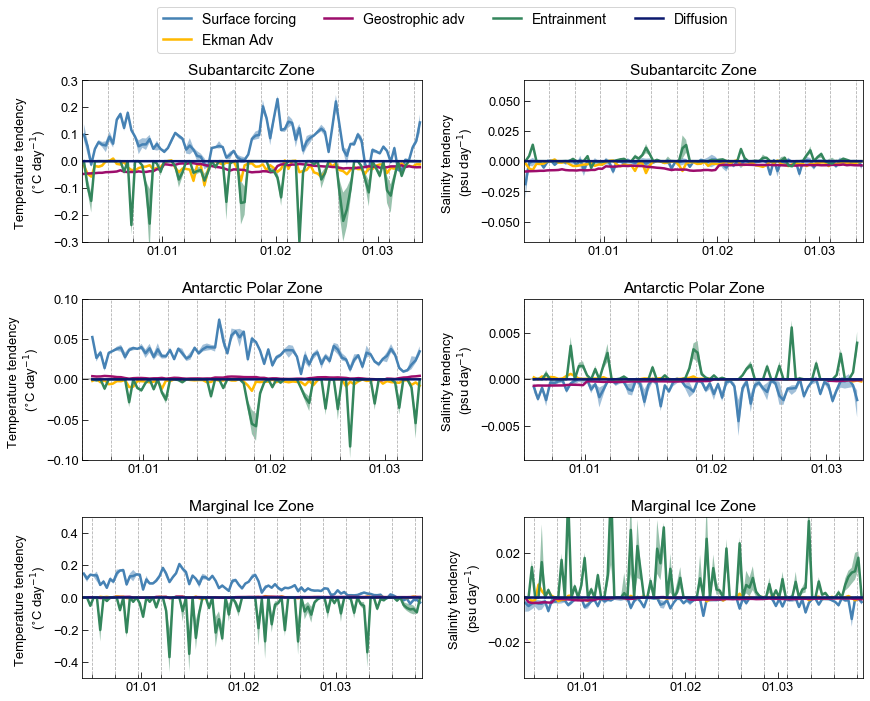

### Combine all the terms

In [380]:
dat_saz_1D['all_terms_t'] = (('time'), dat_saz_1D.shf_mean+dat_saz_1D.ek_adv_T_mean+dat_saz_1D.ent_t+dat_saz_1D.geo_adv_T_total)
dat_apz_1D['all_terms_t'] = (('time'), dat_apz_1D.shf_mean+dat_apz_1D.ek_adv_T_mean+dat_apz_1D.ent_t+dat_apz_1D.geo_adv_T_total)
dat_miz_1D['all_terms_t'] = (('time'), dat_miz_1D.shf_mean+dat_miz_1D.ek_adv_T_mean+dat_miz_1D.ent_t+dat_miz_1D.geo_adv_T_total)

dat_saz_1D['all_terms_s'] = (('time'), dat_saz_1D.fwf_mean+dat_saz_1D.ek_adv_S_mean+dat_saz_1D.ent_s+dat_saz_1D.geo_adv_S_total)
dat_apz_1D['all_terms_s'] = (('time'), dat_apz_1D.fwf_mean+dat_apz_1D.ek_adv_S_mean+dat_apz_1D.ent_s+dat_apz_1D.geo_adv_S_total)
dat_miz_1D['all_terms_s'] = (('time'), dat_miz_1D.fwf_mean+dat_miz_1D.ek_adv_S_mean+dat_miz_1D.ent_s+dat_miz_1D.geo_adv_S_total)

In [382]:
print((0.8*gsw.alpha(34, 10, 0))/gsw.beta(34, 10, 0))
print((0.8*gsw.alpha(33.9, 2, 0))/gsw.beta(33.9, 2, 0))
print((0.8*gsw.alpha(33.9, 0.5, 0))/gsw.beta(33.9, 0.5, 0))

0.17381662699387038
0.07701209925916673
0.05711640782841877


In [383]:
dat_saz_1D['terms_displacement_s'] = (('time'), dat_saz_1D.all_terms_s+dat_saz_1D.dS_glider_displacement)
dat_apz_1D['terms_displacement_s'] = (('time'), dat_apz_1D.all_terms_s+dat_apz_1D.dS_glider_displacement)
dat_miz_1D['terms_displacement_s'] = (('time'), dat_miz_1D.all_terms_s+dat_miz_1D.dS_glider_displacement)

dat_saz_1D['terms_displacement_t'] = (('time'), dat_saz_1D.all_terms_t+dat_saz_1D.dT_glider_displacement)
dat_apz_1D['terms_displacement_t'] = (('time'), dat_apz_1D.all_terms_t+dat_apz_1D.dT_glider_displacement)
dat_miz_1D['terms_displacement_t'] = (('time'), dat_miz_1D.all_terms_t+dat_miz_1D.dT_glider_displacement)

### Figure: All terms + Glider displacement & Observations

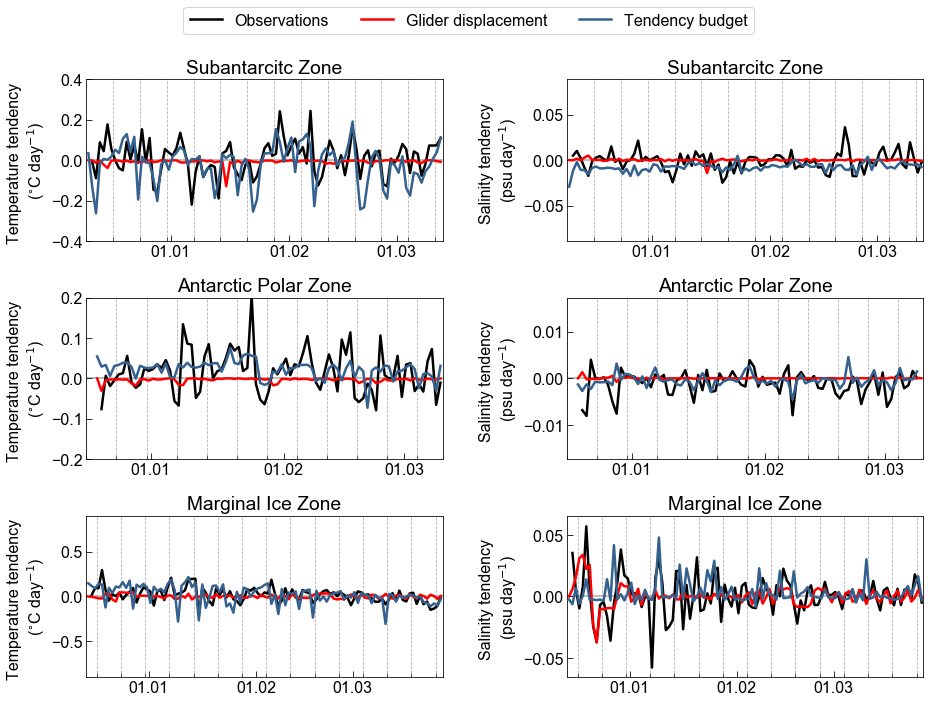

In [384]:
plt.rcParams['font.size'] = 16

fig, ax = subplots(3, 2, figsize=[15, 11])
fig.subplots_adjust(wspace=0.35, hspace=0.35)

ax[0,0].plot(dat_saz_1D.time[1:], np.diff(dat_saz_1D.ml_t), c='k', label='Observations')
ax[1,0].plot(dat_apz_1D.time[1:], np.diff(dat_apz_1D.ml_t), c='k', label='Observations')
ax[2,0].plot(dat_miz_1D.time[1:], np.diff(dat_miz_1D.ml_t), c='k', label='Observations')

ax[0,1].plot(dat_saz_1D.time[1:], np.diff(dat_saz_1D.ml_s), c='k', label='Observations')
ax[1,1].plot(dat_apz_1D.time[1:], np.diff(dat_apz_1D.ml_s), c='k', label='Observations')
ax[2,1].plot(dat_miz_1D.time[1:], np.diff(dat_miz_1D.ml_s), c='k', label='Observations')

# glider displacement 

ax[0,0].plot(dat_saz_1D.time, dat_saz_1D.dT_glider_displacement, c='r', label='Glider displacement')
ax[1,0].plot(dat_apz_1D.time, dat_apz_1D.dT_glider_displacement, c='r', label='Glider displacement')
ax[2,0].plot(dat_miz_1D.time, dat_miz_1D.dT_glider_displacement, c='r', label='Glider displacement')

ax[0,1].plot(dat_saz_1D.time, dat_saz_1D.dS_glider_displacement, c='r', label='Glider displacement')
ax[1,1].plot(dat_apz_1D.time, dat_apz_1D.dS_glider_displacement, c='r', label='Glider displacement')
ax[2,1].plot(dat_miz_1D.time, dat_miz_1D.dS_glider_displacement, c='r', label='Glider displacement')

# glider displacement 

ax[0,0].plot(dat_saz_1D.time, dat_saz_1D.all_terms_t, c=my_clrs[1], label='Tendency budget')
ax[1,0].plot(dat_apz_1D.time, dat_apz_1D.all_terms_t, c=my_clrs[1], label='Tendency budget')
ax[2,0].plot(dat_miz_1D.time, dat_miz_1D.all_terms_t, c=my_clrs[1], label='Tendency budget')

ax[0,1].plot(dat_saz_1D.time, dat_saz_1D.all_terms_s, c=my_clrs[1], label='Tendency budget')
ax[1,1].plot(dat_apz_1D.time, dat_apz_1D.all_terms_s, c=my_clrs[1], label='Tendency budget')
ax[2,1].plot(dat_miz_1D.time, dat_miz_1D.all_terms_s, c=my_clrs[1], label='Tendency budget')


# figure modifying
for i in range(3):
    
    ax[i,0].set_ylabel('Temperature tendency \n($^{\circ}$C day$^{-1}$)')
    ax[i,1].set_ylabel('Salinity tendency \n(psu day$^{-1}$)')
    
    for ii in range(2):
        
        ax[i,ii].xaxis.set_major_locator(months)
        ax[i,ii].xaxis.set_major_formatter(yearsFmt)
        ax[i,ii].xaxis.set_minor_locator(weeks)
        
        ax[i,ii].grid(ls='--', which='minor')
        ax[i,ii].plot([dat_saz_1D.time[0].values, dat_miz_1D.time[-1].values], [0, 0], c='0.75', zorder=0, lw=2)

        ax[0,ii].set_xlim('2018-12-10', '2019-03-13')
        ax[1,ii].set_xlim('2018-12-17', '2019-03-10')
        ax[2,ii].set_xlim('2018-12-14', '2019-03-27')
        
ax[0,0].set_title('Subantarcitc Zone')
ax[0,1].set_title('Subantarcitc Zone')
ax[1,0].set_title('Antarctic Polar Zone')
ax[1,1].set_title('Antarctic Polar Zone')
ax[2,0].set_title('Marginal Ice Zone')
ax[2,1].set_title('Marginal Ice Zone')

ax[0, 0].legend(loc=2, ncol=4, bbox_to_anchor=(0.25, 1.5), prop={'size': 16})

ax[0,0].set_ylim(-0.40, 0.40)
ax[1,0].set_ylim(-0.20, 0.20)
ax[2,0].set_ylim(-0.90, 0.90)

ds_saz = (0.8*gsw.alpha(dat_saz_1D.ml_s.mean(), dat_saz_1D.ml_t.mean(), 0))/gsw.beta(dat_saz_1D.ml_s.mean(), dat_saz_1D.ml_t.mean(), 0)
ds_apz = (0.4*gsw.alpha(dat_apz_1D.ml_s.mean(), dat_apz_1D.ml_t.mean(), 0))/gsw.beta(dat_apz_1D.ml_s.mean(), dat_apz_1D.ml_t.mean(), 0)
ds_miz = (1.8*gsw.alpha(dat_miz_1D.ml_s.mean(), dat_miz_1D.ml_t.mean(), 0))/gsw.beta(dat_miz_1D.ml_s.mean(), dat_miz_1D.ml_t.mean(), 0)

ax[0,1].set_ylim(-(ds_saz/2), -(ds_saz/2)+ds_saz)
ax[1,1].set_ylim(-(ds_apz/2), -(ds_apz/2)+ds_apz)
ax[2,1].set_ylim(-(ds_miz/2), -(ds_miz/2)+ds_miz)

savefig('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/figures/fig8_disp_tendency.png', dpi=300, bbox_inches='tight')

In [ ]:
gsw.rho_alpha_beta

# Buoyancy fluxes

In [115]:
dat_saz_1D['dens_data'] = (('time'), gsw.rho(dat_saz_1D.ml_s, dat_saz_1D.ml_t, 0))
dat_apz_1D['dens_data'] = (('time'), gsw.rho(dat_apz_1D.ml_s, dat_apz_1D.ml_t, 0))
dat_miz_1D['dens_data'] = (('time'), gsw.rho(dat_miz_1D.ml_s, dat_miz_1D.ml_t, 0))

dat_saz_1D['dens_expl'] = (('time'), gsw.rho(dat_saz_1D.terms_displacement_s.cumsum()+dat_saz_1D.ml_s[0], dat_saz_1D.terms_displacement_t.cumsum()+dat_saz_1D.ml_t[0], 0))
dat_apz_1D['dens_expl'] = (('time'), gsw.rho(dat_apz_1D.terms_displacement_s.cumsum()+dat_apz_1D.ml_s[0], dat_apz_1D.terms_displacement_t.cumsum()+dat_apz_1D.ml_t[0], 0))
dat_miz_1D['dens_expl'] = (('time'), gsw.rho(dat_miz_1D.terms_displacement_s.cumsum()+dat_miz_1D.ml_s[0], dat_miz_1D.terms_displacement_t.cumsum()+dat_miz_1D.ml_t[0], 0))

dat_saz_1D['dens_terms'] = (('time'), gsw.rho(dat_saz_1D.all_terms_s.cumsum()+dat_saz_1D.ml_s[0], dat_saz_1D.all_terms_t.cumsum()+dat_saz_1D.ml_t[0], 0))
dat_apz_1D['dens_terms'] = (('time'), gsw.rho(dat_apz_1D.all_terms_s.cumsum()+dat_apz_1D.ml_s[0], dat_apz_1D.all_terms_t.cumsum()+dat_apz_1D.ml_t[0], 0))
dat_miz_1D['dens_terms'] = (('time'), gsw.rho(dat_miz_1D.all_terms_s.cumsum()+dat_miz_1D.ml_s[0], dat_miz_1D.all_terms_t.cumsum()+dat_miz_1D.ml_t[0], 0))

# buoyancy
dat_saz_1D['buoy_data'] = (('time'), -9.81*(dat_saz_1D.dens_data-1027)/1027)
dat_apz_1D['buoy_data'] = (('time'), -9.81*(dat_apz_1D.dens_data-1027)/1027)
dat_miz_1D['buoy_data'] = (('time'), -9.81*(dat_miz_1D.dens_data-1027)/1027)

dat_saz_1D['buoy_expl'] = (('time'), -9.81*(dat_saz_1D.dens_expl-1027)/1027)
dat_apz_1D['buoy_expl'] = (('time'), -9.81*(dat_apz_1D.dens_expl-1027)/1027)
dat_miz_1D['buoy_expl'] = (('time'), -9.81*(dat_miz_1D.dens_expl-1027)/1027)

dat_saz_1D['buoy_terms'] = (('time'), -9.81*(dat_saz_1D.dens_terms-1027)/1027)
dat_apz_1D['buoy_terms'] = (('time'), -9.81*(dat_apz_1D.dens_terms-1027)/1027)
dat_miz_1D['buoy_terms'] = (('time'), -9.81*(dat_miz_1D.dens_terms-1027)/1027)

# buoyancy fluxes
dat_saz_1D['bflux_data'] = (('time'), np.append(0, -9.81 * (np.diff(dat_saz_1D.dens_data)*dat_saz_1D.mld[1:]/86400)/1027))
dat_apz_1D['bflux_data'] = (('time'), np.append(0, -9.81 * (np.diff(dat_apz_1D.dens_data)*dat_apz_1D.mld[1:]/86400)/1027))
dat_miz_1D['bflux_data'] = (('time'), np.append(0, -9.81 * (np.diff(dat_miz_1D.dens_data)*dat_miz_1D.mld[1:]/86400)/1027))

dat_saz_1D['bflux_expl'] = (('time'), np.append(0, -9.81 * (np.diff(dat_saz_1D.dens_expl)*dat_saz_1D.mld[1:]/86400)/1027))
dat_apz_1D['bflux_expl'] = (('time'), np.append(0, -9.81 * (np.diff(dat_apz_1D.dens_expl)*dat_apz_1D.mld[1:]/86400)/1027))
dat_miz_1D['bflux_expl'] = (('time'), np.append(0, -9.81 * (np.diff(dat_miz_1D.dens_expl)*dat_miz_1D.mld[1:]/86400)/1027))

dat_saz_1D['bflux_terms'] = (('time'), np.append(0, -9.81 * (np.diff(dat_saz_1D.dens_terms)*dat_saz_1D.mld[1:]/86400)/1027))
dat_apz_1D['bflux_terms'] = (('time'), np.append(0, -9.81 * (np.diff(dat_apz_1D.dens_terms)*dat_apz_1D.mld[1:]/86400)/1027))
dat_miz_1D['bflux_terms'] = (('time'), np.append(0, -9.81 * (np.diff(dat_miz_1D.dens_terms)*dat_miz_1D.mld[1:]/86400)/1027))

### Plotting 

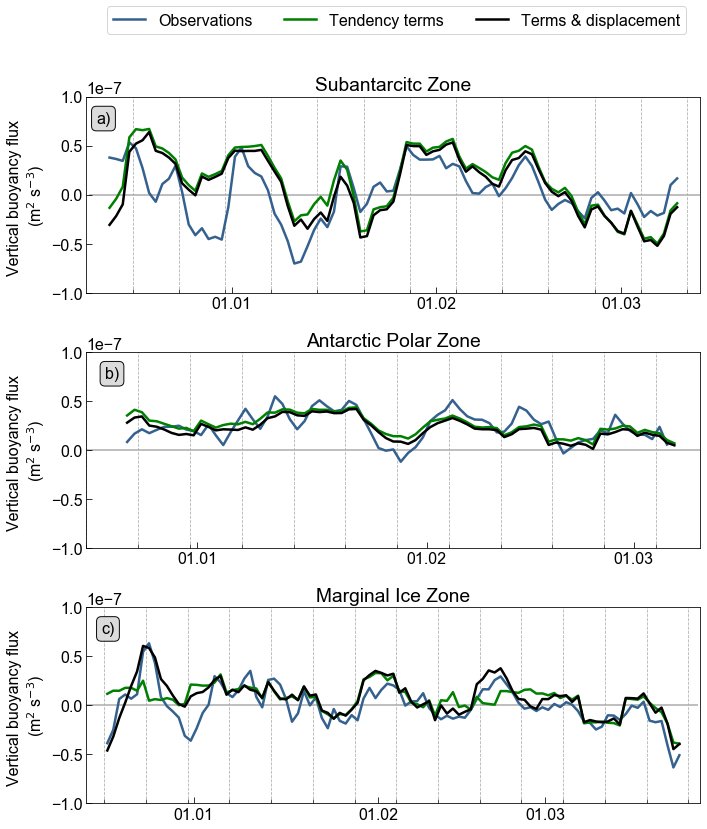

In [403]:
plt.rcParams['font.size'] = 16

fig, ax = subplots(3, figsize=[11, 13])
fig.subplots_adjust(hspace=0.3)

ax[0].plot(dat_saz_1D.time, dat_saz_1D.bflux_data .rolling(time=7, center=True).mean(), c=my_clrs[1], label='Observations')
ax[1].plot(dat_apz_1D.time, dat_apz_1D.bflux_data .rolling(time=7, center=True).mean(), c=my_clrs[1], label='Observations')
ax[2].plot(dat_miz_1D.time, dat_miz_1D.bflux_data .rolling(time=7, center=True).mean(), c=my_clrs[1], label='Observations')


# glider budget 

ax[0].plot(dat_saz_1D.time, dat_saz_1D.bflux_terms.rolling(time=7, center=True).mean(), c='g', label='Tendency terms')
ax[1].plot(dat_apz_1D.time, dat_apz_1D.bflux_terms.rolling(time=7, center=True).mean(), c='g', label='Tendency terms')
ax[2].plot(dat_miz_1D.time, dat_miz_1D.bflux_terms.rolling(time=7, center=True).mean(), c='g', label='Tendency terms')

# glider displacement 

ax[0].plot(dat_saz_1D.time, dat_saz_1D.bflux_expl .rolling(time=7, center=True).mean(), c='k', label='Terms & displacement')
ax[1].plot(dat_apz_1D.time, dat_apz_1D.bflux_expl .rolling(time=7, center=True).mean(), c='k', label='Terms & displacement')
ax[2].plot(dat_miz_1D.time, dat_miz_1D.bflux_expl .rolling(time=7, center=True).mean(), c='k', label='Terms & displacement')


# figure modifying
for i in range(3):
        
    ax[i].xaxis.set_major_locator(months)
    ax[i].xaxis.set_major_formatter(yearsFmt)
    ax[i].xaxis.set_minor_locator(weeks)
    
    ax[i].grid(ls='--', which='minor')
    ax[i].plot([dat_saz_1D.time[0].values, dat_miz_1D.time[-1].values], [0, 0], c='0.75', zorder=0, lw=2)

        
ax[0].set_title('Subantarcitc Zone')
ax[1].set_title('Antarctic Polar Zone')
ax[2].set_title('Marginal Ice Zone')
           
ax[0].set_xlim('2018-12-10', '2019-03-13')
ax[1].set_xlim('2018-12-17', '2019-03-10')
ax[2].set_xlim('2018-12-14', '2019-03-27')
           
[a.set_ylim(-1e-7, 1e-7) for a in ax]
# [a.set_xlim('2018-12-15', '2019-03-26') for a in ax]
# [a.grid(ls='--', c='0.85') for a in ax]
[a.set_ylabel('Vertical buoyancy flux \n(m$^2$ s$^{-3}$)') for a in ax]

ax[0].legend(loc=2, ncol=4, bbox_to_anchor=(0.02, 1.5), prop={'size': 16})

props = dict(boxstyle='round', facecolor='0.85', alpha=0.95)
ax[0].text(dat_saz_1D.time[1].values, 0.7e-7, 'a)', verticalalignment='bottom', bbox=props)
ax[1].text(dat_apz_1D.time[0].values, 0.7e-7, 'b)', verticalalignment='bottom', bbox=props)
ax[2].text(dat_miz_1D.time[2].values, 0.7e-7, 'c)', verticalalignment='bottom', bbox=props)

savefig('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/figures/fig8_disp_tendency.png', dpi=300, bbox_inches='tight')

In [134]:
def corr_analysis(ds, x_var, y_var):
    
    x = ds[x_var]
    y = ds[y_var]

    correlation_matrix = np.corrcoef(x, y)
    correlation_xy = correlation_matrix[0,1]
    print(correlation_xy)
    
    return 

In [136]:
corr_analysis(dat_saz_1D, 'bflux_data', 'bflux_terms')
corr_analysis(dat_apz_1D, 'bflux_data', 'bflux_terms')
corr_analysis(dat_miz_1D, 'bflux_data', 'bflux_terms')

0.642864226107015
nan
0.33267446271039086


In [140]:
corr_analysis(dat_saz_1D, 'bflux_data', 'bflux_expl')
corr_analysis(dat_apz_1D, 'bflux_data', 'bflux_expl')
corr_analysis(dat_miz_1D, 'bflux_data', 'bflux_expl')

0.6023652551415346
nan
0.5145759043730671


In [269]:
x = dat_saz_1D.N2_iso.rolling(time=7, center=True).mean()

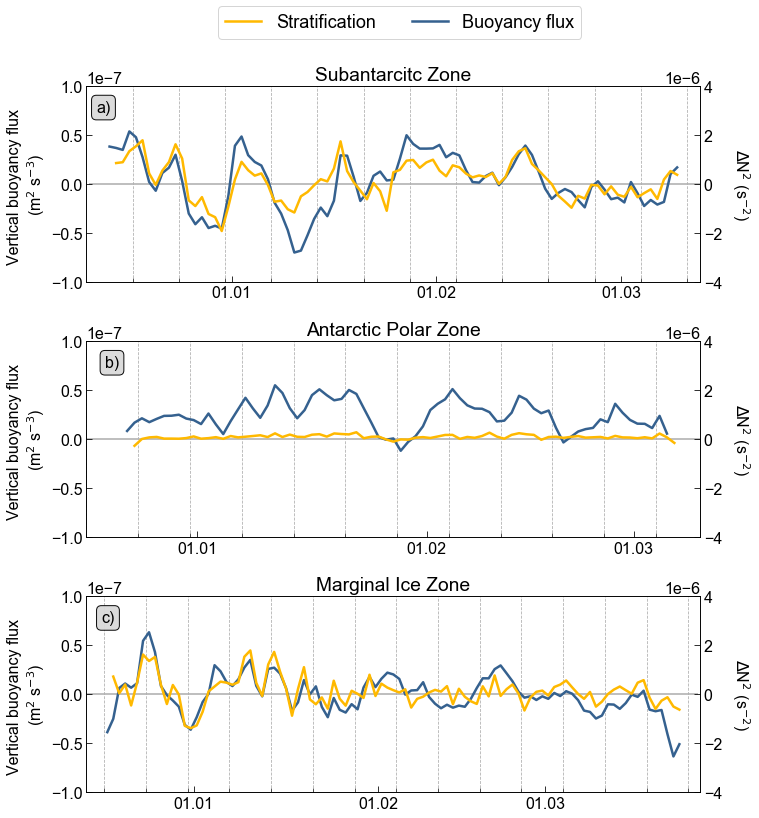

In [305]:
plt.rcParams['font.size'] = 16

fig, ax = subplots(3, figsize=[11, 13])
fig.subplots_adjust(hspace=0.3)

ax[0].plot(dat_saz_1D_rol.time.values, dat_saz_1D.N2_iso    , c=my_clrs[0], label='Stratification')
ax[0].plot(dat_saz_1D_rol.time.values, dat_saz_1D.bflux_data.rolling(time=7, center=True).mean(), c=my_clrs[1], label='Buoyancy flux')

ax0 = ax[0].twinx()
ax0.plot(dat_saz_1D_rol.time.values[1:], np.diff(dat_saz_1D.N2_iso.rolling(time=7, center=True).mean()), c=my_clrs[0])

                               
# apz
ax[1].plot(dat_apz_1D.time.values, dat_apz_1D.bflux_data.rolling(time=7, center=True).mean(), c=my_clrs[1], label='Observations')

ax1 = ax[1].twinx()
ax1.plot(dat_apz_1D.time.values[1:], np.diff(dat_apz_1D.N2_iso.rolling(time=7, center=True).mean()), c=my_clrs[0])

# miz
ax[2].plot(dat_miz_1D.time.values, dat_miz_1D.bflux_data.rolling(time=7, center=True).mean(), c=my_clrs[1], label='Observations')

ax2 = ax[2].twinx()
ax2.plot(dat_miz_1D.time.values[1:], np.diff(dat_miz_1D.N2_iso.rolling(time=7, center=True).mean()), c=my_clrs[0])

[a.ticklabel_format(style='sci',scilimits=(-3,4),axis='y') for a in [ax0, ax1, ax2]]
[a.set_ylabel('$\Delta $N$^2$ (s$^{-2}$)', rotation=-90, labelpad=30) for a in [ax0, ax1, ax2]]
[a.set_ylabel('Vertical buoyancy flux \n(m$^2$ s$^{-3}$)') for a in ax]


ax[0].set_xlim('2018-12-10', '2019-03-13')
ax[1].set_xlim('2018-12-17', '2019-03-10')
ax[2].set_xlim('2018-12-14', '2019-03-27')

for i in range(3):
        
    ax[i].xaxis.set_major_locator(months)
    ax[i].xaxis.set_major_formatter(yearsFmt)
    ax[i].xaxis.set_minor_locator(weeks)
    
    ax[i].grid(ls='--', which='minor')
    ax[i].plot([dat_saz_1D.time[0].values, dat_miz_1D.time[-1].values], [0, 0], c='0.75', zorder=0, lw=2)
    
props = dict(boxstyle='round', facecolor='0.85', alpha=0.95)

ax[0].text(dat_saz_1D.time[1].values, 0.7e-7, 'a)', verticalalignment='bottom', bbox=props)
ax[1].text(dat_apz_1D.time[0].values, 0.7e-7, 'b)', verticalalignment='bottom', bbox=props)
ax[2].text(dat_miz_1D.time[2].values, 0.7e-7, 'c)', verticalalignment='bottom', bbox=props)

ax[0].set_title('Subantarcitc Zone')
ax[1].set_title('Antarctic Polar Zone')
ax[2].set_title('Marginal Ice Zone')

ax[0].legend(loc=2, ncol=4, bbox_to_anchor=(0.2, 1.45), prop={'size': 18})

ax0.set_ylim(-0.4e-5, 0.4e-5)
ax1.set_ylim(-0.4e-5, 0.4e-5)
ax2.set_ylim(-0.4e-5, 0.4e-5)

[a.set_ylim(-1e-7, 1e-7) for a in ax]


savefig('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/figures/fig4_bflux_N2.png', dpi=300, bbox_inches='tight')

### Diffusion

In [411]:
def diffusion(data, centre_lat, centre_lon, kappa=500):
    
    dTdy1  = (data.temperature.sel(lat=centre_lat, lon=centre_lon)-data.temperature.sel(lat=centre_lat-1, lon=centre_lon)).values / gsw.distance([centre_lon, centre_lon], [centre_lat, centre_lat-1])
    dTdy2  = (data.temperature.sel(lat=centre_lat, lon=centre_lon)-data.temperature.sel(lat=centre_lat+1, lon=centre_lon)).values / gsw.distance([centre_lon, centre_lon], [centre_lat, centre_lat+1])
    d2Tdy2 = (dTdy1-dTdy2)/gsw.distance([centre_lon, centre_lon], [centre_lat-0.5, centre_lat+0.5])
    
    K2dT_y = d2Tdy2*kappa
    
    dTdx1  = (data.temperature.sel(lat=centre_lat, lon=centre_lon)-data.temperature.sel(lat=centre_lat, lon=centre_lon-1)).values / gsw.distance([centre_lon, centre_lon-1], [centre_lat, centre_lat])
    dTdx2  = (data.temperature.sel(lat=centre_lat, lon=centre_lon)-data.temperature.sel(lat=centre_lat, lon=centre_lon+1)).values / gsw.distance([centre_lon, centre_lon+1], [centre_lat, centre_lat])
    d2Tdx2 = (dTdx1-dTdx2)/gsw.distance([centre_lon-0.5, centre_lon+0.5], [centre_lat, centre_lat])
    
    K2dT_x = d2Tdx2*kappa
    
    K2dT = K2dT_x+K2dT_y
    
    return K2dT
    

In [58]:
Kd2T_saz = diffusion(EN4, centre_lat=-43, centre_lon=8)

/Users/marcel/anaconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/marcel/anaconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/marcel/anaconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/marcel/anaconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/marcel/anaconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/marcel/anaconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.div

In [247]:
dat_saz_1D['tau'] = (('time'), np.sqrt(dat_saz_1D.taux**2 + dat_saz_1D.tauy**2))
dat_apz_1D['tau'] = (('time'), np.sqrt(dat_apz_1D.taux**2 + dat_apz_1D.tauy**2))
dat_miz_1D['tau'] = (('time'), np.sqrt(dat_miz_1D.taux**2 + dat_miz_1D.tauy**2))

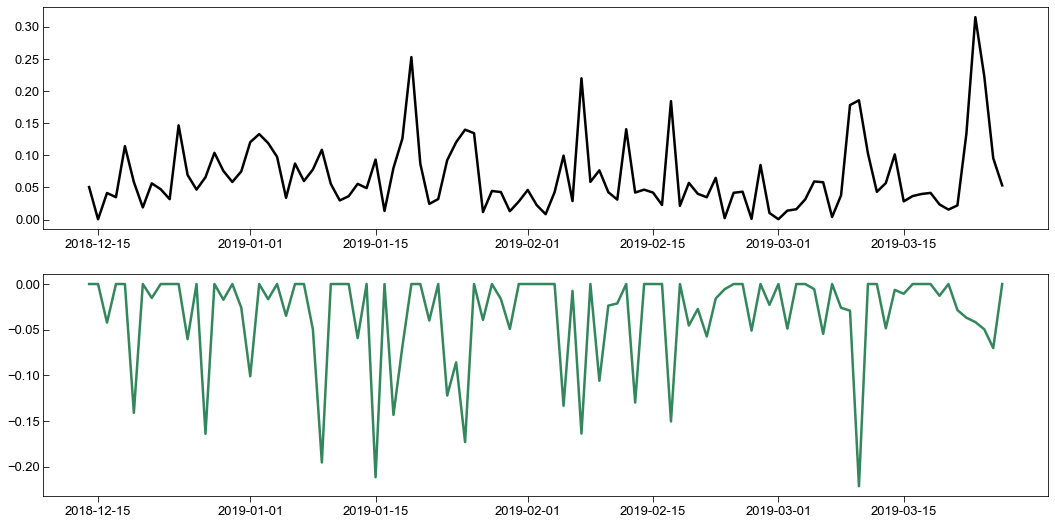

In [248]:
fig, ax =subplots(2, )

ax[0].plot(dat_miz_1D.time, dat_miz_1D.tau,   c='k',        label='Wind stress')
ax[1].plot(dat_miz_1D.time, dat_miz_1D.ent_t, c=my_clrs[3], label='Entrainment')


Correlation of all terms

In [109]:
data = dat_apz_1D

In [110]:
x = data.all_terms_t[1:]
y = np.diff(data.ml_t)

correlation_matrix = np.corrcoef(x, y)
correlation_xy = correlation_matrix[0,1]
print('all terms vs dT: '+str(correlation_xy))

all terms vs dT: 0.323498725554225


In [111]:
x = data.dT_glider_displacement[1:]
y = np.diff(data.ml_t)

correlation_matrix = np.corrcoef(x, y)
correlation_xy = correlation_matrix[0,1]
correlation_xy
print('glider displacement vs dT: '+str(correlation_xy))

glider displacement vs dT: 0.24825194687114197


In [112]:
x = data.terms_displacement_t[1:]
y = np.diff(data.ml_t)

correlation_matrix = np.corrcoef(x, y)
correlation_xy = correlation_matrix[0,1]
print('all terms + glider displacement vs dT: '+str(correlation_xy))

all terms + glider displacement vs dT: 0.37915558786105746


In [276]:
x=dat_apz_1D.bflux_data
y=dat_apz_1D.bflux_expl

correlation_matrix = np.corrcoef(x, y)
correlation_xy = correlation_matrix[0,1]
print('all terms + glider displacement vs dT: '+str(correlation_xy))

all terms + glider displacement vs dT: 0.2807576201048405


In [ ]:
b = -g(p-p0)/p0

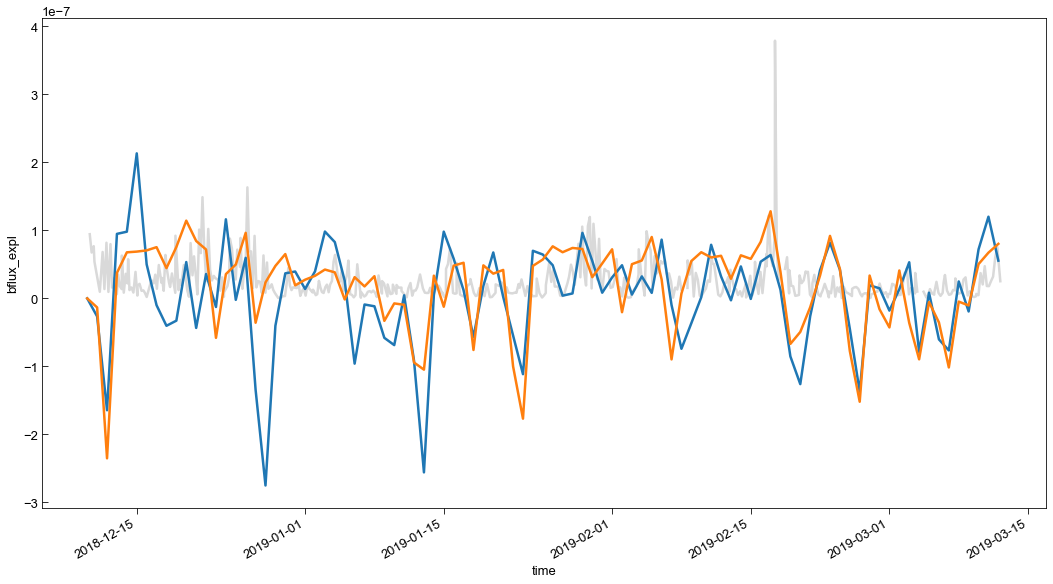

In [225]:
data =    dat_saz
dx = gsw.distance(data.lon, data.lat)

dx_grid = np.arange(3000, dx.cumsum()[-1], 3000)

db = griddata(dx.cumsum(), np.abs(np.diff(data.ml_b)), dx_grid)
dt = griddata(dx.cumsum(), date2num(data.time),        dx_grid)

plot(pd.to_datetime(num2date(dt)).values, db/3000, c='0.85')

bx_saz = db/3000
bx_saz_time = pd.to_datetime(num2date(dt)).values

dat_saz_1D.bflux_data.plot()
dat_saz_1D.bflux_expl.plot()

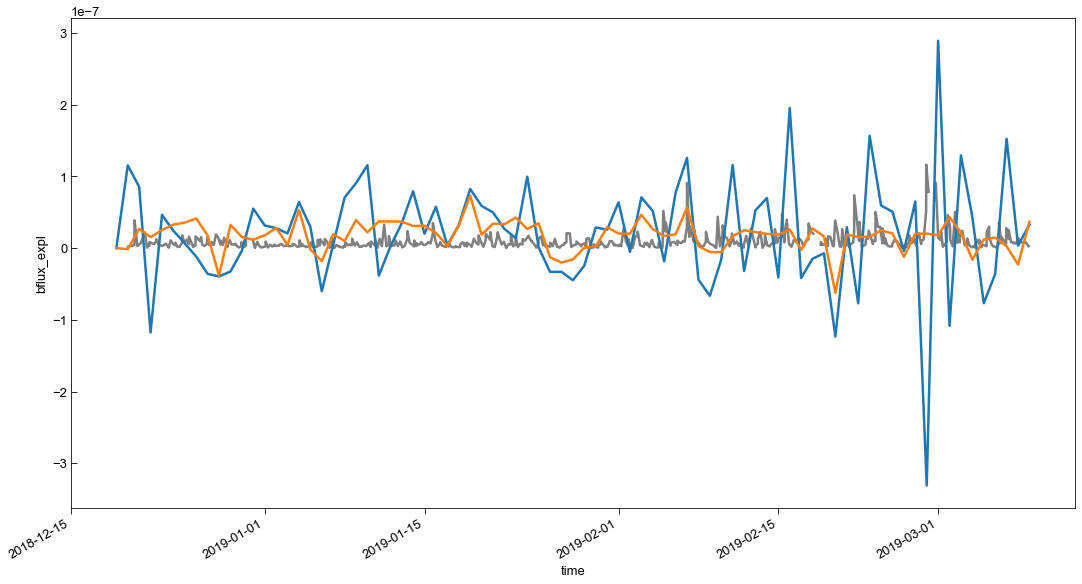

In [224]:
data =    dat_apz
dx = gsw.distance(data.lon, data.lat)

dx_grid = np.arange(3000, dx.cumsum()[-1], 3000)

db = griddata(dx.cumsum(), np.abs(np.diff(data.ml_b)), dx_grid)
dt = griddata(dx.cumsum(), date2num(data.time),        dx_grid)

plot(pd.to_datetime(num2date(dt)).values, db/3000, c='0.5')

bx_apz = db/3000
bx_apz_time = pd.to_datetime(num2date(dt)).values

dat_apz_1D.bflux_data.plot()
dat_apz_1D.bflux_expl.plot()

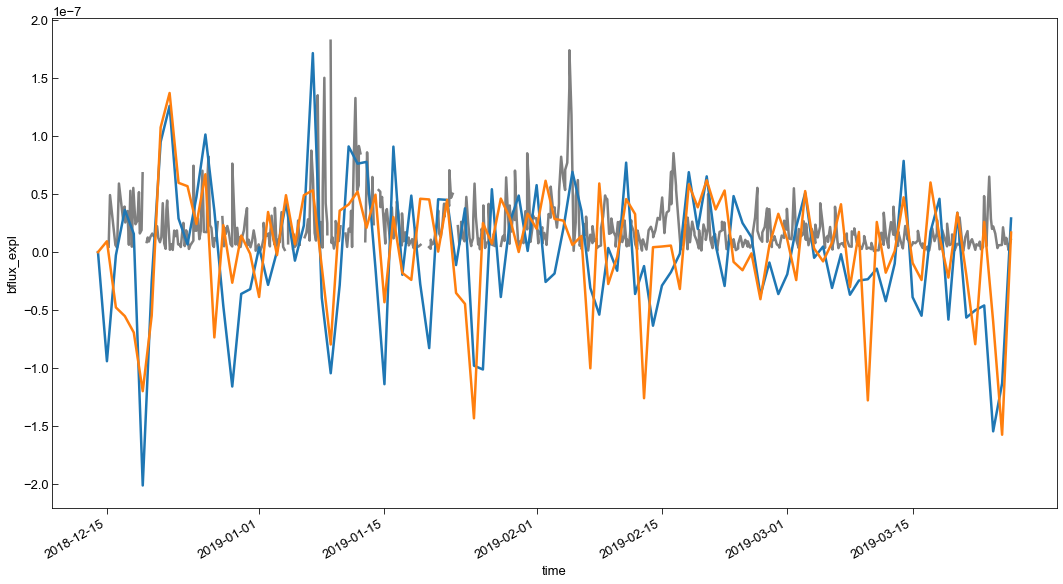

In [223]:
data =    dat_miz
dx = gsw.distance(data.lon, data.lat)

dx_grid = np.arange(3000, dx.cumsum()[-1], 3000)

db = griddata(dx.cumsum(), np.abs(np.diff(data.ml_b)), dx_grid)
dt = griddata(dx.cumsum(), date2num(data.time),        dx_grid)

plot(pd.to_datetime(num2date(dt)).values, db/3000, c='0.5')

bx_miz = db/3000
bx_miz_time = pd.to_datetime(num2date(dt)).values

dat_miz_1D.bflux_data.plot()
dat_miz_1D.bflux_expl.plot()

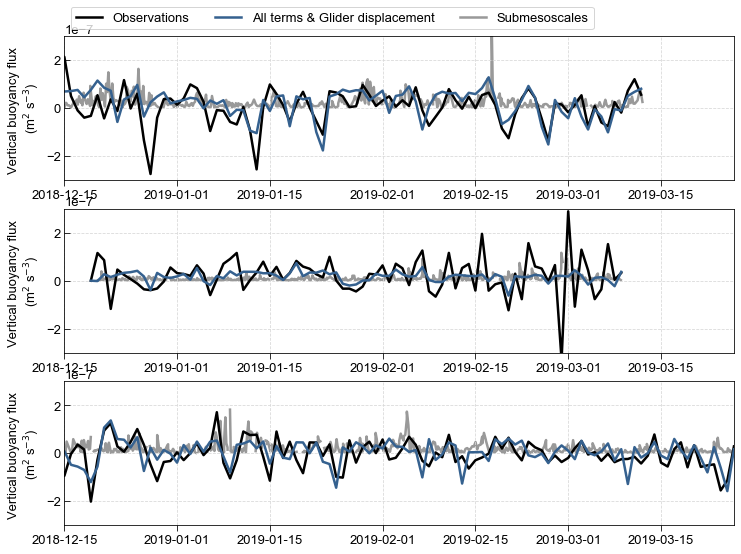

In [245]:
fig, ax = subplots(3, figsize=[12, 9])

ax[0].plot(dat_saz_1D.time    , dat_saz_1D.bflux_data,    c='k', label='Observations')
ax[0].plot(dat_saz_1D.time    , dat_saz_1D.bflux_expl,    c=my_clrs[1], label='All terms & Glider displacement')
ax[0].plot(bx_saz_time        , bx_saz,                   c='0.6', label='Submesoscales', zorder=0)

ax[1].plot(dat_apz_1D.time    , dat_apz_1D.bflux_data,    c='k', label='Observations')
ax[1].plot(dat_apz_1D.time    , dat_apz_1D.bflux_expl,    c=my_clrs[1], label='All terms & Glider displacement')
ax[1].plot(bx_apz_time        , bx_apz,                   c='0.6', label='Submesoscales', zorder=0)

ax[2].plot(dat_miz_1D.time    , dat_miz_1D.bflux_data,    c='k', label='Observations')
ax[2].plot(dat_miz_1D.time    , dat_miz_1D.bflux_expl,    c=my_clrs[1], label='All terms & Glider displacement')
ax[2].plot(bx_miz_time        , bx_miz,                   c='0.6', label='Submesoscales', zorder=0)

[a.set_ylim(-3e-7, 3e-7) for a in ax]
[a.set_xlim('2018-12-15', '2019-03-26') for a in ax]
[a.grid(ls='--', c='0.85') for a in ax]
[a.set_ylabel('Vertical buoyancy flux \n(m$^2$ s$^{-3}$)') for a in ax]
ax[0].legend(loc=2, ncol=5, bbox_to_anchor=(0, 1.25))

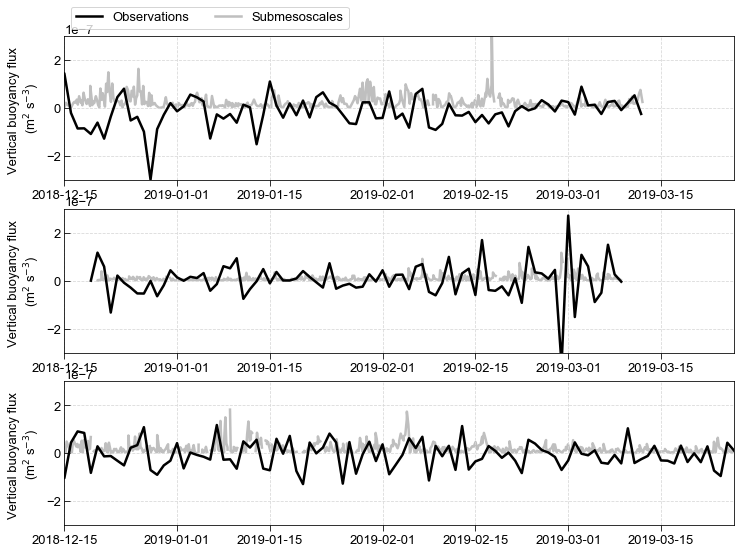

In [235]:
fig, ax = subplots(3, figsize=[12, 9])

ax[0].plot(dat_saz_1D.time    , dat_saz_1D.bflux_data-dat_saz_1D.bflux_expl,    c='k', label='Observations')
ax[0].plot(bx_saz_time        , bx_saz,                   c='0.75', label='Submesoscales', zorder=0)

ax[1].plot(dat_apz_1D.time    , dat_apz_1D.bflux_data-dat_apz_1D.bflux_expl,    c='k', label='Observations')
ax[1].plot(bx_apz_time        , bx_apz,                   c='0.75', label='Submesoscales', zorder=0)

ax[2].plot(dat_miz_1D.time    , dat_miz_1D.bflux_data-dat_miz_1D.bflux_expl,    c='k', label='Observations')
ax[2].plot(bx_miz_time        , bx_miz,                   c='0.75', label='Submesoscales', zorder=0)

[a.set_ylim(-3e-7, 3e-7) for a in ax]
[a.set_xlim('2018-12-15', '2019-03-26') for a in ax]
[a.grid(ls='--', c='0.85') for a in ax]
[a.set_ylabel('Vertical buoyancy flux \n(m$^2$ s$^{-3}$)') for a in ax]
ax[0].legend(loc=2, ncol=5, bbox_to_anchor=(0, 1.25))

### Estimating submesoscale buoyancy flux

(array([131., 221., 102.,  24.,   4.,   2.,   1.,   0.,   2.,   6.,   1.,
          0.,   7.,   2.,   3.,   1.,   3.,   3.,   6.,  10.,  11.,   4.,
          9.,   6.,   5.,   5.,   1.,   6.,   3.,   9.,  11.,   7.,  17.,
         17.,  20.,  24.,  22.,  24.,  29.,  30.,  26.,  23.,  30.,  17.,
         18.,  15.,   9.,  18.,  13.]),
 array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
        1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100,
        2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200,
        3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300,
        4400, 4500, 4600, 4700, 4800, 4900]),
 <a list of 49 Patch objects>)

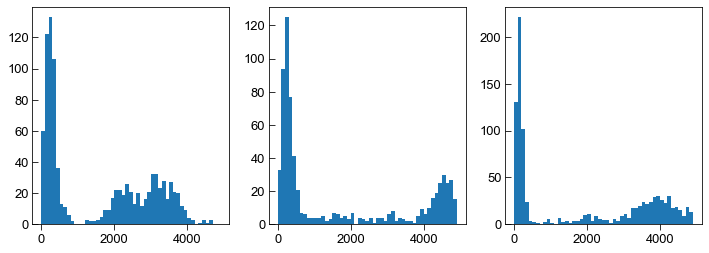

In [165]:
fig, ax = subplots(1, 3, figsize=[12, 4])

ax[0].hist(gsw.distance(dat_saz.lon, dat_saz.lat), bins=np.arange(0, 5000, 100), width=100)
ax[1].hist(gsw.distance(dat_apz.lon, dat_apz.lat), bins=np.arange(0, 5000, 100), width=100)
ax[2].hist(gsw.distance(dat_miz.lon, dat_miz.lat), bins=np.arange(0, 5000, 100), width=100)

In [169]:
dat_saz['ml_d'] = (('time'), gsw.rho(dat_saz.ml_s, dat_saz.ml_t, 0))
dat_apz['ml_d'] = (('time'), gsw.rho(dat_apz.ml_s, dat_apz.ml_t, 0))
dat_miz['ml_d'] = (('time'), gsw.rho(dat_miz.ml_s, dat_miz.ml_t, 0))

In [170]:
dat_saz['ml_b'] = (('time'), -9.81*(dat_saz.ml_d-1027)/1027)
dat_apz['ml_b'] = (('time'), -9.81*(dat_apz.ml_d-1027)/1027)
dat_miz['ml_b'] = (('time'), -9.81*(dat_miz.ml_d-1027)/1027)

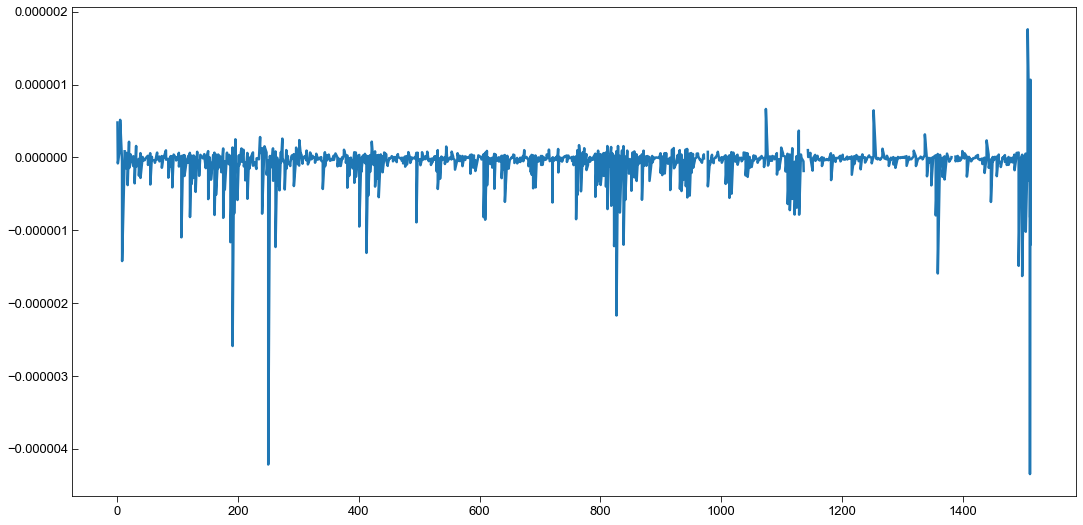

In [179]:


plot(dx.cumsum()/1000, np.diff(dat_saz.ml_b)/dx)

In [209]:
def fillnans(data, window=1):
    
    data_new = np.ndarray(len(data))
    
    for i, val in enumerate(data):
        
        if val > 0:  
            data_new[i] = int(data[i])
            continue
            
        else:
            data_new[i] = int(np.nanmean(data[i-window:i+window+1]))
            
    return data_new

ValueError: cannot convert float NaN to integer

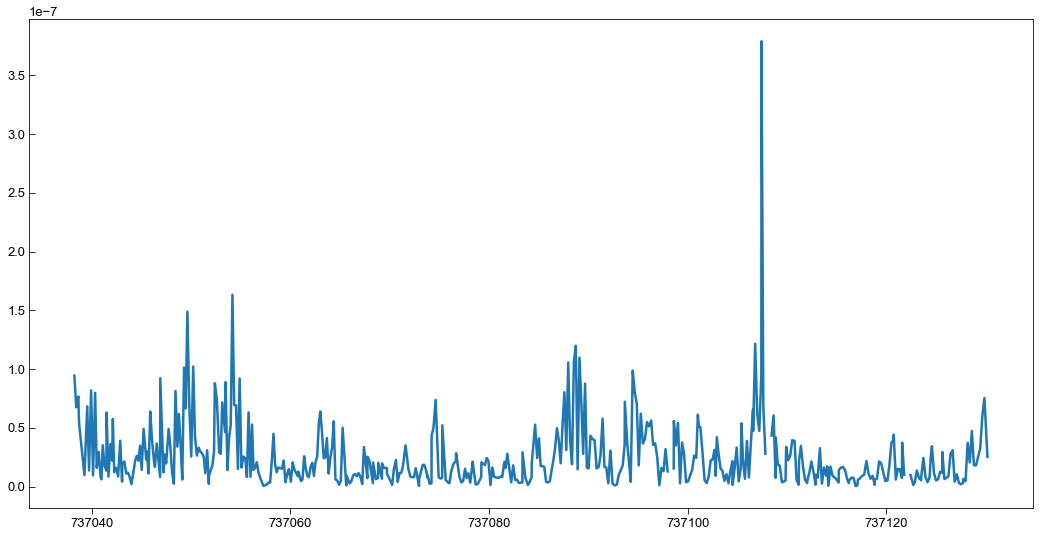

In [210]:
data =    dat_saz
data_1D = dat_saz_1D

dx = gsw.distance(data.lon, data.lat)

dx_grid = np.arange(3000, dx.cumsum()[-1], 3000)

db = griddata(dx.cumsum(), np.abs(np.diff(data.ml_b)), dx_grid)
dt = griddata(dx.cumsum(), date2num(data.time), dx_grid)

db_1D = griddata(dt, db/3000, date2num(data_1D.time))

plot(dt, db/3000)

db_1D = fillnans(db_1D, window=2)
plot(date2num(data_1D.time), db_1D)

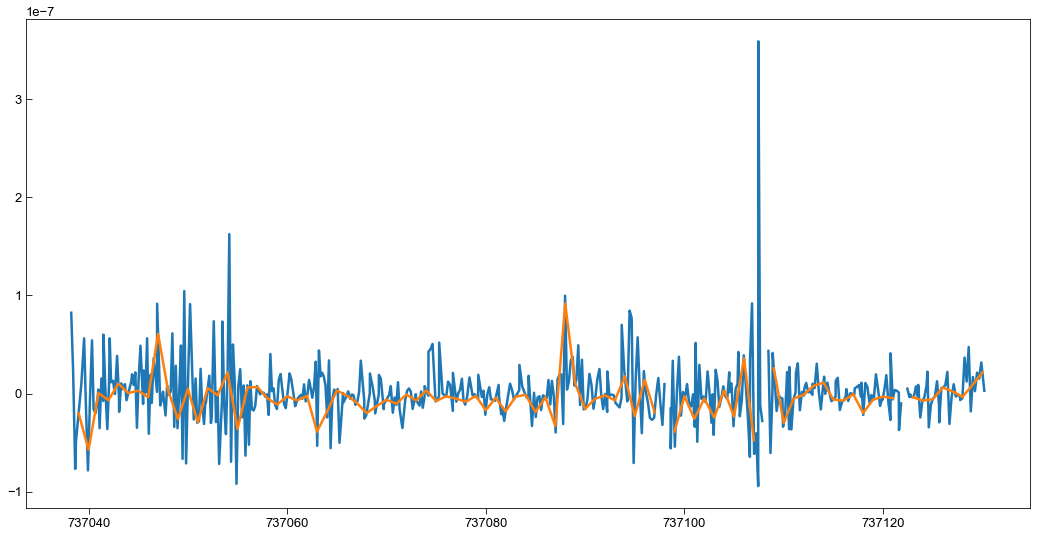

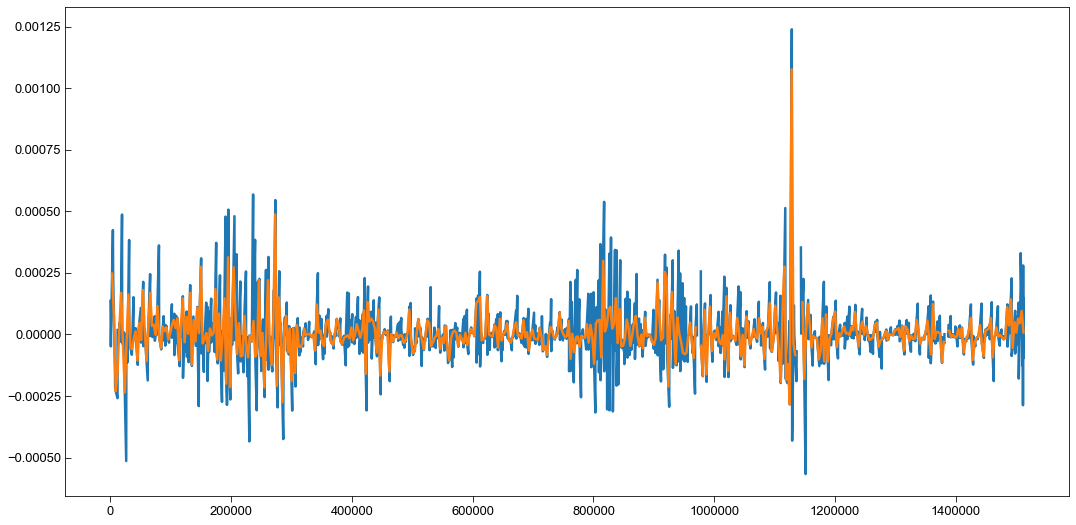

In [185]:
plot(dx.cumsum(), np.diff(dat_saz.ml_b))
plot(dx_grid, db_saz)
plot()

### Extra material

In [ ]:
# ep_cfsv2 = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/precipitation_evaporation/CFSv2/*.nc')
# ep_era5  = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/precipitation_evaporation/ERA5/*.nc')
# ep_jra55 = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/precipitation_evaporation/JRA55/*.nc')

ep_era5  = adjust_lon_xr_dataset(ep_era5, lon_name='longitude')
# ep_jra55 = adjust_lon_xr_dataset(ep_jra55, lon_name='g4_lon_2')
# ep_cfsv2 = adjust_lon_xr_dataset(ep_cfsv2, lon_name='lon')

# Change to consisent naming convention for longitude and latitudes
# ep_jra55 = ep_jra55.rename({'g4_lat_1'           : 'latitude',
#                             'g4_lon_2'           : 'longitude',
#                             'initial_time0_hours': 'time'})

# ep_cfsv2 = ep_cfsv2.rename({'lon': 'longitude',
#                             'lat': 'latitude'})

# Get the mean daily values for all products
# ep_cfsv2 = ep_cfsv2.resample(time='1D', loffset='12H').mean()
# ep_jra55 = ep_jra55.resample(time='1D', loffset='12H').mean()
ep_era5  = ep_era5.resample(time='1D', loffset='12H').mean()

# convert to m/s
ep_jra55['e_minus_p'] = (('time', 'latitude', 'longitude'), (ep_jra55.EVP_GDS4_SFC_ave3h - ep_jra55.TPRAT_GDS4_SFC_ave3h)/(1000*86400))
# ep_era5 ['e_minus_p'] = (('time', 'latitude', 'longitude'), (ep_era5.e - ep_era5.tp)/3600)
# ep_cfsv2['e_minus_p'] = (('time', 'latitude', 'longitude'), ep_cfsv2.EMNP_L1_Avg_11/(100*86400))

In [ ]:
import gsw
alpha=gsw.alpha(dat_saz_12H.temp.mean(dim=('time'))[0], dat_saz_12H.salt.mean(dim=('time'))[0], 0)
beta=gsw.beta(dat_saz_12H.temp.mean(dim=('time'))[0], dat_saz_12H.salt.mean(dim=('time'))[0], 0)

dT = 11-6
dS = (dT*alpha)/beta

fig,ax=subplots(3,2, figsize=[7, 12])

ax[0,0].plot(dat_saz_12H.temp.mean(dim='time'), dat_saz_12H.depth, c='steelblue')
ax00=ax[0,0].twiny()
ax00.plot(dat_saz_12H.salt.mean(dim='time'),    dat_saz_12H.depth, c='green')

ax[1,0].plot(dat_apz_12H.temp.mean(dim='time'), dat_apz_12H.depth, c='steelblue')
ax10=ax[1,0].twiny()
ax10.plot(dat_apz_12H.salt.mean(dim='time'),    dat_apz_12H.depth, c='green')

ax[2,0].plot(dat_miz_12H.temp.mean(dim='time'), dat_miz_12H.depth, c='steelblue')
ax20=ax[2,0].twiny()
ax20.plot(dat_miz_12H.salt.mean(dim='time'),    dat_miz_12H.depth, c='green')

ax[0,0].set_ylim(300, 0)
ax[1,0].set_ylim(300, 0)
ax[2,0].set_ylim(300, 0)

ax[0,0].set_xlim(6, 11)
ax00.set_xlim(33.8, 33.8+2.04)

ax[1,0].set_xlim(0, 2)
ax00.set_xlim(34, 34+0.85)

ax[2,0].set_xlim(-2, 2)
ax00.set_xlim(33.8, 33.8+1.70)

#### Stratification

In [ ]:

b_saz = (-9.81*(dat_saz_1D.density-1025))/1025
b_apz = (-9.81*(dat_apz_1D.density-1025))/1025
b_miz = (-9.81*(dat_miz_1D.density-1025))/1025

N2_saz = -np.diff(b_saz, axis=1).T
N2_apz = -np.diff(b_apz, axis=1).T
N2_miz = -np.diff(b_miz, axis=1).T

# plot the sections
plt.rcParams['figure.figsize'] = (12,9)

font = {'family' : 'Arial',
        'weight' : 'ultralight',
        'size'   : 14}

fig, ax = subplots(3, sharex=True)

ax[0].contourf(dat_saz_1D.time.values, dat_saz_1D.depth[:-1], np.abs(N2_saz), levels=np.arange(0, 3e-4, 1e-5))
ax[1].contourf(dat_apz_1D.time.values, dat_apz_1D.depth[:-1], np.abs(N2_apz), levels=np.arange(0, 3e-4, 1e-5))
ax[2].contourf(dat_miz_1D.time.values, dat_miz_1D.depth[:-1], np.abs(N2_miz), levels=np.arange(0, 3e-4, 1e-5))

[a.set_ylim(300, 0) for a in ax]

cs1=ax[0].contour(dat_saz_1D.time.values, dat_saz_1D.depth, dat_saz_1D.density.T, levels=['1026.7'], colors='0.8')
cs2=ax[1].contour(dat_apz_1D.time.values, dat_apz_1D.depth, dat_apz_1D.density.T, levels=['1027.6'], colors='0.8')
cs3=ax[2].contour(dat_miz_1D.time.values, dat_miz_1D.depth, dat_miz_1D.density.T, levels=['1027.75'], colors='0.8')

# ax[0].plot(dat_saz_1D.time.values, iso_dpt_saz, c='r')
# ax[1].plot(dat_apz_1D.time.values, iso_dpt_apz, c='r')
# ax[2].plot(dat_miz_1D.time.values, iso_dpt_miz, c='r')


from scipy.interpolate import griddata

x = np.array(cs1.allsegs).squeeze()[:, 0]
y = np.array(cs1.allsegs).squeeze()[:, 1]

iso_dpt_saz = griddata(x, y, date2num(dat_saz_1D.time.values))

x = np.array(cs2.allsegs).squeeze()[:, 0]
y = np.array(cs2.allsegs).squeeze()[:, 1]

iso_dpt_apz = griddata(x, y, date2num(dat_apz_1D.time.values))

x = np.array(cs3.allsegs[0][0]).squeeze()[:, 0]
y = np.array(cs3.allsegs[0][0]).squeeze()[:, 1]

iso_dpt_miz = griddata(x, y, date2num(dat_miz_1D.time.values))

#  get isopycnals of the lower pycnocline
iso_dpt_miz[0] = iso_dpt_miz[1]
iso_dpt_miz = iso_dpt_miz.astype(int)
iso_dpt_saz = iso_dpt_saz.astype(int)
iso_dpt_apz[-1] = iso_dpt_apz[-2]
iso_dpt_apz = iso_dpt_apz.astype(int)

# average the stratification above that pycnocline
N2_iso_saz_mean = [np.nanmean(N2_saz[:val, i]) for i, val in enumerate(iso_dpt_saz)]
N2_iso_apz_mean = [np.nanmean(N2_apz[:val, i]) for i, val in enumerate(iso_dpt_apz)]
N2_iso_miz_mean = [np.nanmean(N2_miz[:val, i]) for i, val in enumerate(iso_dpt_miz)]

# sum the stratification above that pycnocline
N2_iso_saz_sum = [np.nansum(N2_saz[:val, i]) for i, val in enumerate(iso_dpt_saz)]
N2_iso_apz_sum = [np.nansum(N2_apz[:val, i]) for i, val in enumerate(iso_dpt_apz)]
N2_iso_miz_sum = [np.nansum(N2_miz[:val, i]) for i, val in enumerate(iso_dpt_miz)]

dat_saz_1D['N2_iso_int'] = (('time'), N2_iso_saz_sum)
dat_apz_1D['N2_iso_int'] = (('time'), N2_iso_apz_sum)
dat_miz_1D['N2_iso_int'] = (('time'), N2_iso_miz_sum)

dat_saz_1D['N2_iso_mean'] = (('time'), N2_iso_saz_mean)
dat_apz_1D['N2_iso_mean'] = (('time'), N2_iso_apz_mean)
dat_miz_1D['N2_iso_mean'] = (('time'), N2_iso_miz_mean)

In [ ]:
# hf_cfsv2 = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/heat_flux/CFSv2/*.nc')
# hf_era5  = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/heat_flux/ERA5/*.nc')
# hf_jra55 = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/heat_flux/JRA55/*.nc')

# # # Change to consisent naming convention for longitude and latitudes
# hf_cfsv2 = hf_cfsv2.rename({'lon': 'longitude',
#                             'lat': 'latitude', 
#                            'LHTFL_L1': 'lhf',
#                            'SHTFL_L1': 'shf',
#                            'DSWRF_L1': 'dsw',
#                            'USWRF_L1': 'usw',
#                            'DLWRF_L1': 'dlw',
#                            'ULWRF_L1': 'ulw'})

# hf_era5 = hf_era5.rename({'slhf': 'lhf',
#                           'sshf': 'shf',
#                           'ssr':  'swr',
#                           'str':  'lwr'})

# hf_jra55 = hf_jra55.rename({'g4_lon_2': 'longitude',
#                             'g4_lat_1': 'latitude', 
#                             'initial_time0_hours': 'time',
#                            'LHTFL_GDS4_SFC_ave3h': 'lhf',
#                            'SHTFL_GDS4_SFC_ave3h': 'shf',
#                            'DSWRF_GDS4_SFC_ave3h': 'dsw',
#                            'USWRF_GDS4_SFC_ave3h': 'usw',
#                            'DLWRF_GDS4_SFC_ave3h': 'dlw',
#                            'ULWRF_GDS4_SFC_ave3h': 'ulw'})

# hf_era5  = adjust_lon_xr_dataset(hf_era5,  lon_name='longitude')
# hf_jra55 = adjust_lon_xr_dataset(hf_jra55, lon_name='longitude')
# hf_cfsv2 = adjust_lon_xr_dataset(hf_cfsv2, lon_name='longitude')

# # # Get the mean daily values for all products
# hf_cfsv2 = hf_cfsv2.resample(time='1D', loffset='12H').mean()
# hf_jra55 = hf_jra55.resample(time='1D', loffset='12H').mean()
# hf_era5  = hf_era5.resample(time='1D', loffset='12H').mean()
